In [1]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm


from pathlib import Path
from torch.utils.data import DataLoader
import time

In [2]:
#Data load 
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/data/prod_full.json", "r") as read_file:
    full = json.load(read_file)

In [3]:
print("length of data :", len(full))

length of data : 15478


In [4]:
#Split the data into three categories
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)

In [5]:
len(train), len(valid), len(test)

(10834, 2322, 2322)

In [6]:
#Read the dataa and foramting the data 
def read_data(squad):
    
    contexts = []
    questions = []
    answers = []

    for group in squad:
    # for passage in group['paragraphs']:
        context = group['context']
        for qa in group['qas']:
            question = qa['question']
            for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer)

    return contexts, questions, answers

#Call the functions
train_contexts, train_questions, train_answers = read_data(train)
valid_contexts, valid_questions, valid_answers = read_data(valid)
test_contexts, test_questions, test_answers = read_data(test)

In [7]:
len(train_contexts), len(train_answers), len(train_questions)
print("shape of train:>>", len(train_contexts))
print("shape of valid:>>", len(valid_contexts))
print("shape of test:>>", len(test_contexts))

shape of train:>> 35207
shape of valid:>> 7393
shape of test:>> 7321


In [8]:
train_contexts[1], train_questions[1], train_answers[1]

('Because of the rapid succession of technological developments, the architecture and material composition of many products used in daily life have drastically changed over the last decades. As a result, well-adjusted recycling technologies need to be developed and installed to cope with these evolutions. This is essential to guarantee continued access to materials and to reduce the ecological impact of our material consumption. However, limited information is currently available on the material composition of arising waste streams and even less on how these waste streams will evolve. Therefore, this paper presents a methodology to forecast trends in the material composition of waste streams. To demonstrate the applicability and value of the proposed methodology, it is applied to forecast the evolution of plastic housing waste from flat panel display (FPD) TVs, FPD monitors, cathode ray tube (CRT) TVs and CRT monitors. The results of the presented forecasts indicate that a wide variety

In [9]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two so we fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)
add_end_idx(test_answers, test_contexts)

In [10]:
# You can see that now we get the answer_end also
print(train_questions[-10])
print(train_answers[-10])
print(train_contexts[-10])

What are the products formed?
{'text': 'plastic production waste disposal', 'answer_start': 1639, 'answer_end': 1672}
Along with the increasing amount of plastic production and waste disposal, the presence of microplastics has been confirmed in all compartments of ecosystems. The microplastics in biota is of particular concern due to the potential eco-risks associated with long term exposure and the potential for transportation along food webs. Decapoda represents a diverse taxonomic group within the subphylum Crustacea, and some of which are highly valued in fishery and biological production. The interaction between microplastic pollution and wild populations of decapod crustaceans have been documented less than fish or bivalves but are critical to understand the fates of microplastics in marine eco-systems and enrich the baselines for consumption analyses. Our review systematically summarizes the occurrence, abundance and characteristics of microplastics detected in edible and non-ed

In [11]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

In [12]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
no_of_encodings = len(valid_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 7393 context-question pairs


In [14]:
no_of_encodings = len(test_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 7321 context-question pairs


In [15]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 35207 context-question pairs


In [16]:
print(train_encodings['input_ids'][0])

[101, 2138, 1997, 1996, 5915, 8338, 1997, 10660, 8973, 1010, 1996, 4294, 1998, 3430, 5512, 1997, 2116, 3688, 2109, 1999, 3679, 2166, 2031, 21040, 2904, 2058, 1996, 2197, 5109, 1012, 2004, 1037, 2765, 1010, 2092, 1011, 10426, 17874, 6786, 2342, 2000, 2022, 2764, 1998, 5361, 2000, 11997, 2007, 2122, 6622, 2015, 1012, 2023, 2003, 6827, 2000, 11302, 2506, 3229, 2000, 4475, 1998, 2000, 5547, 1996, 12231, 4254, 1997, 2256, 3430, 8381, 1012, 2174, 1010, 3132, 2592, 2003, 2747, 2800, 2006, 1996, 3430, 5512, 1997, 17707, 5949, 9199, 1998, 2130, 2625, 2006, 2129, 2122, 5949, 9199, 2097, 19852, 1012, 3568, 1010, 2023, 3259, 7534, 1037, 16134, 2000, 19939, 12878, 1999, 1996, 3430, 5512, 1997, 5949, 9199, 1012, 2000, 10580, 1996, 10439, 19341, 8553, 1998, 3643, 1997, 1996, 3818, 16134, 1010, 2009, 2003, 4162, 2000, 19939, 1996, 6622, 1997, 6081, 3847, 5949, 2013, 4257, 5997, 4653, 1006, 1042, 17299, 1007, 2694, 2015, 1010, 1042, 17299, 15410, 1010, 4937, 6806, 3207, 4097, 7270, 1006, 13675, 2102, 1

In [17]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] because of the rapid succession of technological developments, the architecture and material composition of many products used in daily life have drastically changed over the last decades. as a result, well - adjusted recycling technologies need to be developed and installed to cope with these evolutions. this is essential to guarantee continued access to materials and to reduce the ecological impact of our material consumption. however, limited information is currently available on the material composition of arising waste streams and even less on how these waste streams will evolve. therefore, this paper presents a methodology to forecast trends in the material composition of waste streams. to demonstrate the applicability and value of the proposed methodology, it is applied to forecast the evolution of plastic housing waste from flat panel display ( fpd ) tvs, fpd monitors, cathode ray tube ( crt ) tvs and crt monitors. the results of the presented forecasts indicate that a w

In [18]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(i)
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # print(i)

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

        encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [19]:
add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)
add_token_positions(test_encodings, test_answers)

In [20]:
train_encodings['start_positions'][:10]

[17, 204, 120, 196, 212, 40, 156, 148, 177, 193]

# Dataset definition 🗄️
We have to define our dataset using the PyTorch Dataset class from torch.utils in order create our dataloaders after that.

In [21]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [22]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)
test_dataset  = SQuAD_Dataset(test_encodings)

**Dataloader**

In [23]:
from torch.utils.data import DataLoader

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Load pretrained bert
We are going to use the bert-case-uncased from the huggingface transformers.

In [24]:
from transformers import BertForQuestionAnswering

# model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

In [25]:
# Check on the available device - use GPU
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda:1


In [26]:
from transformers import AdamW
import torch.nn as nn

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 10
# epochs = 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [27]:
val_loader = valid_loader

In [28]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 100

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()

    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader): 

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass 
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss 
    print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 100 / 2201 
Loss: 2.0 

Batch 200 / 2201 
Loss: 1.8 

Batch 300 / 2201 
Loss: 1.5 

Batch 400 / 2201 
Loss: 1.8 

Batch 500 / 2201 
Loss: 1.7 

Batch 600 / 2201 
Loss: 1.7 

Batch 700 / 2201 
Loss: 2.2 

Batch 800 / 2201 
Loss: 1.7 

Batch 900 / 2201 
Loss: 1.5 

Batch 1000 / 2201 
Loss: 1.7 

Batch 1100 / 2201 
Loss: 1.5 

Batch 1200 / 2201 
Loss: 1.9 

Batch 1300 / 2201 
Loss: 1.6 

Batch 1400 / 2201 
Loss: 2.0 

Batch 1500 / 2201 
Loss: 1.4 

Batch 1600 / 2201 
Loss: 1.6 

Batch 1700 / 2201 
Loss: 2.4 

Batch 1800 / 2201 
Loss: 1.4 

Batch 1900 / 2201 
Loss: 2.0 

Batch 2000 / 2201 
Loss: 1.5 

Batch 2100 / 2201 
Loss: 1.9 

Batch 2200 / 2201 
Loss: 1.5 

############Evaluate############
Batch 100 / 463 
Loss: 1.5 

Batch 200 / 463 
Loss: 1.8 

Batch 300 / 463 
Loss: 1.7 

Batch 400 / 463 
Loss: 1.2 


-------Epoch  1 -------
Training Loss: 1.832449284346198 
Validation Loss: 1.5714699956819769 
Time:  1794.5366833209991 
----------------------- 


Batch 600 / 2201 
Loss: 1.5 

Batch 700 / 2201 
Loss: 1.5 

Batch 800 / 2201 
Loss: 1.4 

Batch 900 / 2201 
Loss: 1.5 

Batch 1000 / 2201 
Loss: 1.2 

Batch 1100 / 2201 
Loss: 1.4 

Batch 1200 / 2201 
Loss: 1.6 

Batch 1300 / 2201 
Loss: 1.7 

Batch 1400 / 2201 
Loss: 1.8 

Batch 1500 / 2201 
Loss: 1.4 

Batch 1600 / 2201 
Loss: 2.0 

Batch 1700 / 2201 
Loss: 1.3 

Batch 1800 / 2201 
Loss: 1.5 

Batch 1900 / 2201 
Loss: 1.5 

Batch 2000 / 2201 
Loss: 1.5 

Batch 2100 / 2201 
Loss: 1.1 

Batch 2200 / 2201 
Loss: 1.5 

############Evaluate############
Batch 100 / 463 
Loss: 1.2 

Batch 200 / 463 
Loss: 2.1 

Batch 300 / 463 
Loss: 1.6 

Batch 400 / 463 
Loss: 1.1 


-------Epoch  9 -------
Training Loss: 1.4309840690325955 
Validation Loss: 1.4842478340696825 
Time:  1796.5478677749634 
----------------------- 


############Train############
Batch 100 / 2201 
Loss: 1.2 

Batch 200 / 2201 
Loss: 1.7 

Batch 300 / 2201 
Loss: 1.5 

Batch 400 / 2201 
Loss: 1.5 

Batch 500 / 2201 
Loss: 1.7

**Save the model in my drive in order not to run it each time**

In [29]:
model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only_uncased/"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only_uncased/tokenizer_config.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only_uncased/special_tokens_map.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only_uncased/vocab.txt',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only_uncased/added_tokens.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only_uncased/tokenizer.json')

# Step 12: Plot train and validation losses

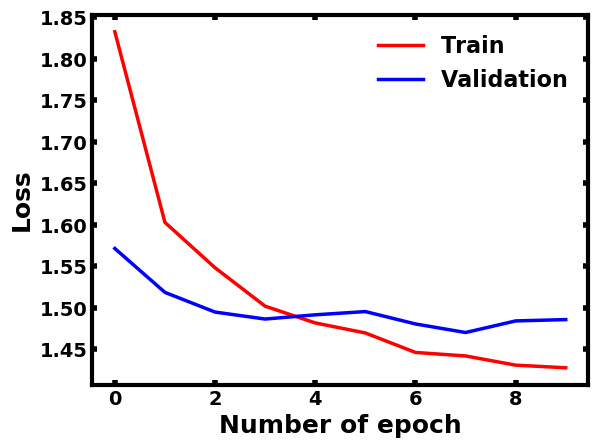

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='red', label= 'Train', linewidth=2.5)
plt.plot(range(len(val_losses)), val_losses, color =  'Blue', label = 'Validation', linewidth=2.5)
#plt.title('Classification loss')
plt.legend(frameon=False,prop={'weight':'bold',"size":16})
plt.xlabel('Number of epoch',fontweight='bold', fontsize=18)
plt.ylabel('Loss',fontweight='bold', fontsize=18)
#plt.title('GP Regression',fontweight='bold')
#plt.axis('square')
from matplotlib import rc

plt.rcParams['axes.linewidth'] = 3

plt.tick_params(axis="x", direction="in",width=4)
plt.tick_params(axis="y", direction="in", width=4)

rc('font', weight='bold')

plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.xticks(rotation = '0', fontsize = 14)
plt.yticks(rotation = '0', fontsize = 14)
#plt.legend(handles=h, labels=np.arange(0.9,0.85), title="Quality")
#plt.rcParams.update({'legend.fontweight':'bold'}
#plt.savefig('line_plot.pdf')
plt.savefig(r'/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/curve_learnin/learning_prod_uncased.pdf', dpi=5000)
plt.show()#

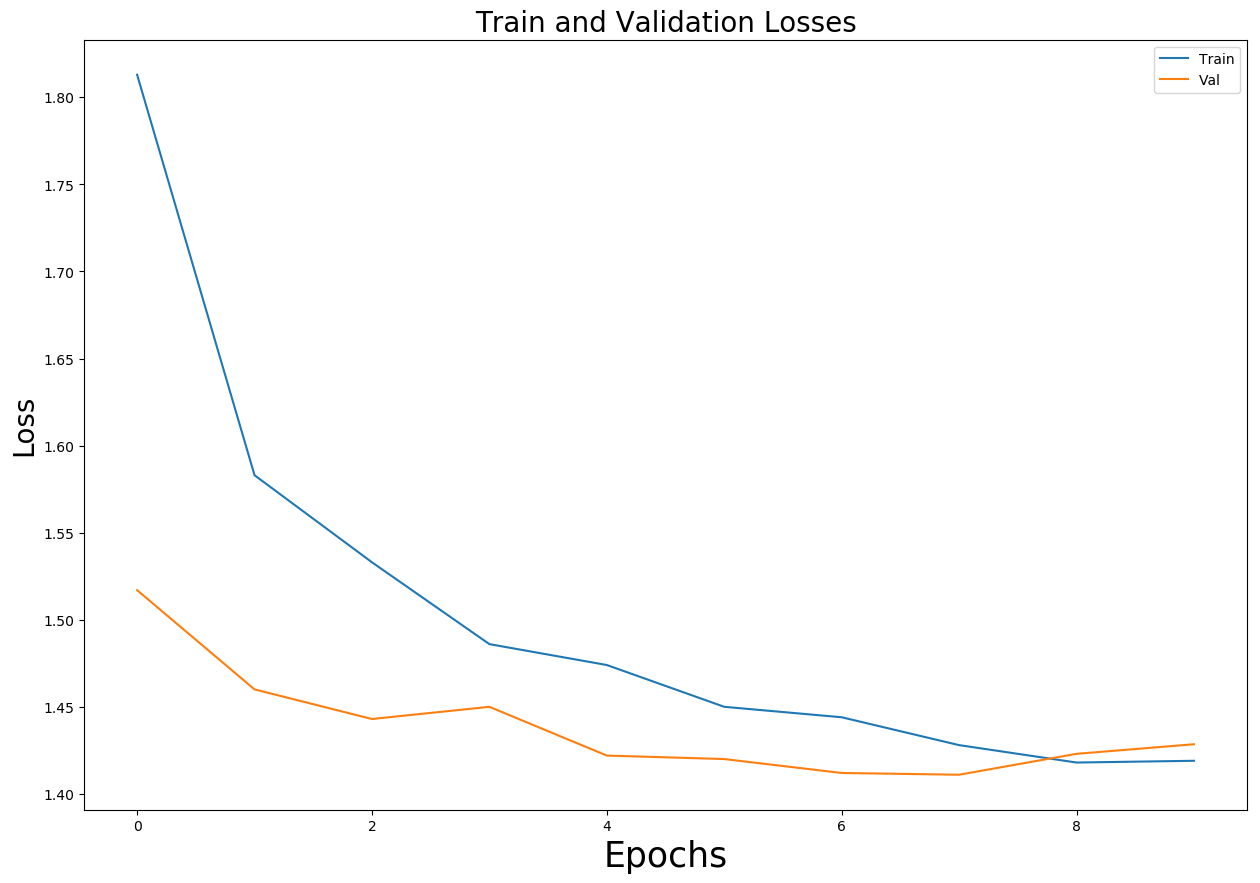

In [5]:
fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')













# Test
We are evaluating the model on the validation set by checking the model's predictions for the answer's start and end indexes and comparing with the true ones.

In [29]:
model.eval()

acc = []

for batch in tqdm(valid_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

acc = sum(acc)/len(acc)

print("\n\nT/P\tanswer_start\tanswer_end\n")
for i in range(len(start_true)):
    print(f"true\t{start_true[i]}\t{end_true[i]}\n"
        f"pred\t{start_pred[i]}\t{end_pred[i]}\n")

100%|████████████████████████████████████████████████████████████████| 307/307 [01:18<00:00,  3.93it/s]



T/P	answer_start	answer_end

true	87	88
pred	43	43

true	166	166
pred	43	43

true	18	23
pred	18	23

true	64	66
pred	18	23

true	27	27
pred	27	27

true	30	36
pred	27	27



# Testing

In [6]:
# import json
# with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/data/data qna/data_individual/with_dupli/bert/prod_test.json", "r") as read_file:
#     train_ca = json.load(read_file)



In [7]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm


from pathlib import Path
from torch.utils.data import DataLoader
import time

In [8]:
#Data load 
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/data/data qna/data_individual/with_dupli/prod_train_full_1.json", "r") as read_file:
    full = json.load(read_file)

In [9]:
len(full)

18916

In [10]:
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)

In [11]:
len(train), len(valid), len(test)

(13241, 2837, 2838)

# Ask question
We are going to use some functions from the official Evaluation Script v2.0 of SQuAD in order to test the fine-tuned model by asking some questions given a context. I have also looked at this notebook which evaluates BERT on SQuAD.

**Respectively, load the saved model**

In [9]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/"

model = BertForQuestionAnswering.from_pretrained(model_path)

tokenizer = BertTokenizerFast.from_pretrained(model_path)

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

model = model.to(device)

Working on cuda:1


In [133]:
##data list
context = []
answerss = []
question =[]

#loop data points
def extractquestions(test):
    for trai in test:
        context.append(trai['context'])
        question.append(trai['qas'][0]['question'])

    for sample in test:
        gold_answers = []
        for ans in sample['qas'][0]['answers']:
            gold_answers.append(ans['text'])
        answerss.append(gold_answers)
        
    return context, answerss, question

#Data for testing
context, answerss, question = extractquestions(valid)

In [134]:
F1 = []
preci = []
recal = []

In [135]:
def get_prediction_f1_0(context, question,f):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)
        start_logits = outputs[0]
        end_logits = outputs[1]

        def to_list(tensor):
            return tensor.detach().cpu().tolist()

        # convert our start and end logit tensors to lists
        start_logits = to_list(start_logits)[0]
        end_logits = to_list(end_logits)[0]

        # sort our start and end logits from largest to smallest, keeping track of the index
        start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
        end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

        # select the top n (in this case, 5)
#         print(start_idx_and_logit[:5])
#         print(end_idx_and_logit[:5]) 

        start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
        end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

        # convert the token ids from a tensor to a list
        tokens = to_list(inputs['input_ids'])[0]

        # question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
        question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

        import collections

        # keep track of all preliminary predictions
        PrelimPrediction = collections.namedtuple( 
            "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"]
        )

        prelim_preds = []
        for start_index in start_indexes:
            for end_index in end_indexes:
                # throw out invalid predictions
                if start_index in question_indexes:
                    continue
                if end_index in question_indexes:
                    continue
                if end_index < start_index:
                    continue
                prelim_preds.append(
                    PrelimPrediction(
                        start_index = start_index,
                        end_index = end_index,
                        start_logit = start_logits[start_index],
                        end_logit = end_logits[end_index]
                    )
                )

        # sort preliminary predictions by their score
        prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)

        # keep track of all best predictions
        BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "BestPrediction", ["text", "start_logit", "end_logit"]
        )

        nbest = []
        nbest_text =[]
        seen_predictions = []
        
        print("Number of best>>>>", f)
        for pred in prelim_preds:

            # for now we only care about the top 5 best predictions
            if len(nbest) >= f: 
                break

            # loop through predictions according to their start index
            if pred.start_index > 0: # non-null answers have start_index > 0

                text = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(
                        tokens[pred.start_index:pred.end_index+1]
                    )
                )
                # clean whitespace
                text = text.strip()
                text = " ".join(text.split())

                if text in seen_predictions:
                    continue

                # flag this text as being seen -- if we see it again, don't add it to the nbest list
                seen_predictions.append(text) 

                # add this text prediction to a pruned list of the top 5 best predictions
                nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

        # and don't forget -- include the null answer!
        nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

    except:
        print('no available')
        
        seen_predictions = ["nothings"]


    return seen_predictions

In [136]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [137]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [138]:
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

In [139]:
def question_answer(context, question,answerss,f):
    prediction = get_prediction_f1_0(context,question,f)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    temp_f1 = []
    for pre in prediction:
        
        print(answerss, pre)

        if len(answerss) != 0:
            em_score = max((exact_match(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
    #         for answer in answerss:
    #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
    # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
    #         print(presion, recall)

            f1_score = max((compute_f1(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
        
            print(f1_score)
    #         if f1_score == 1.0:
            temp_f1.append(f1_score)
    

    #         elif f1_score == 0:
    #             prediction_0 = get_prediction_f1_0(context,question)
    #             print(prediction_0)

    #             f1_score_0 = max((compute_f1(prediction_0, answer)) for answer in answerss)
    #             print(f1_score_0)
    #             F1.append(f1_score_0)

    #         preci.append(presion)
    #         recal.append(recall)
        else:
            em_score = 0
            f1_score = 0
            temp_f1 = [0]
            
    #if max(temp_f1) <=1.0:
        
    if max(temp_f1) ==1.0:
        F1.append(max(temp_f1))
        
    else:
        temp_f1 = []
        for pre in prediction:

            print(answerss, pre)

            if len(answerss) != 0:
                em_score = max((exact_match(pre, answer)) for answer in answerss)
        #         for answer in answerss:
        #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
        # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
        #         print(presion, recall)

                f1_score = max((compute_f1(pre, answer)) for answer in answerss)
                print(f1_score)
        #         if f1_score == 1.0:
                temp_f1.append(f1_score)


        #         elif f1_score == 0:
        #             prediction_0 = get_prediction_f1_0(context,question)
        #             print(prediction_0)

        #             f1_score_0 = max((compute_f1(prediction_0, answer)) for answer in answerss)
        #             print(f1_score_0)
        #             F1.append(f1_score_0)

        #         preci.append(presion)
        #         recal.append(recall)
            else:
                em_score = 0
                f1_score = 0
                temp_f1 = [0]
                
        F1.append(max(temp_f1))

    
    
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {max(temp_f1)}\n')

In [140]:
for i in range(len(valid)):
    print(i)
    question_answer(context[i], question[0],answerss[i], len(answerss[i]))

0
Number of best>>>> 1
['European energy industry'] European energy industry
1.0
Question: What are the products formed?
Prediction: ['European energy industry']
True Answer: ['European energy industry']
Exact match: True
F1 score: 1.0

1
Number of best>>>> 3
['usable energy', 'production cost', 'usable products'] production cost is high. Recycling of waste plastics is a conventional strategy to convert into usable products
0
['usable energy', 'production cost', 'usable products'] usable energy. Landfill requires large area to sink the waste, incineration – blast furnace for plastic waste emits toxic gases and the production cost is high. Recycling of waste plastics is a conventional strategy to convert into usable products
0
['usable energy', 'production cost', 'usable products'] usable products
1.0
Question: What are the products formed?
Prediction: ['production cost is high. Recycling of waste plastics is a conventional strategy to convert into usable products', 'usable energy. Land

Number of best>>>> 13
['operational energy use', 'nearly zero energy buildings', 'embodied energy', 'primary energy consumption', 'embodied energy coefficients', 'The derived embodied energy intensities', 'calculated primary energy use intensities', 'buildings’ energy environmental life cycle performance', 'The initial recurrent embodied energy', 'products', 'operational energy savings', 'energy conservation measures', 'embodied energy impact'] embodied energy of buildings is gaining more importance. This work elaborates the importance of embodied energy in Hellenic residential buildings by comparing the primary energy consumption during their life cycle. Field surveys were used to collect relevant data from local manufactures and determine the embodied energy coefficients of popular construction materials. The derived embodied energy intensities ( EEI ) and the calculated primary energy use intensities ( EUI ) are then used for benchmarking the buildings ’ energy and environmental lif

Number of best>>>> 3
['syngas production', 'energy production', 'HAC'] syngas production
1.0
['syngas production', 'energy production', 'HAC'] syngas production are highly beneficial. In packaging plastics, high density polyethylene ( HDPE ) occupies 20 % of the total waste plastics. Hence, the conversion of HDPE into syngas is essential for waste reduction and energy production
0
['syngas production', 'energy production', 'HAC'] syngas production are highly beneficial. In packaging plastics, high density polyethylene ( HDPE ) occupies 20 % of the total waste plastics. Hence, the conversion of HDPE into syngas is essential for waste reduction and energy production. Further, Indian coals possess high ash content ( 20 – 40 % ) and hence they produce a low calorific value gas on gasification. Hence, the co - gasification of these coals with suitable fuels such as HDPE can raise the heating value of syngas. In this context, HDPE is co - gasified with a high ash Indian coal using CO2 as the

Number of best>>>> 2
['circular production', 'lower energy consumption'] circular production. However, bipolar membranes are sensitive to scaling, mainly by calcium and magnesium salts, as well as to biofouling caused by microbial growth and linked aspects. This work aimed to reduce divalent cations to a value below 10 ppm and DOC content of a residual liquid waste stream after microbial fermentation and before a bipolar electrodialysis / diffusion dialysis step for nutrient and acid / base recovery. In this context, three pretreatment technologies were analyzed : nanofiltration, electrodialysis with monovalent cation - exchange membranes, and ion - exchange resins. Nanofiltration and electrodialysis with monovalent cation - exchange membrane were demonstrated to be suitable pretreatments with 92 – 96 % Mg2 + and Ca2 + removal and 86 – 94 % DOC removal. Ion - exchange resins had excellent divalent cation removal but no DOC removal, therefore requiring additional treatment to remove org

Number of best>>>> 1
['product safety'] product safety
1.0
Question: What are the products formed?
Prediction: ['product safety']
True Answer: ['product safety']
Exact match: True
F1 score: 1.0

57
Number of best>>>> 6
['significant energy sources', 'energy conservation alternative energy sources', 'sustainable renewable energy source', 'bioenergy', 'nonrenewable energy sources', 'evolved products'] evolved products
1.0
['significant energy sources', 'energy conservation alternative energy sources', 'sustainable renewable energy source', 'bioenergy', 'nonrenewable energy sources', 'evolved products'] nonrenewable energy sources. This study aims to give a deep insight into the wide use of TGA in aiding in the research and development of pyrolysis of different waste biomass sources. The thermal characteristics portrayed by different biomass wastes through TGA are discussed. The effects of significant pyrolysis operating parameters are also illustrated. A more comprehensive understanding 

Number of best>>>> 3
['safe nutrient enriched soil amendment', 'final product', 'soil amendment'] soil amendment
1.0
['safe nutrient enriched soil amendment', 'final product', 'soil amendment'] soil amendment, reduces emissions of greenhouse gases and generates less leachate. The objective of this project was to investigate the composting effectiveness of three bulking agents, namely chopped wheat ( Triticum ) straw, chopped mature hay consisting of 80 % timothy ( milium ) and 20 % clover ( triphullum ) and pine ( pinus ) wood shavings. These bulking agents were each mixed in duplicates at three different ratios with food waste ( FW ) and composted for 10 days using prototype in - vessel composters to observe their temperature and pH trends. Then, each mixture was matured in vertical barrels for 56 days to measure their mass loss and final nutrient content and to visually evaluate their level of decomposition. Chopped wheat straw ( CWS ) and chopped hay ( CH ) were the only two formula

Number of best>>>> 9
['edible sunflower oil production', '(cumulative energy demand', 'energy management', 'edible oil refinery', 'energy consumption', 'production', 'final product', 'energy material consumption', 'oil refining processes'] edible sunflower oil production
1.0
['edible sunflower oil production', '(cumulative energy demand', 'energy management', 'edible oil refinery', 'energy consumption', 'production', 'final product', 'energy material consumption', 'oil refining processes'] edible sunflower oil production are evaluated by life cycle assessment ( LCA ), with a particular focus on the processing and packaging phases. The assessment is performed using both a resource oriented method ( cumulative energy demand
0
['edible sunflower oil production', '(cumulative energy demand', 'energy management', 'edible oil refinery', 'energy consumption', 'production', 'final product', 'energy material consumption', 'oil refining processes'] energy management
1.0
['edible sunflower oil pr

no available
['acrylonitrile butadiene styrene'] nothings
0
['acrylonitrile butadiene styrene'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['acrylonitrile butadiene styrene']
Exact match: False
F1 score: 0

104
Number of best>>>> 1
['Four different waste polymer fibers'] Four different waste polymer fibers
1.0
Question: What are the products formed?
Prediction: ['Four different waste polymer fibers']
True Answer: ['Four different waste polymer fibers']
Exact match: True
F1 score: 1.0

105
Number of best>>>> 1
['main degradation products'] main degradation products
1.0
Question: What are the products formed?
Prediction: ['main degradation products']
True Answer: ['main degradation products']
Exact match: True
F1 score: 1.0

106
Number of best>>>> 2
['sodium hydroxide/ethylene glycol', 'apparent activation energy'] apparent activation energy
1.0
['sodium hydroxide/ethylene glycol', 'apparent activation energy'] sodium hydroxide / ethylene gly

Number of best>>>> 8
['product carbon footprint (PCF) analysis', 'product', 'sustainable production', 'intermediate products', 'larger electronic products', 'intermediate product', 'studied product', 'larger end product'] product carbon footprint ( PCF ) analysis is very essential to quantify the total amount of greenhouse gas ( GHG ) emissions a product or industry is responsible for, which is also the key toward achieving sustainable production and consumption. In recent years though PCF has received lot of attention, still case studies related to intermediate products
0
['product carbon footprint (PCF) analysis', 'product', 'sustainable production', 'intermediate products', 'larger electronic products', 'intermediate product', 'studied product', 'larger end product'] product carbon footprint ( PCF ) analysis is very essential to quantify the total amount of greenhouse gas ( GHG ) emissions a product or industry is responsible for, which is also the key toward achieving sustainable p

Number of best>>>> 7
['different soil organisms', 'Standard soil', 'reproduction', 'soil', 'soil bacterial phylogenetic profile', 'soil environment', 'soil biota'] soil organisms
0
['different soil organisms', 'Standard soil', 'reproduction', 'soil', 'soil bacterial phylogenetic profile', 'soil environment', 'soil biota'] soil
1.0
['different soil organisms', 'Standard soil', 'reproduction', 'soil', 'soil bacterial phylogenetic profile', 'soil environment', 'soil biota'] soil organisms. PE - MPs exhibited different abilities for the adsorption of each OC ; W selectively adsorbed higher amounts of SZ, whereas B and FB preferably retained AMX. Standard soil was artificially contaminated with OCs and MPs ( alone or combined with OCs ) and incubated for 30 days. The presence of MPs or MPs and OCs ( MIX ) in soil did not produce any effect on Caenorhabditis elegans endpoint growth, reproduction
0
['different soil organisms', 'Standard soil', 'reproduction', 'soil', 'soil bacterial phylogene

Number of best>>>> 4
['polyethylene glycol', 'regenerated keratin/PEG-g-GO composite fibers', 'composite fibers', 'pure keratin fibers'] composite fibers
1.0
['polyethylene glycol', 'regenerated keratin/PEG-g-GO composite fibers', 'composite fibers', 'pure keratin fibers'] regenerated keratin / PEG - g - GO composite fibers
1.0
['polyethylene glycol', 'regenerated keratin/PEG-g-GO composite fibers', 'composite fibers', 'pure keratin fibers'] polyethylene glycol ( PEG ) – functionalized graphene oxide ( PEG - g - GO ). Then, the regenerated keratin / PEG - g - GO composite fibers
0
['polyethylene glycol', 'regenerated keratin/PEG-g-GO composite fibers', 'composite fibers', 'pure keratin fibers'] composite fibers were wet - spun to form a series of composite fibers. Fourier - transform infrared spectroscopy, XPS analysis, Raman spectroscopy, and thermogravimetric analysis were used to characterize the structure and properties of the composite. The results show that PEG was successfully g

Number of best>>>> 6
['steel-fibre-reinforced recycled aggregate concrete', 'steel fibre', 'concrete', 'steel fibres', 'recycled aggregate concrete', 'energy absorption capacity'] steel fibre and recycled coarse aggregate ( RCA ) are used to form a steel - fibre - reinforced recycled aggregate concrete
0
['steel-fibre-reinforced recycled aggregate concrete', 'steel fibre', 'concrete', 'steel fibres', 'recycled aggregate concrete', 'energy absorption capacity'] steel - fibre - reinforced recycled aggregate concrete
1.0
['steel-fibre-reinforced recycled aggregate concrete', 'steel fibre', 'concrete', 'steel fibres', 'recycled aggregate concrete', 'energy absorption capacity'] recycled aggregate concrete
1.0
['steel-fibre-reinforced recycled aggregate concrete', 'steel fibre', 'concrete', 'steel fibres', 'recycled aggregate concrete', 'energy absorption capacity'] steel fibre
1.0
['steel-fibre-reinforced recycled aggregate concrete', 'steel fibre', 'concrete', 'steel fibres', 'recycled ag

Number of best>>>> 5
['Aluminum production', 'energy capital expenditure', 'production', 'energy', 'aluminum production'] Aluminum production
1.0
['Aluminum production', 'energy capital expenditure', 'production', 'energy', 'aluminum production'] production
1.0
['Aluminum production', 'energy capital expenditure', 'production', 'energy', 'aluminum production'] aluminum production
1.0
['Aluminum production', 'energy capital expenditure', 'production', 'energy', 'aluminum production'] aluminum production from bauxite ore emits 17. 8 kg CO2 equivalent per kg of aluminum produced. In other life cycle assessment categories, electrorefining of aluminum emits > 88 % less than aluminum production
0
['Aluminum production', 'energy capital expenditure', 'production', 'energy', 'aluminum production'] Aluminum production from bauxite ore uses significantly high amount of energy and capital expenditure. Recycle and reuse of aluminum can be economical and minimize the environmental impacts. Smelter 

Number of best>>>> 9
['liquid residual product', 'carbon fibre', 'ethylene glycol', 'ethylene glycol/water mixtures', 'ethylene glycol/water ratio', 'recovered carbon fibre', 'virgin carbon fibre', 'The product liquid', 'organic resin degradation products'] liquid residual product
1.0
['liquid residual product', 'carbon fibre', 'ethylene glycol', 'ethylene glycol/water mixtures', 'ethylene glycol/water ratio', 'recovered carbon fibre', 'virgin carbon fibre', 'The product liquid', 'organic resin degradation products'] ethylene glycol and ethylene glycol / water mixtures at near - critical conditions of the two solvents. With ethylene glycol alone the highest resin removal of 92. 1 % was achieved at 400°C. The addition of water to ethylene glycol led to higher resin removals compared to ethylene glycol alone. With an ethylene glycol / water ratio of 5, at 400°C, resin removal was 97. 6 %, whereas it was 95. 2 % when this ratio was 3, at the same temperature. The mechanical properties of 

Number of best>>>> 3
['The environmental conditions waste tyre rubber products', 'products', 'currently available products'] tyre rubber products
0
['The environmental conditions waste tyre rubber products', 'products', 'currently available products'] products
1.0
['The environmental conditions waste tyre rubber products', 'products', 'currently available products'] currently available products
1.0
Question: What are the products formed?
Prediction: ['tyre rubber products', 'products', 'currently available products']
True Answer: ['The environmental conditions waste tyre rubber products', 'products', 'currently available products']
Exact match: True
F1 score: 1.0

208
Number of best>>>> 3
['Waste Plastic Pyrolysis oil', 'better fuel products', 'solid waste, liquid oil flammable gasses hydrocarbon'] better fuel products
1.0
['Waste Plastic Pyrolysis oil', 'better fuel products', 'solid waste, liquid oil flammable gasses hydrocarbon'] Waste Plastic Pyrolysis oil ( WPPO ) is a fuel that i

Number of best>>>> 3
['polystyrene', 'This energy reuse', 'energy demand bottlenecks'] polystyrene ( 23. 53 % ) and polyethylene ( 16. 67 % ). The gasification experiments were carried out in a fluidized bed reactor at different temperatures ( 800, 850 and 900 °C ), by using steam as gasification agent ( 0. 3 kg / h ). Gasification experiments were also performed with calcium oxide ( CaO ). The remaining ash had its morphology analyzed by Scanning Electron Microscopy ( SEM ) and X - Ray Diffraction ( XRD ), while gas from steam gasification was evaluated between 0−90 min by Gas Chromatography ( GC ). The steam gasification of MPW with CaO increased both dry gas yield and hydrogen yield. The maximum dry gas yield ( 3. 12 Nm3 / kgMPW ) was obtained at 900 °C with CaO, as well as a high H2 yield ( 104 mol / kgMPW ). This energy reuse can help to reduce energy demand
0
['polystyrene', 'This energy reuse', 'energy demand bottlenecks'] polystyrene
1.0
['polystyrene', 'This energy reuse', 'en

Number of best>>>> 1
['polystyrene plastics'] polystyrene plastics
1.0
Question: What are the products formed?
Prediction: ['polystyrene plastics']
True Answer: ['polystyrene plastics']
Exact match: True
F1 score: 1.0

239
Number of best>>>> 8
['life products', 'recyclate fibre', 'virgin acrylonitrile butadiene styrene', 'fibre reinforced ABS', 'different fibres', 'mechanically recycled fibre', 'fibre', 'virgin carbon fibre'] recyclate fibre
1.0
['life products', 'recyclate fibre', 'virgin acrylonitrile butadiene styrene', 'fibre reinforced ABS', 'different fibres', 'mechanically recycled fibre', 'fibre', 'virgin carbon fibre'] recyclate fibre in fused deposition modeling material. The research focused on additive manufacturing with virgin acrylonitrile butadiene styrene ( ABS ) and recyclate fibre reinforced ABS. The effect on tensile strength for different fibres
0
['life products', 'recyclate fibre', 'virgin acrylonitrile butadiene styrene', 'fibre reinforced ABS', 'different fibres

Number of best>>>> 2
['2G biofuel production', 'sustainable green production'] 2G biofuel production
1.0
['2G biofuel production', 'sustainable green production'] 2G biofuel production requires more sustainable and eco - friendly approach. During this study, the effect of biological pretreatment on fibrous cotton spinning waste mixture ( CSWM ) was investigated using solid - state cultivation of white - rot fungi, Pleurotus florida. The pretreatment with P. florida showed significant amount of lignin degradation ( [UNK] % w / w ) and [UNK] – 85 % of cellulose crystallinity reduction with the cellulose content of 80. 7 % w / w, after 14 days of pretreatment. This was also evidenced by Attenuated Total Resonance – Fourier Transform Infrared ( ATR - FTIR ) spectroscopy and Scanning Electron Microscopy ( SEM ). Optimization of hydrolysis conditions using Central Composite Design ( CCD ) resulted in the R - squared ( R2 ) value and desirability of 0. 97 and 0. 95, respectively. The optimize

Number of best>>>> 10
['silty soil', 'Polypropylene fibers', 'soils', 'polypropylene fibers', 'soil particles', 'natural soils', 'soil', 'Nilgiris soil', 'The soil', 'The soil sample'] Polypropylene fibers
1.0
['silty soil', 'Polypropylene fibers', 'soils', 'polypropylene fibers', 'soil particles', 'natural soils', 'soil', 'Nilgiris soil', 'The soil', 'The soil sample'] soils
1.0
['silty soil', 'Polypropylene fibers', 'soils', 'polypropylene fibers', 'soil particles', 'natural soils', 'soil', 'Nilgiris soil', 'The soil', 'The soil sample'] Polypropylene fibers in silty soil
0
['silty soil', 'Polypropylene fibers', 'soils', 'polypropylene fibers', 'soil particles', 'natural soils', 'soil', 'Nilgiris soil', 'The soil', 'The soil sample'] silty soil
1.0
['silty soil', 'Polypropylene fibers', 'soils', 'polypropylene fibers', 'soil particles', 'natural soils', 'soil', 'Nilgiris soil', 'The soil', 'The soil sample'] Polypropylene fibers in silty soil obtained from Nilgris district. In this w

Number of best>>>> 1
['waste cooking oil'] waste cooking oil
1.0
Question: What are the products formed?
Prediction: ['waste cooking oil']
True Answer: ['waste cooking oil']
Exact match: True
F1 score: 1.0

284
Number of best>>>> 2
['product', 'granule production'] production
0
['product', 'granule production'] product from its cradle, or raw materials extraction, to the grave, or end of life. The results of LCAs from existing databases as well as peer - reviewed literature allow for the comparison of environmental impacts. This review compares standard database results for three bio - based polymers, polylactic acid ( PLA ), polyhydroxyalkanoate ( PHA ), and thermoplastic starch ( TPS ) with five common petroleum derived polymers. The literature showed that biopolymers, coming out of a relatively new industry, exhibit similar impacts compared to petroleum - based plastics. The studies reviewed herein focused mainly on global warming potential ( GWP ) and fossil resource depletion whil

Number of best>>>> 1
['commercially valuable products'] commercially valuable products
1.0
Question: What are the products formed?
Prediction: ['commercially valuable products']
True Answer: ['commercially valuable products']
Exact match: True
F1 score: 1.0

298
Number of best>>>> 1
['pyrolysis products'] pyrolysis products
1.0
Question: What are the products formed?
Prediction: ['pyrolysis products']
True Answer: ['pyrolysis products']
Exact match: True
F1 score: 1.0

299
Number of best>>>> 4
['sustainable production technology', 'production machinery', 'product quality', 'production machines'] production machines
1.0
['sustainable production technology', 'production machinery', 'product quality', 'production machines'] sustainable production technology
1.0
['sustainable production technology', 'production machinery', 'product quality', 'production machines'] product quality. Here, the use of renewable and biodegradable materials can ensure these measures have a minimal environmental 

Number of best>>>> 8
['cooking oil', 'production', 'waste cooking oil', 'lignin-derived monomers', 'co-pyrolysis product fractional yield', 'cooking oil addition', 'mono-aromatic production', 'oil'] production of aromatics in a pyroprobe was investigated with an aim to improve the utilization of lignin waste and waste cooking oil. Furthermore, lignin - derived monomers
0
['cooking oil', 'production', 'waste cooking oil', 'lignin-derived monomers', 'co-pyrolysis product fractional yield', 'cooking oil addition', 'mono-aromatic production', 'oil'] production
1.0
['cooking oil', 'production', 'waste cooking oil', 'lignin-derived monomers', 'co-pyrolysis product fractional yield', 'cooking oil addition', 'mono-aromatic production', 'oil'] cooking oil
1.0
['cooking oil', 'production', 'waste cooking oil', 'lignin-derived monomers', 'co-pyrolysis product fractional yield', 'cooking oil addition', 'mono-aromatic production', 'oil'] lignin - derived monomers
1.0
['cooking oil', 'production', '

Number of best>>>> 3
['polystyrene', 'fibers', ', local gross domestic product'] fibers
1.0
['polystyrene', 'fibers', ', local gross domestic product'] fibers accounted for 43 %, 34 %, 18 %, and 5 % of the microplastics, respectively. The abundance of microplastics differed significantly with whether the local waste was source - separated, the local gross domestic product
0
['polystyrene', 'fibers', ', local gross domestic product'] local gross domestic product
1.0
Question: What are the products formed?
Prediction: ['fibers', 'fibers accounted for 43 %, 34 %, 18 %, and 5 % of the microplastics, respectively. The abundance of microplastics differed significantly with whether the local waste was source - separated, the local gross domestic product', 'local gross domestic product']
True Answer: ['polystyrene', 'fibers', ', local gross domestic product']
Exact match: True
F1 score: 1.0

328
Number of best>>>> 8
['concrete blocks', 'concrete mix ratio', 'interlocking concrete blocks', 'con

Number of best>>>> 4
['rubber mortars', 'different mortar mixes', 'The mortar specimens', 'mortar'] mortars
0
['rubber mortars', 'different mortar mixes', 'The mortar specimens', 'mortar'] mortar
1.0
['rubber mortars', 'different mortar mixes', 'The mortar specimens', 'mortar'] mortars to temperature effect. For different mortar mixes
0
['rubber mortars', 'different mortar mixes', 'The mortar specimens', 'mortar'] mortars to temperature effect. For different mortar mixes : a control mortar
0
Question: What are the products formed?
Prediction: ['mortars', 'mortar', 'mortars to temperature effect. For different mortar mixes', 'mortars to temperature effect. For different mortar mixes : a control mortar']
True Answer: ['rubber mortars', 'different mortar mixes', 'The mortar specimens', 'mortar']
Exact match: False
F1 score: 1.0

343
Number of best>>>> 5
['recycled concrete', '(OPC) concrete', 'recycled concrete aggregate', 'concrete mixtures', 'concrete'] recycled concrete
1.0
['recycled 

Number of best>>>> 32
['-product', 'different oils', 'petroleum oil', 'mineral oil', 'crude oil', 'diesel oil', 'i.e., engine oil', 'vegetable oil', 'The oils', 'soil', 'oil-spillage', 'oil cracking', 'oils', 'oil-derived chemicals', 'waste oil oil-based waste products', 'oil', 'oil wastes viz', 'waste oil', 'waste cooking oil', 'energy recovery', '“used oil', 'synthetic oil', 'spent oil', 'engine oil', 'gear oil', 'hydraulic oil', 'turbine oil', 'compressor oil', 'industrial gear oil', 'heat transfer oil', 'transformer oil', 'slop oil'] oils
1.0
['-product', 'different oils', 'petroleum oil', 'mineral oil', 'crude oil', 'diesel oil', 'i.e., engine oil', 'vegetable oil', 'The oils', 'soil', 'oil-spillage', 'oil cracking', 'oils', 'oil-derived chemicals', 'waste oil oil-based waste products', 'oil', 'oil wastes viz', 'waste oil', 'waste cooking oil', 'energy recovery', '“used oil', 'synthetic oil', 'spent oil', 'engine oil', 'gear oil', 'hydraulic oil', 'turbine oil', 'compressor oil', 

Number of best>>>> 1
['industrial production'] production
0
['industrial production'] production
0.6666666666666666
Question: What are the products formed?
Prediction: ['production']
True Answer: ['industrial production']
Exact match: False
F1 score: 0.6666666666666666

372
Number of best>>>> 1
['polycrystalline silicon production'] polycrystalline silicon production
1.0
Question: What are the products formed?
Prediction: ['polycrystalline silicon production']
True Answer: ['polycrystalline silicon production']
Exact match: True
F1 score: 1.0

373
Number of best>>>> 2
['comonomer', 'high value-added materials'] value - added materials
0
['comonomer', 'high value-added materials'] high value - added materials
1.0
Question: What are the products formed?
Prediction: ['value - added materials', 'high value - added materials']
True Answer: ['comonomer', 'high value-added materials']
Exact match: True
F1 score: 1.0

374
Number of best>>>> 1
['soil physicochemical properties'] soil physicoche

Number of best>>>> 2
['industrial productions', 'cleaning cosmetics products'] industrial productions
1.0
['industrial productions', 'cleaning cosmetics products'] industrial productions like cleaning and cosmetics products
0
Question: What are the products formed?
Prediction: ['industrial productions', 'industrial productions like cleaning and cosmetics products']
True Answer: ['industrial productions', 'cleaning cosmetics products']
Exact match: False
F1 score: 1.0

387
Number of best>>>> 6
['self-compacting concrete', 'fibre volume fractions', 'reinforced self-compacting concrete', 'glass fibre reinforced polymers', 'recycled glass fibre', 'recycled glass fibre reinforced polymers'] self - compacting concrete
1.0
['self-compacting concrete', 'fibre volume fractions', 'reinforced self-compacting concrete', 'glass fibre reinforced polymers', 'recycled glass fibre', 'recycled glass fibre reinforced polymers'] reinforced self - compacting concrete with glass fibre reinforced polymers
0


Number of best>>>> 4
['plastic pyrolysis oil', 'catalyst/oil weight ratio', 'light cycle oil', 'heavy cycle oil'] light cycle oil
1.0
['plastic pyrolysis oil', 'catalyst/oil weight ratio', 'light cycle oil', 'heavy cycle oil'] catalyst / oil weight ratio of 5 gcat gPPO - 1 ; and contact time of 1. 5 – 6 s. Four different reaction schemes composed of six lumps have been compared and it has been obtained by statistical means that the simplest one is the most appropriate for describing the process. The differences in the kinetic parameters have been related to the properties of the catalysts. Among them, total acidity and mesoporous structure have a key role. The former for promoting the cracking reactions and the latter for limiting the diffusional restrictions of both the bulky compounds within the PPO and the formed coke precursors. This way, ECAT - 3 that is the most acid and most mesoporous catalyst, maximizes the yields of naphtha ( 33. 6 wt % ) and liquefied petroleum gases ( LPG )

Number of best>>>> 3
['80% wood-fibres', 'products', 'fibres'] products
1.0
['80% wood-fibres', 'products', 'fibres'] products in the construction industry. But WPCs could also be used on a circular basis as packaging material in daily goods, for which potential success factors would still need to be researched. This paper is the first to answer the question of whether the consumer goods industry agrees with WPC - packaging and whether aspects of this are evaluated and prioritised differently by the food, technics and logistics sectors. A survey was conducted with 150 German industry experts on the basis of 34 item - statements. Descriptive statistics and factor analyses showed that consent is high across the sectors, and that it is positively influenced by WPC - experience ( r = 0. 21 ). The three sectors agreed with the items differently ( p ≤ 0. 05 ), whereby the food branch was more interested in the type of plastics and fibres contained, while the technics sector prioritised marke

Number of best>>>> 2
['production', 'productivity'] productivity
1.0
['production', 'productivity'] production and, on downstream processing to isolate PHB from cells. Recent advancements to improve the productivity
0
Question: What are the products formed?
Prediction: ['productivity', 'production and, on downstream processing to isolate PHB from cells. Recent advancements to improve the productivity']
True Answer: ['production', 'productivity']
Exact match: False
F1 score: 1.0

431
Number of best>>>> 3
['high-value-added porous organic polymers', ', abundant waste expanded polystyrene', 'high-value-added adsorbing material'] cheap, abundant waste expanded polystyrene
0
['high-value-added porous organic polymers', ', abundant waste expanded polystyrene', 'high-value-added adsorbing material'] cheap, abundant waste expanded polystyrene ( EPS ) as the raw material, high - value - added porous organic polymers
0
['high-value-added porous organic polymers', ', abundant waste expanded polys

Number of best>>>> 1
['new products'] new products
1.0
Question: What are the products formed?
Prediction: ['new products']
True Answer: ['new products']
Exact match: True
F1 score: 1.0

448
Number of best>>>> 3
['The main products', 'products', 'boiling point range'] The main products
1.0
['The main products', 'products', 'boiling point range'] The main products of oligomerization of hydrocarbon mixtures, modelling the C4 - C5 fraction of waste polyethylene cracking products
0
['The main products', 'products', 'boiling point range'] waste polyethylene cracking products
0
Question: What are the products formed?
Prediction: ['The main products', 'The main products of oligomerization of hydrocarbon mixtures, modelling the C4 - C5 fraction of waste polyethylene cracking products', 'waste polyethylene cracking products']
True Answer: ['The main products', 'products', 'boiling point range']
Exact match: False
F1 score: 1.0

449
Number of best>>>> 1
['products'] products
1.0
Question: What a

Number of best>>>> 3
['product', 'new products', 'natural cotton fibers'] product
1.0
['product', 'new products', 'natural cotton fibers'] product system to its value, within Life Cycle Thinking perspective, as proposed by ISO 14045 : 2012. This international standard deals with the quantitative management tool called eco - efficiency assessment, in which environmental impacts under the Life Cycle Assessment ( LCA ) perspective ( as prescribed by other International Standards ISO 14040, ISO 14044 ), and the value of the product system are both assessed. In this sense, value can be understood as the worth or desirability ascribed to a product system and may encompass different aspects including, among others, the functionality of the product system. However, the vast majority of publications found in the literature describe the relation observed between environmental aspects and economic ones. With the perspective of encouraging a broader framework in eco - efficiency assessment, this a

Number of best>>>> 1
['large bandgap energy'] large bandgap energy
1.0
Question: What are the products formed?
Prediction: ['large bandgap energy']
True Answer: ['large bandgap energy']
Exact match: True
F1 score: 1.0

478
Number of best>>>> 1
['c) productive reuse'] c ) productive reuse
1.0
Question: What are the products formed?
Prediction: ['c ) productive reuse']
True Answer: ['c) productive reuse']
Exact match: True
F1 score: 1.0

479
Number of best>>>> 1
['degradation products'] degradation products
1.0
Question: What are the products formed?
Prediction: ['degradation products']
True Answer: ['degradation products']
Exact match: True
F1 score: 1.0

480
Number of best>>>> 1
['microfibers'] microfibers
1.0
Question: What are the products formed?
Prediction: ['microfibers']
True Answer: ['microfibers']
Exact match: True
F1 score: 1.0

481
Number of best>>>> 2
['The large-amount production', 'production'] production
1.0
['The large-amount production', 'production'] The large - amount

Number of best>>>> 1
['microfibers'] microfibers
1.0
Question: What are the products formed?
Prediction: ['microfibers']
True Answer: ['microfibers']
Exact match: True
F1 score: 1.0

492
Number of best>>>> 1
['greenhouse gas production'] greenhouse gas production
1.0
Question: What are the products formed?
Prediction: ['greenhouse gas production']
True Answer: ['greenhouse gas production']
Exact match: True
F1 score: 1.0

493
Number of best>>>> 3
['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy'] hydrocarbon liquid oil
1.0
['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy'] hydrocarbon liquid oil ( HC - Oil ) by employing Catalytic Thermo Liquefaction ( CTL ). The resulting process for liquefaction of plastic was termed as Poly - Urja process and produced hydrocarbon oil
0
['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy'] oil
0
Question: What are the products formed?
Prediction: ['hydrocarbon liquid oil', 'hydrocarbon liquid oil ( HC - Oil ) by employing Catalytic Thermo

Number of best>>>> 2
['products', 'new products'] new products
1.0
['products', 'new products'] products are designed to be recycled, that recycling takes place, and that more recyclate is used in new products
0
Question: What are the products formed?
Prediction: ['new products', 'products are designed to be recycled, that recycling takes place, and that more recyclate is used in new products']
True Answer: ['products', 'new products']
Exact match: False
F1 score: 1.0

507
Number of best>>>> 2
['recyclate products', 'energy material recovery'] recyclate products
1.0
['recyclate products', 'energy material recovery'] recyclate products in different size ranges suitable for reuse as fillers or partial reinforcement in new composite material. Thermal recycling processes involve the use of heat to break the scrap composite down and a range of processes are described in which there are various degrees of energy
0
Question: What are the products formed?
Prediction: ['recyclate products', 're

Number of best>>>> 4
['food production', 'soil', 'soil health', 'agricultural soil'] soil after crop harvest and its subsequent impact on soil health and potential to enter the food chain. Although biodegradable films have been developed to prevent these problems, it is still unclear whether they are environmentally benign. Here we evaluated the physical and chemical breakdown of four commercial poly ( butylene adipate - co - terephthalate ) based biodegradable mulch films ( BMF1, BMF2, BMF3 and BMF4 ) in an agricultural soil
0
['food production', 'soil', 'soil health', 'agricultural soil'] soil health and potential to enter the food chain. Although biodegradable films have been developed to prevent these problems, it is still unclear whether they are environmentally benign. Here we evaluated the physical and chemical breakdown of four commercial poly ( butylene adipate - co - terephthalate ) based biodegradable mulch films ( BMF1, BMF2, BMF3 and BMF4 ) in an agricultural soil
0
['food

Number of best>>>> 1
['products'] products
1.0
Question: What are the products formed?
Prediction: ['products']
True Answer: ['products']
Exact match: True
F1 score: 1.0

537
Number of best>>>> 2
['polyhydroxybutyrate production', 'PHB production'] PHB production
1.0
['polyhydroxybutyrate production', 'PHB production'] polyhydroxybutyrate production
1.0
Question: What are the products formed?
Prediction: ['PHB production', 'polyhydroxybutyrate production']
True Answer: ['polyhydroxybutyrate production', 'PHB production']
Exact match: True
F1 score: 1.0

538
Number of best>>>> 2
['biogas production', 'relatively low energy requirements'] biogas production. A critical evaluation of the various categories of pretreatment methods is presented. This evaluation leads to the conclusion that the category of non - thermal physical treatments is most promising, due to the relatively low energy requirements
0
['biogas production', 'relatively low energy requirements'] relatively low energy requir

Number of best>>>> 1
['acrylonitrile-butadiene-styrene'] acrylonitrile - butadiene - styrene
1.0
Question: What are the products formed?
Prediction: ['acrylonitrile - butadiene - styrene']
True Answer: ['acrylonitrile-butadiene-styrene']
Exact match: True
F1 score: 1.0

553
Number of best>>>> 8
['virgin plastic fibre', 'concrete', 'recycled plastic fibre', 'recycled polypropylene fibres', 'virgin polypropylene fibre', 'The diamond-indent recycled fibres', 'concrete footpaths', 'recycled fibres'] concrete, it has not yet been widely adopted by the construction industries. In this research, post - cracking performance of different kinds of recycled polypropylene fibres
0
['virgin plastic fibre', 'concrete', 'recycled plastic fibre', 'recycled polypropylene fibres', 'virgin polypropylene fibre', 'The diamond-indent recycled fibres', 'concrete footpaths', 'recycled fibres'] concrete
1.0
['virgin plastic fibre', 'concrete', 'recycled plastic fibre', 'recycled polypropylene fibres', 'virgin 

Number of best>>>> 1
['oil'] oil
1.0
Question: What are the products formed?
Prediction: ['oil']
True Answer: ['oil']
Exact match: True
F1 score: 1.0

569
Number of best>>>> 2
['industrial byproducts', 'The production'] The production
1.0
['industrial byproducts', 'The production'] industrial byproducts, agricultural, and forestry residues, endows different biochar types with a wide structural variety. The production
0
Question: What are the products formed?
Prediction: ['The production', 'industrial byproducts, agricultural, and forestry residues, endows different biochar types with a wide structural variety. The production']
True Answer: ['industrial byproducts', 'The production']
Exact match: False
F1 score: 1.0

570
Number of best>>>> 2
['valuable products', 'energy generation metal recovery'] valuable products
1.0
['valuable products', 'energy generation metal recovery'] valuable products as well as energy generation
0
Question: What are the products formed?
Prediction: ['valuable

Number of best>>>> 4
['plastic resin wood products', 'wood products', 'wood paper products', 'Polystyrene'] wood products
1.0
['plastic resin wood products', 'wood products', 'wood paper products', 'Polystyrene'] wood products using Near Infrared ( NIR, 1 – 1. 7µm ) sensing is currently in use. Yet, dark targets characterized by low reflectance, such as black plastics, are hard to identify by this method. Following the recent success of Midwave Infrared ( MWIR, 3 – 12µm ) measurements to identify coloured plastic polymers, the aim of this study was to assess whether this technique is applicable to sorting black plastic polymers and wood products. We performed infrared reflectance contact measurements of 234 plastic samples and 29 samples of wood and paper products. Plastic samples included black, coloured and transparent Polyethylene Terephthalate ( PET ), Polyethylene ( PE ), Polyvinyl Chloride ( PVC ), Polypropylene ( PP ), Polylactic acid ( PLA ) and Polystyrene
0
['plastic resin wo

Number of best>>>> 1
['production'] production
1.0
Question: What are the products formed?
Prediction: ['production']
True Answer: ['production']
Exact match: True
F1 score: 1.0

599
Number of best>>>> 1
['styrene copolymer'] styrene copolymer
1.0
Question: What are the products formed?
Prediction: ['styrene copolymer']
True Answer: ['styrene copolymer']
Exact match: True
F1 score: 1.0

600
Number of best>>>> 10
['concrete composites', 'concrete strength', 'concrete', 'recycled plastic fibers', 'recycled carpet fibers', 'recycled steel fibers', 'waste product fibers', 'energy absorption', 'important concrete properties', 'recycled fibers'] concrete composites
1.0
['concrete composites', 'concrete strength', 'concrete', 'recycled plastic fibers', 'recycled carpet fibers', 'recycled steel fibers', 'waste product fibers', 'energy absorption', 'important concrete properties', 'recycled fibers'] concrete composites. Each of the elements gives the concrete strength ; however, the reuse of th

Number of best>>>> 1
['by-product'] by - product
1.0
Question: What are the products formed?
Prediction: ['by - product']
True Answer: ['by-product']
Exact match: True
F1 score: 1.0

616
Number of best>>>> 2
['mortar concrete constituents', 'concrete mortar properties'] concrete constituents
0
['mortar concrete constituents', 'concrete mortar properties'] concrete constituents. In line of this, present review paper covers a thorough review of plastic waste effects on various concrete and mortar properties
0
['mortar concrete constituents', 'concrete mortar properties'] concrete constituents
0.8
['mortar concrete constituents', 'concrete mortar properties'] concrete constituents. In line of this, present review paper covers a thorough review of plastic waste effects on various concrete and mortar properties
0.24000000000000002
Question: What are the products formed?
Prediction: ['concrete constituents', 'concrete constituents. In line of this, present review paper covers a thorough revi

Number of best>>>> 3
['plastic products', 'energy carriers', 'energy'] energy
1.0
['plastic products', 'energy carriers', 'energy'] energy carriers
1.0
['plastic products', 'energy carriers', 'energy'] plastic products for energy
0
Question: What are the products formed?
Prediction: ['energy', 'energy carriers', 'plastic products for energy']
True Answer: ['plastic products', 'energy carriers', 'energy']
Exact match: False
F1 score: 1.0

631
Number of best>>>> 1
['soil'] soil
1.0
Question: What are the products formed?
Prediction: ['soil']
True Answer: ['soil']
Exact match: True
F1 score: 1.0

632
Number of best>>>> 2
['high energy content', 'Polystyrene (PS) plastics'] high energy content
1.0
['high energy content', 'Polystyrene (PS) plastics'] Polystyrene
0
Question: What are the products formed?
Prediction: ['high energy content', 'Polystyrene']
True Answer: ['high energy content', 'Polystyrene (PS) plastics']
Exact match: False
F1 score: 1.0

633
Number of best>>>> 2
['The producti

Number of best>>>> 3
['polystyrene', 'valuable products', 'apparent activation energy'] valuable products
1.0
['polystyrene', 'valuable products', 'apparent activation energy'] valuable products, such as hydrogen and hydrocarbons which could be further processed for fuels and chemicals like syngas ( steam reforming ). However, most MPW pyrolysis studies oversimplify the mechanism of reaction by assuming a first order decomposition, leading to inaccurate predictions of the process. This could cause big challenges in designing pyrolysers for MPW or scaling up pyrolysis process. This study was to develop a kinetic model to discover the true reaction mechanism of MPW pyrolysis experimentally and numerically by applying thermogravimetric analysis ( TGA ) and Matlab software. Several methods such as Kissinger – Akahira – Sunose, KAS ; Málek and linear model fitting were applied to predict the mechanism of MPW pyrolysis and valuated by experimental data obtained from TGA. All components in MP

Number of best>>>> 2
['production rates', 'smoke production'] smoke production
1.0
['production rates', 'smoke production'] smoke production rates
0
Question: What are the products formed?
Prediction: ['smoke production', 'smoke production rates']
True Answer: ['production rates', 'smoke production']
Exact match: False
F1 score: 1.0

662
Number of best>>>> 1
['soil materials'] soil materials
1.0
Question: What are the products formed?
Prediction: ['soil materials']
True Answer: ['soil materials']
Exact match: True
F1 score: 1.0

663
Number of best>>>> 5
['non-energy use', 'non-energy uses', 'products', 'industrial byproducts', 'evaporative product use'] non - energy use ( NEU ) of fossil fuels are a significant source of national greenhouse gas ( GHG ) emissions in the USA. As one of the emission sources that make the largest contribution to the absolute overall level of national emissions, NEU is a “ key source ” in the U. S. GHG Inventory, accounting for 4. 6 % of USA fossil fuel emi

Number of best>>>> 4
['energy recovery', 'complex marginal electricity production', 'dynamic energy modelling', 'district-heat production'] dynamic energy system modelling and LCA by combining the concept of complex marginal electricity production
0
['energy recovery', 'complex marginal electricity production', 'dynamic energy modelling', 'district-heat production'] complex marginal electricity production
1.0
['energy recovery', 'complex marginal electricity production', 'dynamic energy modelling', 'district-heat production'] dynamic energy system modelling and LCA by combining the concept of complex marginal electricity production in a static, environmental systems analysis. Furthermore, we wanted to increase the methodological knowledge about how waste can be environmentally compared to other fuels in district - heat production
0
['energy recovery', 'complex marginal electricity production', 'dynamic energy modelling', 'district-heat production'] dynamic energy
0
Question: What are t

Number of best>>>> 1
['main by-product'] main by - product
1.0
Question: What are the products formed?
Prediction: ['main by - product']
True Answer: ['main by-product']
Exact match: True
F1 score: 1.0

691
Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

692
Number of best>>>> 4
['energy', 'fibre', 'textile products', 'fibres'] energy and fibre
0
['energy', 'fibre', 'textile products', 'fibres'] fibre
1.0
['energy', 'fibre', 'textile products', 'fibres'] energy
1.0
['energy', 'fibre', 'textile products', 'fibres'] energy and fibre to be reclaimed. This chapter examines the open - loop and closed - loop recycling of textile products
0
Question: What are the products formed?
Prediction: ['energy and fibre', 'fibre', 'energy', 'energy and fibre to be reclaimed. This chapter examines the open - loop and closed - loop recycling of textile products']
True Answer: ['energy', 'fib

Number of best>>>> 4
['alternative energy', 'optimum liquid oil', 'oil', 'oil-fuel characteristics'] oil
1.0
['alternative energy', 'optimum liquid oil', 'oil', 'oil-fuel characteristics'] optimum liquid oil
1.0
['alternative energy', 'optimum liquid oil', 'oil', 'oil-fuel characteristics'] pyrolysis product refinement using a distillation bubble cap plate column. In this study, the raw materials were polypropylene obtained from plastic waste and the catalyst zeolite ZSM - 5 ( 500 g PP / 50 g ZSM - 5 ). A fixed bed reactor ( D / H = 1 / 4 ) was used under vacuum conditions ( −3 mm H2O ) to minimize the oxygen content in the reactor. The plastic waste degraded into vapor in the pyrolysis reactor and traveled through a distillation bubble cap plate column consisting of 4 trays that used reactor heat between 500 and 560 °C. It was found that the optimum liquid oil
0
['alternative energy', 'optimum liquid oil', 'oil', 'oil-fuel characteristics'] alternative energy through a pyrolysis - cat

Number of best>>>> 5
['concrete sector', 'concrete production', 'concrete properties', 'conventional concrete', 'sustainable concrete production'] marble dust added mixes. Studies assessing other engineering properties, including sound permeability, thermal conductivity and water permeability showed enhanced performances for waste incorporated mixes. Regarding sustainability performance, marble dust and recycled glass sand mixes had a lower environmental footprint and higher cost compared to conventional concrete
0
['concrete sector', 'concrete production', 'concrete properties', 'conventional concrete', 'sustainable concrete production'] conventional concrete
1.0
['concrete sector', 'concrete production', 'concrete properties', 'conventional concrete', 'sustainable concrete production'] concrete properties are mainly associated with fresh and hardened properties. The use of waste materials can be feasible only under the condition of successful satisfaction of environmental and economi

Number of best>>>> 2
['product distribution', 'wax, oil gas yields'] product distribution
1.0
['product distribution', 'wax, oil gas yields'] product distribution of wax, oil
0
Question: What are the products formed?
Prediction: ['product distribution', 'product distribution of wax, oil']
True Answer: ['product distribution', 'wax, oil gas yields']
Exact match: False
F1 score: 1.0

737
Number of best>>>> 3
['waste engine oil', 'paraffin oil', 'polyolefin oil'] waste engine oil
1.0
['waste engine oil', 'paraffin oil', 'polyolefin oil'] waste engine oil ( WEO ) on asphalt binders in terms of chemical compounds, molecular weights, and rheological properties. Three sources of asphalt were modified with WEO at 4 wt % and 8 wt % concentrations. Gas chromatography - mass spectrometry ( GC – MS ) was used to reveal the main chemical components of WEO. Gel permeation chromatography ( GPC ) and Fourier transform infrared ( FTIR ) spectroscopy were used to investigate the changes in the molecular

Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

751
Number of best>>>> 4
['high-value products', 'production', 'The nano-sized biochar increased hydrogen production', 'oil'] production
1.0
['high-value products', 'production', 'The nano-sized biochar increased hydrogen production', 'oil'] production of hydrogen and the yield of carbon nanotubes on the biochar surface. Biochar samples used in the synthesis of CNTs were obtained from the pyrolysis of saw dust at 700 °C in a muffle furnace. Analyses performed by using Scanning electron microscopy, Transmission electron microscopy, X - ray diffraction, and Raman spectroscopy techniques suggested that the best crystalline structure of CNTs were obtained at 900 °C with nano - sized biochar as a catalyst. The strong gas - solid contact and void fraction of nano - sized particles enhances the diffusion – precipitation mechanism, l

Number of best>>>> 2
['Polystyrene', 'polystyrene nanoparticles'] Polystyrene and other commercially available or easily synthesized polymer materials functionalized with surfactants or fluorophores are typically used for these studies. How surfactants, additives, fluorophores, the addition of surface functional groups for conjugation, or other changes to surface attributes alter toxicological profiles remains unclear. Additionally, the limited polymers used in laboratory models don't mimic the vast range of polymer types comprising environmental pollutants. Nanomaterials are tricky materials to investigate due to their high surface area, high surface energies, and their propensity to interact with molecules, proteins, and biological probes. These unique properties can often invalidate common laboratory assays. Extreme care must be taken to ensure that results are not artefactual. We have gathered zeta potential values for various polystyrene nanoparticles
0
['Polystyrene', 'polystyren

Number of best>>>> 2
['products', 'highly aromatic oils'] highly aromatic oils
1.0
['products', 'highly aromatic oils'] soil
0
Question: What are the products formed?
Prediction: ['highly aromatic oils', 'soil']
True Answer: ['products', 'highly aromatic oils']
Exact match: False
F1 score: 1.0

782
Number of best>>>> 1
['energy recovery'] energy recovery
1.0
Question: What are the products formed?
Prediction: ['energy recovery']
True Answer: ['energy recovery']
Exact match: True
F1 score: 1.0

783
Number of best>>>> 1
['new useful construction products'] new useful construction products
1.0
Question: What are the products formed?
Prediction: ['new useful construction products']
True Answer: ['new useful construction products']
Exact match: True
F1 score: 1.0

784
Number of best>>>> 7
['waste products', 'energy', 'large-scale energy production units', 'direct energy production', 'fuel production', 'high-energy density', 'successful waste energy conversion'] energy
1.0
['waste products',

Number of best>>>> 4
['reported microbial flocculant (MBF) production', 'Old polyester fibre', 'MBF production', 'production'] production
1.0
['reported microbial flocculant (MBF) production', 'Old polyester fibre', 'MBF production', 'production'] Old polyester fibre ( OPF ) was used for the first reported microbial flocculant ( MBF ) production
0
['reported microbial flocculant (MBF) production', 'Old polyester fibre', 'MBF production', 'production'] ( MBF ) production
1.0
['reported microbial flocculant (MBF) production', 'Old polyester fibre', 'MBF production', 'production'] production by Diaphorobacter nitroreducens R9. Pretreatment of OPF was performed by different bases individually. The optimal pretreatment conditions were determined by total organic carbon ( TOC ) content of hydrolysate supernatants. Although all alkaline OPF - hydrolysate culture media were investigated for MBF production
0
Question: What are the products formed?
Prediction: ['production', 'Old polyester fibre

Number of best>>>> 9
['concrete', 'food packaging palm oil fuel ash', 'waste metalized plastic (WMP) fibers', 'fibers', 'concretes', 'WMP fibers', 'concrete mixtures', 'concrete mixes', 'sustainable concrete'] fibers
1.0
['concrete', 'food packaging palm oil fuel ash', 'waste metalized plastic (WMP) fibers', 'fibers', 'concretes', 'WMP fibers', 'concrete mixtures', 'concrete mixes', 'sustainable concrete'] concrete in terms of physical and mechanical properties. Six fiber volume fractions of 0 % – 1. 25 % were used for ordinary Portland cement ( OPC ) mixtures. In addition, same dosages of fibers were used in mixes with 20 % POFA. The results showed that WMP fibers
0
['concrete', 'food packaging palm oil fuel ash', 'waste metalized plastic (WMP) fibers', 'fibers', 'concretes', 'WMP fibers', 'concrete mixtures', 'concrete mixes', 'sustainable concrete'] fibers used for food packaging and palm oil fuel ash ( POFA ) in concrete in terms of physical and mechanical properties. Six fiber vol

Number of best>>>> 1
['Polystyrene trays'] Polystyrene trays
1.0
Question: What are the products formed?
Prediction: ['Polystyrene trays']
True Answer: ['Polystyrene trays']
Exact match: True
F1 score: 1.0

826
Number of best>>>> 3
['microfibers', 'personal care cosmetic products', 'soils'] soils
1.0
['microfibers', 'personal care cosmetic products', 'soils'] microfibers derived from textile washing attributed approximately 35 % of the MPs identified in the aquatic system. Additionally, personal care and cosmetic products, tires, agricultural plastic films, artificial turfs and road paints, landfill, littering, packaging and construction industry can also release MPs to the environment. The aquatic system plays an important role in MPs transport. By using a one - way ANOVA test, polypropylene ( PP ) and polyethylene ( PE ) accounted for significantly higher percentages than other polymer compositions in surface water. Polyamide ( PA ) and PP accounted for the majority of polymers in so

no available
['production', 'LDPE products', 'products', 'characteristic decomposition products'] nothings
0
['production', 'LDPE products', 'products', 'characteristic decomposition products'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['production', 'LDPE products', 'products', 'characteristic decomposition products']
Exact match: False
F1 score: 0

841
Number of best>>>> 9
['plain-concrete', 'waste fibers', 'concrete mixes', 'concrete', 'concrete mix', 'The high strength concrete mix', 'reference concrete mix', 'high strength concrete', 'RTSF-reinforced concrete mixes'] waste fibers and supplementary cementitious materials is a novel and eco - friendly approach to resolve the issues related to brittleness and environmental impact of plain - concrete
0
['plain-concrete', 'waste fibers', 'concrete mixes', 'concrete', 'concrete mix', 'The high strength concrete mix', 'reference concrete mix', 'high strength concrete', 'RTSF-reinforced concr

Number of best>>>> 3
['productive countries', 'productive operative processes', 'production'] productive countries
1.0
['productive countries', 'productive operative processes', 'production'] productive
0
['productive countries', 'productive operative processes', 'production'] productive countries outside Europe. Therefore, the purpose of this paper is to explore the impacts of organic vitiviniculture in Chile by utilising the Life Cycle Assessment ( LCA ) methodology. A cradle - to - market attributional LCA including viticulture, vinification, bottling, and distribution was executed on one of the main wines produced and commercialised by the largest organic winery in the world, representing a reliable recreation of the productive and operative processes involved. The environmental impacts were calculated for all impact and damage categories of the ReCiPe 2016 methodology, using primary data from the company, and modelling it in SimaPro. Viticulture, bottling, and distribution were id

Number of best>>>> 3
['energy CO2 emission', 'plastics paper production', 'energy production'] energy production
1.0
['energy CO2 emission', 'plastics paper production', 'energy production'] paper production. Economic aspects could probably favor incineration with energy production
0
['energy CO2 emission', 'plastics paper production', 'energy production'] paper production
0
Question: What are the products formed?
Prediction: ['energy production', 'paper production. Economic aspects could probably favor incineration with energy production', 'paper production']
True Answer: ['energy CO2 emission', 'plastics paper production', 'energy production']
Exact match: False
F1 score: 1.0

870
Number of best>>>> 2
['energy storage', 'The modelled industrial-scale production'] production
0
['energy storage', 'The modelled industrial-scale production'] production and end - of - life ( EOL ). The cradle - to - gate analysis of transparent wood suggests that sodium hydroxide, sodium sulfite, hydrogen

Number of best>>>> 3
['normal aggregate concrete', 'recycled aggregate concrete', 'structural concrete'] normal aggregate concrete, recycled aggregate concrete ( RAC ) containing recycled clay brick coarse aggregates ( termed as RAC - RCBA ) shows very lower compressive strength and larger variation in compressive strength, which hinder the application of RAC - RCBA as structural concrete
0
['normal aggregate concrete', 'recycled aggregate concrete', 'structural concrete'] structural concrete
1.0
['normal aggregate concrete', 'recycled aggregate concrete', 'structural concrete'] normal aggregate concrete
1.0
Question: What are the products formed?
Prediction: ['normal aggregate concrete, recycled aggregate concrete ( RAC ) containing recycled clay brick coarse aggregates ( termed as RAC - RCBA ) shows very lower compressive strength and larger variation in compressive strength, which hinder the application of RAC - RCBA as structural concrete', 'structural concrete', 'normal aggregate 

Number of best>>>> 1
['useful product'] useful product
1.0
Question: What are the products formed?
Prediction: ['useful product']
True Answer: ['useful product']
Exact match: True
F1 score: 1.0

901
Number of best>>>> 6
['sorting products', 'BC-products', 'residue products', 'product-containing material streams', 'product streams', 'required product purity'] sorting products
1.0
['sorting products', 'BC-products', 'residue products', 'product-containing material streams', 'product streams', 'required product purity'] BC - products
1.0
['sorting products', 'BC-products', 'residue products', 'product-containing material streams', 'product streams', 'required product purity'] sorting products, sampling and sorting analysis. Since the particle size of beverage cartons is larger than 120mm, a modified sampling plan was implemented and targeted multiple sampling ( 3 – 11 individual samplings ) and a total sample size of respectively 1200l ( ca. 60kg ) for the BC - products
0
['sorting produc

Number of best>>>> 3
['isomerized products', 'product distribution', 'aromatization products'] product distribution over different zeolites, it was observed that Hβ achieved the highest yield of gasoline components. HZSM - 5 and HY exhibited high yields of aromatization products
0
['isomerized products', 'product distribution', 'aromatization products'] aromatization products
1.0
['isomerized products', 'product distribution', 'aromatization products'] product distribution
1.0
Question: What are the products formed?
Prediction: ['product distribution over different zeolites, it was observed that Hβ achieved the highest yield of gasoline components. HZSM - 5 and HY exhibited high yields of aromatization products', 'aromatization products', 'product distribution']
True Answer: ['isomerized products', 'product distribution', 'aromatization products']
Exact match: True
F1 score: 1.0

915
Number of best>>>> 2
['The production', 'European renewable energy targets'] The production
1.0
['The p

Number of best>>>> 1
['paper product'] paper product
1.0
Question: What are the products formed?
Prediction: ['paper product']
True Answer: ['paper product']
Exact match: True
F1 score: 1.0

931
Number of best>>>> 1
['different monomer compositions'] different monomer compositions
1.0
Question: What are the products formed?
Prediction: ['different monomer compositions']
True Answer: ['different monomer compositions']
Exact match: True
F1 score: 1.0

932
Number of best>>>> 4
['mortar', 'cement concrete', 'mortar increases', 'standard cement mortar specimen'] mortar
1.0
['mortar', 'cement concrete', 'mortar increases', 'standard cement mortar specimen'] cement concrete or mortar
0
['mortar', 'cement concrete', 'mortar increases', 'standard cement mortar specimen'] mortar. In this work, PET resin is prepared with a 30 : 70 PET to Glycol ratio and further added to 5 %, 10 % 15 % as cement replacement with a curing agent. In addition to this, metakaolin was added by 10 %, 20 %, and 30 % of 

Number of best>>>> 1
['sesame oil'] sesame oil
1.0
Question: What are the products formed?
Prediction: ['sesame oil']
True Answer: ['sesame oil']
Exact match: True
F1 score: 1.0

946
Number of best>>>> 2
['polystyrene nanocomposite', 'polystyrene chains'] polystyrene chains
1.0
['polystyrene nanocomposite', 'polystyrene chains'] polystyrene nanocomposite was carried out by mechanical recycling after multiple processing of thermo - oxidative ageing. It was found that the degradation of the quaternary salt present in the clay promotes degradation of the polymer. The clay exfoliation was affected by the nanocomposite degradation process as well as the dipolar interactions of polymer chains, which influences the physical and mechanical properties of the final nanocomposite. NMR is a powerful tool for the characterization at the molecular level ; it is sensitive to variations in local segmental and global movements. The correlation between NMR relaxation and rheological analyses in polymer 

Number of best>>>> 6
['styrene', 'boiling treatment', 'Boiling treatment', 'boiling treated ABS', 'boiling treated plastics', 'boiling treatment ABS'] boiling treatment
1.0
['styrene', 'boiling treatment', 'Boiling treatment', 'boiling treated ABS', 'boiling treated plastics', 'boiling treatment ABS'] boiling treatment, was developed to aid flotation separation of acrylonitrile – butadiene – styrene ( ABS ) and polystyrene ( PS ) plastics. Boiling treatment was shown to be effective in producing a hydrophilic surface on ABS plastic. Fourier Transform Infrared analysis was conducted to investigate the mechanism of boiling treatment of ABS. Surface rearrangement of polymer may be responsible for surface change of boiling treated ABS
0
['styrene', 'boiling treatment', 'Boiling treatment', 'boiling treated ABS', 'boiling treated plastics', 'boiling treatment ABS'] boiling treatment, was developed to aid flotation separation of acrylonitrile – butadiene – styrene ( ABS ) and polystyrene ( P

Number of best>>>> 6
['production', 'solid products', 'major product fraction', 'liquid products', 'products', 'middle olefin production'] production of middle and heavy hydrocarbons, to be used as feedstock or fuel in the viewpoint of a Circular Economy of plastics. The thermal and catalytic pyrolysis experiments were run using high density polyethylene ( HDPE ) under several experimental conditions, with a 1 % ( w / w ) of HZSM - 5 for catalytic pyrolysis. Three different temperatures were tested in each case and the influence of the reaction time was evaluated at 500 °C and 430 °C for thermal pyrolysis and catalytic pyrolysis, respectively. Thermal pyrolysis of HDPE produced the higher amount of solid products
0
['production', 'solid products', 'major product fraction', 'liquid products', 'products', 'middle olefin production'] products
1.0
['production', 'solid products', 'major product fraction', 'liquid products', 'products', 'middle olefin production'] solid products
1.0
['produ

Number of best>>>> 1
['personal care products'] personal care products
1.0
Question: What are the products formed?
Prediction: ['personal care products']
True Answer: ['personal care products']
Exact match: True
F1 score: 1.0

990
Number of best>>>> 1
['consumer product companies'] consumer product companies
1.0
Question: What are the products formed?
Prediction: ['consumer product companies']
True Answer: ['consumer product companies']
Exact match: True
F1 score: 1.0

991
Number of best>>>> 7
['solid, liquid gas products', 'obtained gas product', 'The liquid product', 'liquid product', 'products', 'solid product', 'pyrolysis oil'] products
1.0
['solid, liquid gas products', 'obtained gas product', 'The liquid product', 'liquid product', 'products', 'solid product', 'pyrolysis oil'] products were collected respectively. Experimental results showed that the combustible component in the obtained gas product accounted for 83. 22 % and the heat value was 10, 995. 02kcal / Nm3. The liquid p

Number of best>>>> 1
['aliphatic mineral oil'] aliphatic mineral oil
1.0
Question: What are the products formed?
Prediction: ['aliphatic mineral oil']
True Answer: ['aliphatic mineral oil']
Exact match: True
F1 score: 1.0

1004
Number of best>>>> 2
['recalcitrant plastic-based products wastes', 'conventional oil-based plastics'] recalcitrant plastic - based products wastes
1.0
['recalcitrant plastic-based products wastes', 'conventional oil-based plastics'] recalcitrant plastic - based products wastes is becoming the most challenging part around the world contributing severe environmental pollution and greenhouse gas emission. Currently, the paradigm shifts from the use of conventional oil - based plastics
0
Question: What are the products formed?
Prediction: ['recalcitrant plastic - based products wastes', 'recalcitrant plastic - based products wastes is becoming the most challenging part around the world contributing severe environmental pollution and greenhouse gas emission. Current

Number of best>>>> 8
['fibre blends', 'The fibre blends', 'fibers', 'The treated fibres', 'The quantitative fibre', 'predominant fibres', 'fibre blend', 'treated fibre'] fibre blends
1.0
['fibre blends', 'The fibre blends', 'fibers', 'The treated fibres', 'The quantitative fibre', 'predominant fibres', 'fibre blend', 'treated fibre'] fibre blends to reuse as a filling material in children ’ s mattresses. The fibre blends were quantitatively analysed for composition. Then the fibers were treated with eco - friendly flame - retardant finishes, and the flame retardancy was evaluated by limiting oxygen index and electrical burner test. The treated fibres were further characterised by thermogravimetric analysis, Fourier - transform infrared, and X - ray diffraction. The quantitative fibre blend analysis indicated that the predominant fibres
0
['fibre blends', 'The fibre blends', 'fibers', 'The treated fibres', 'The quantitative fibre', 'predominant fibres', 'fibre blend', 'treated fibre'] f

Number of best>>>> 2
['energy (WtE) technologies', 'WtE products'] WtE products
1.0
['energy (WtE) technologies', 'WtE products'] energy ( WtE ) technologies. A systematic literature review protocol was followed to characterise and critically evaluate the published literature on the environmental dimensions of LCA studies for WtE from 1981 to 2019 in terms of software, databases, life cycle impact assessment methods, environmental impacts and source of uncertainty. The major research observations were summarised accordingly, and important insights were obtained in the current review. The results showed that the treatment of specific waste material with various WtE technologies can affect different environmental impact categories in a contradictory way. For instance, anaerobic digestion can minimise environmental consequences dealing with organic wastes in the majority of impact categories but not in ecotoxicity and human toxicity impact categories. There was a general agreement in the 

Number of best>>>> 1
['product'] product
1.0
Question: What are the products formed?
Prediction: ['product']
True Answer: ['product']
Exact match: True
F1 score: 1.0

1050
Number of best>>>> 1
['The esterified products'] The esterified products
1.0
Question: What are the products formed?
Prediction: ['The esterified products']
True Answer: ['The esterified products']
Exact match: True
F1 score: 1.0

1051
Number of best>>>> 2
['soil temperate climate conditions', 'sustainable crop production'] sustainable crop production
1.0
['soil temperate climate conditions', 'sustainable crop production'] soil and temperate climate conditions. The additional treatment steps required are also associated with large investments, but could reduce fertilization costs and, more importantly, improve the environmental situation. The current scale of fertilizer application does not allow conventional fertilization to fulfill global demand. The introduction of such a solution is a step towards the practical a

Number of best>>>> 1
['novel macroporous sulfonated polystyrene-type resins'] novel macroporous sulfonated polystyrene - type resins
1.0
Question: What are the products formed?
Prediction: ['novel macroporous sulfonated polystyrene - type resins']
True Answer: ['novel macroporous sulfonated polystyrene-type resins']
Exact match: True
F1 score: 1.0

1063
Number of best>>>> 4
['energy consumption', 'primary production', 'energy', 'The embodied energy'] energy consumption, global warming potential ( quantified as CO2 equivalent emissions ) and water consumption associated with the functional unit of milk use for one average Canadian household of 2. 6 people for one year ( 163. 4 L ). The steps considered included primary production
0
['energy consumption', 'primary production', 'energy', 'The embodied energy'] energy consumption, global warming potential ( quantified as CO2 equivalent emissions ) and water consumption associated with the functional unit of milk use for one average Canadia

Number of best>>>> 1
['domestic polymeric products'] domestic polymeric products
1.0
Question: What are the products formed?
Prediction: ['domestic polymeric products']
True Answer: ['domestic polymeric products']
Exact match: True
F1 score: 1.0

1078
Number of best>>>> 4
['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers'] natural fibers
1.0
['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers'] conventional polymeric geotextile fibers are discussed. In general, there are two material classes available, which are natural fibers
0
['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers'] conventional polymeric geotextile fibers
1.0
['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers'] soil pollution and accumulation of micro plastics. Because of these drawbacks, for some applications time - consuming re - collection of t

Number of best>>>> 6
['energy demand', 'oil', 'The products', 'products', 'different products', 'HTL products'] energy demand and depleting fossil fuel reserves have diverted the focus of the 21st century toward renewables. A wide range of technologies such as transesterification, gasification, pyrolysis, aqueous phase catalytic reforming and hydrothermal liquefaction ( HTL ) are used for producing biofuels and chemicals from a wide range of feedstocks. Due to its immense flexibility in handling a wide variety of organic substrates, ranging from dry to wet residual biomass, algae, sewage sludge, plastics and municipal solid wastes, HTL is regarded as a “ feedstock agnostic technique. ” The bio - crude obtained from HTL is a dark viscous liquid, which is immiscible with water and has a better calorific value with lower oxygen content than the bio - oil obtained from pyrolysis. Various organic compounds such as aromatics, aldehydes, ketones, alcohols, carboxylic acids, esters, and straig

Number of best>>>> 3
['food products', 'production', 'food product'] production
1.0
['food products', 'production', 'food product'] food products
1.0
['food products', 'production', 'food product'] food products, and thus a potential solution for source reduction of food waste. However, the production
0
Question: What are the products formed?
Prediction: ['production', 'food products', 'food products, and thus a potential solution for source reduction of food waste. However, the production']
True Answer: ['food products', 'production', 'food product']
Exact match: False
F1 score: 1.0

1112
Number of best>>>> 1
['latex products'] latex products
1.0
Question: What are the products formed?
Prediction: ['latex products']
True Answer: ['latex products']
Exact match: True
F1 score: 1.0

1113
Number of best>>>> 1
['cotton production'] cotton production
1.0
Question: What are the products formed?
Prediction: ['cotton production']
True Answer: ['cotton production']
Exact match: True
F1 score: 1

Number of best>>>> 3
['significant enzyme production', 'enzyme production', 'maximum amylase production'] significant enzyme production
1.0
['significant enzyme production', 'enzyme production', 'maximum amylase production'] enzyme production
1.0
['significant enzyme production', 'enzyme production', 'maximum amylase production'] significant enzyme production. The effect of different pH values and temperatures on the bacterial growth and the enzyme production was estimated using an experimental statistical design ; maximum amylase production
0
Question: What are the products formed?
Prediction: ['significant enzyme production', 'enzyme production', 'significant enzyme production. The effect of different pH values and temperatures on the bacterial growth and the enzyme production was estimated using an experimental statistical design ; maximum amylase production']
True Answer: ['significant enzyme production', 'enzyme production', 'maximum amylase production']
Exact match: False
F1 scor

Number of best>>>> 3
['soil', 'production', 'high-value products'] production
1.0
['soil', 'production', 'high-value products'] production of these high - value products
0
['soil', 'production', 'high-value products'] soil and water, can have both heterotrophic and lithoautotrophic metabolisms depending on environmental conditions. C. necator has been extensively examined for producing Polyhydroxyalkanoates ( PHAs ), the promising polyester alternatives to petroleum - based synthetic polymers because it has a superior ability for accumulating a considerable amount of PHAs from renewable resources. The development of metabolically engineered C. necator strains has led to their application for synthesizing biopolymers, biofuels and biochemicals such as ethanol, isobutanol and higher alcohols. Bio - based processes of recombinant C. necator have made much progress in production
0
Question: What are the products formed?
Prediction: ['production', 'production of these high - value products'

Number of best>>>> 3
['crude-oil resource', 'PHB production', 'highly cost-effective PHB production strategy'] PHB production
1.0
['crude-oil resource', 'PHB production', 'highly cost-effective PHB production strategy'] crude - oil resource which sustains a conventional petroleum refinery together with its environmental impact has led to the search for more sustainable alternatives. In this context, biorefinery serves to fulfil the aim by utilizing waste resources. Hence, this study focused on techno - economic assessment of PHB production
0
['crude-oil resource', 'PHB production', 'highly cost-effective PHB production strategy'] PHB production at large scale from waste carob pods in a closed - loop biorefinery setup. Firstly, the use of pure sugars in SC1 was shifted to use of carob pods as feedstock in SC2, upgradation of stirred tank bioreactor with novel annular gap bioreactor in SC3 and replacing the conventional centrifugation process with the upcoming ceramic membrane separation

Number of best>>>> 1
['polystyrene'] polystyrene
1.0
Question: What are the products formed?
Prediction: ['polystyrene']
True Answer: ['polystyrene']
Exact match: True
F1 score: 1.0

1172
Number of best>>>> 3
['self-compacting concretes', 'concrete', 'concretes'] concretes
1.0
['self-compacting concretes', 'concrete', 'concretes'] self - compacting concretes
1.0
['self-compacting concretes', 'concrete', 'concretes'] concrete
1.0
Question: What are the products formed?
Prediction: ['concretes', 'self - compacting concretes', 'concrete']
True Answer: ['self-compacting concretes', 'concrete', 'concretes']
Exact match: True
F1 score: 1.0

1173
Number of best>>>> 5
['The apparent activation energy', '(oil/wax phase', 'oil/wax phase', 'Products’ energy yields', 'solid, gas oil fraction'] The apparent activation energy
1.0
['The apparent activation energy', '(oil/wax phase', 'oil/wax phase', 'Products’ energy yields', 'solid, gas oil fraction'] oil / wax phase
1.0
['The apparent activation en

Number of best>>>> 6
['energy', 'energy value recovery', 'energy recovery food production options', 'animal production facilities', 'production', 'oil'] production
1.0
['energy', 'energy value recovery', 'energy recovery food production options', 'animal production facilities', 'production', 'oil'] oil
1.0
['energy', 'energy value recovery', 'energy recovery food production options', 'animal production facilities', 'production', 'oil'] production options. In this paper, we propose new biorefining schemes aimed at organic solid and liquid wastes from municipal sources, food and biological processing plants, and animal production facilities. Four new breakthrough technologies — namely, vacuum - assisted thermophilic anaerobic digestion, extended aquaponics, oil
0
['energy', 'energy value recovery', 'energy recovery food production options', 'animal production facilities', 'production', 'oil'] production options
0
['energy', 'energy value recovery', 'energy recovery food production option

Number of best>>>> 1
['Polystyrene'] Polystyrene
1.0
Question: What are the products formed?
Prediction: ['Polystyrene']
True Answer: ['Polystyrene']
Exact match: True
F1 score: 1.0

1202
Number of best>>>> 2
['products', 'polystyrene based plastics'] products
1.0
['products', 'polystyrene based plastics'] products having same quality to original plastics. This review article gives an overview of plastics solid waste with particular emphasis on the recent progress in polystyrene based plastics
0
Question: What are the products formed?
Prediction: ['products', 'products having same quality to original plastics. This review article gives an overview of plastics solid waste with particular emphasis on the recent progress in polystyrene based plastics']
True Answer: ['products', 'polystyrene based plastics']
Exact match: False
F1 score: 1.0

1203
Number of best>>>> 5
['energy consumption', 'Polystyrene concrete', 'cement mortar', 'polystyrene concrete', 'ordinary concrete'] energy consumpt

Number of best>>>> 2
['petroleum-based plastic production', 'product'] petroleum - based plastic production
1.0
['petroleum-based plastic production', 'product'] petroleum - based plastic production. However, there is still a limited understanding of the best practices for waste management of these plastics. Here we review the end - of - life ( EoL ) assumptions for bioplastic LCA studies and compare these to experimental findings to identify research gaps and highlight sources of uncertainty. The majority of existing LCA literature, including 17 out of 22 studies reviewed herein, focus on the environmental impacts from three key bioplastics : polylactic acid, polyhydroxyalkanoates, and thermoplastic starch. However, these bioplastics are projected to account for only 29 % of the future plastic consumption based on their current technical feasibility. Further, within these LCA studies, there remain limited modeling efforts for anaerobic digestion as an EoL option ; yet, this is one of 

Number of best>>>> 6
['production', 'bulk oil', 'product', 'biomass productivities', 'oil productivities', 'sustainable production'] oil
0
['production', 'bulk oil', 'product', 'biomass productivities', 'oil productivities', 'sustainable production'] production
1.0
['production', 'bulk oil', 'product', 'biomass productivities', 'oil productivities', 'sustainable production'] oil and biodiesel production
0
['production', 'bulk oil', 'product', 'biomass productivities', 'oil productivities', 'sustainable production'] production by cyanobacteria Phormidium sp. using cassava wastewater as culture medium. The study focused on optimization of the cultivation parameters ( temperature and C / N ratio ), on the evaluation of different operational modes of bioreactor ( batch, fed - batch and continuous ) and on the analysis of the biofuel quality. The results indicate that temperatures of 30°C and C / N ratio of 68 improved the performance of system. Additionally, the continuous cultivation opti

Number of best>>>> 4
['total soluble products', 'soluble products', 'LA production', 'HMF production'] soluble products
1.0
['total soluble products', 'soluble products', 'LA production', 'HMF production'] total soluble products
1.0
['total soluble products', 'soluble products', 'LA production', 'HMF production'] soluble products. In comparison, in the DMSO - water mixture, the early - stage reaction produced up to 17Cmol % of hydroxymethylfurfural ( HMF ), which was gradually rehydrated to LA with increasing reaction time. This probably illustrated the effects of DMSO, i. e., increased accessibility of glucose to protons for rapid HMF formation and preferential solvation of HMF to dampen further rehydration. The maximum yield of soluble products in DMSO - water mixture at 120 – 150°C was higher than that in aqueous solution, which was attributed to the enhanced dissolution of cellulose in DMSO as supported by the SEM images. The XRD patterns of the reacted solids demonstrated more int

Number of best>>>> 2
['energy demand', 'low-energy architectural envelopes'] energy demand
1.0
['energy demand', 'low-energy architectural envelopes'] energy demand through low - energy architectural envelopes
0
Question: What are the products formed?
Prediction: ['energy demand', 'energy demand through low - energy architectural envelopes']
True Answer: ['energy demand', 'low-energy architectural envelopes']
Exact match: False
F1 score: 1.0

1260
Number of best>>>> 1
['pyrolysis oil products'] pyrolysis oil products
1.0
Question: What are the products formed?
Prediction: ['pyrolysis oil products']
True Answer: ['pyrolysis oil products']
Exact match: True
F1 score: 1.0

1261
Number of best>>>> 6
['fracture energy', 'hybrid recycled concrete', 'concrete mixture', 'heated concrete', 'heated concretes', 'concrete incorporating hybrid recycled waste aggregates'] concrete
0
['fracture energy', 'hybrid recycled concrete', 'concrete mixture', 'heated concrete', 'heated concretes', 'concrete i

Number of best>>>> 4
['emulsified oily wastewater', 'immiscible oil/water mixtures', 'oil', 'oily wastewater purification resource utilization'] oily wastewater
0
['emulsified oily wastewater', 'immiscible oil/water mixtures', 'oil', 'oily wastewater purification resource utilization'] oily wastewater is urgently needed and remains a great challenge. Herein, a biodegradable and superwettable separation layer was developed based on waste peanut shell via a facile method of mechanical grinding. The obtained peanut shell layer possessed a micronano structured surface with natural underwater superoleophobicity ( Oil contact angle of 150 ± 5° ) due to the mass transfer channels and hydrophilic substance of peanut shell. Under gravity, the layer separated immiscible oil / water mixtures
0
['emulsified oily wastewater', 'immiscible oil/water mixtures', 'oil', 'oily wastewater purification resource utilization'] emulsified oily wastewater
1.0
['emulsified oily wastewater', 'immiscible oil/wate

Number of best>>>> 3
['cementitious cleaner production alternative', 'overall fracture energy', 'potential cleaner production'] cementitious cleaner production alternative
1.0
['cementitious cleaner production alternative', 'overall fracture energy', 'potential cleaner production'] potential cleaner production
1.0
['cementitious cleaner production alternative', 'overall fracture energy', 'potential cleaner production'] cementitious cleaner production alternative, waste superfine sand as silica sand replacement and economical polypropylene ( PP ) fiber as expensive polyvinyl alcohol ( PVA ) fiber replacement. The lack of quantitative sustainability assessment and prediction of high ductility SSPP - ECC has impeded the engineering application of SSPP - ECC. This study presents a fractal - based cracking whole process preliminary analysis for SSPP - ECC structural life cycle assessment in order to promote a wider application of SSPP - ECC as large - deformation structural materials, as we

Number of best>>>> 1
['increasing production'] increasing production
1.0
Question: What are the products formed?
Prediction: ['increasing production']
True Answer: ['increasing production']
Exact match: True
F1 score: 1.0

1303
Number of best>>>> 5
['fibre-reinforced polymer', 'fibres', 'energy-efficiency', 'estimated FRP production waste generation', 'energy demand'] fibre - reinforced polymer ( FRP ) composites and the increasing global generation of FRP waste implies an urgent need to develop a circular economy strategy to promote the recovery of fibres
0
['fibre-reinforced polymer', 'fibres', 'energy-efficiency', 'estimated FRP production waste generation', 'energy demand'] fibre - reinforced polymer ( FRP ) composites and the increasing global generation of FRP waste implies an urgent need to develop a circular economy strategy to promote the recovery of fibres and the valorisation of resins. This review paper analyses the current scenario of FRP recycling technologies and evaluat

Number of best>>>> 2
['cost- energy-efficient manner', 'series production'] series production
1.0
['cost- energy-efficient manner', 'series production'] energy - efficient manner. This amount of plastic waste is forcing society to develop sustainable recycling strategies. For this reason, commercially available PP feedstocks made from post - consumer waste are available for manufacturing. These materials are primarily designed for injection molding or extrusion processes. Additive manufacturing, and in particular material extrusion - based additive manufacturing ( ME - AM ), has gained significant momentum over the past decade and is already widely used not only for prototyping but also for series production
0
Question: What are the products formed?
Prediction: ['series production', 'energy - efficient manner. This amount of plastic waste is forcing society to develop sustainable recycling strategies. For this reason, commercially available PP feedstocks made from post - consumer waste

Number of best>>>> 4
['unavoidable by-product', 'modern societies production consumption patterns', 'severe waste production disposal crisis', 'energy'] unavoidable by - product
1.0
['unavoidable by-product', 'modern societies production consumption patterns', 'severe waste production disposal crisis', 'energy'] unavoidable by - product of modern societies production and consumption patterns. Envisaging waste management strategies is a complex and challenging task, influenced by technical site - specific aspects. To achieve more informed decisions, technical experts should avoid streamlined and generalized analyses, while at the same time policy - makers should increasingly rely on LCA and other biophysical assessment approaches, which can help them identifying context - specific waste hierarchies and priorities. This paper uses site - specific data in comparing different waste management routes for the Metropolitan City of Naples. The waste management of the Metropolitan City of Naple

Number of best>>>> 3
['high impact polystyrene', 'gas, liquid solid products', 'monomer'] high impact polystyrene ( HIPS ) plastic supercritical water gasification were carried out at a reaction temperature of 500 – 800 °C, a reaction time of 1 – 60min, a feed concentration of 2 – 10 wt % and a reaction pressure of 22 – 25 MPa. The effects of different operating conditions on gas, liquid and solid products were studied. It was found that the novel phenomenon that carbon microspheres with uniform specifications on the surface of solid residue. Mechanism analysis results showed the plastic depolymerized to form the oligomer, monomer
0
['high impact polystyrene', 'gas, liquid solid products', 'monomer'] monomer
1.0
['high impact polystyrene', 'gas, liquid solid products', 'monomer'] high impact polystyrene
1.0
Question: What are the products formed?
Prediction: ['high impact polystyrene ( HIPS ) plastic supercritical water gasification were carried out at a reaction temperature of 500 – 8

Number of best>>>> 2
['concrete composite', 'concrete'] concrete composite
1.0
['concrete composite', 'concrete'] concrete
1.0
Question: What are the products formed?
Prediction: ['concrete composite', 'concrete']
True Answer: ['concrete composite', 'concrete']
Exact match: True
F1 score: 1.0

1363
Number of best>>>> 6
['recycled aggregate concrete', 'alkali-activated fly ash geopolymeric recycled concrete', 'energy dispersive X-ray spectroscopy', 'concrete properties', 'geopolymer concrete', 'different reaction products'] recycled aggregate concrete
1.0
['recycled aggregate concrete', 'alkali-activated fly ash geopolymeric recycled concrete', 'energy dispersive X-ray spectroscopy', 'concrete properties', 'geopolymer concrete', 'different reaction products'] energy dispersive X - ray spectroscopy ( EDX ) were carried out in this study in order to identify the mechanism underlying the effects of the geopolymer and RA on concrete properties
0
['recycled aggregate concrete', 'alkali-activ

Number of best>>>> 2
['production', 'plastic products'] production
1.0
['production', 'plastic products'] production, use and disposal of plastic products
0
Question: What are the products formed?
Prediction: ['production', 'production, use and disposal of plastic products']
True Answer: ['production', 'plastic products']
Exact match: False
F1 score: 1.0

1378
Number of best>>>> 2
['productivity', 'soil fertility'] productivity
1.0
['productivity', 'soil fertility'] soil fertility and productivity
0
Question: What are the products formed?
Prediction: ['productivity', 'soil fertility and productivity']
True Answer: ['productivity', 'soil fertility']
Exact match: False
F1 score: 1.0

1379
Number of best>>>> 4
['Most plastic packaging products', 'Natural fibres', 'natural fibres', 'fibres'] fibres
1.0
['Most plastic packaging products', 'Natural fibres', 'natural fibres', 'fibres'] fibres are light in weight, abundant and inexpensive. The stiffness and strength of polymers have been shown

Number of best>>>> 6
['energy', 'bio-based products', 'carbon energy storage material', 'PHA production', 'production process', 'sustainable production'] energy serves as a promising alternative for waste management. It can be converted into bio - based products such as polyhydroxyalkanoates ( PHAs ) to reduce the economic and environmental burdens, thus contributing toward circular economy and sustainability. PHAs are macromolecular polyesters that get accumulated in various microbes as carbon or energy storage material. The chapter begins by introducing the problems of conventional plastics and the need for bioeconomy with specific emphasis on the latest advances in PHA production
0
['energy', 'bio-based products', 'carbon energy storage material', 'PHA production', 'production process', 'sustainable production'] energy
1.0
['energy', 'bio-based products', 'carbon energy storage material', 'PHA production', 'production process', 'sustainable production'] energy serves as a promising 

Number of best>>>> 5
['recycled aggregate concrete', 'fresh concrete workability', 'old mortar layer', 'different concrete mixing design', 'fibre reinforcement'] recycled aggregate concrete
1.0
['recycled aggregate concrete', 'fresh concrete workability', 'old mortar layer', 'different concrete mixing design', 'fibre reinforcement'] old mortar layer
1.0
['recycled aggregate concrete', 'fresh concrete workability', 'old mortar layer', 'different concrete mixing design', 'fibre reinforcement'] recycled aggregate concrete ( RAC ) regarding their history, recycling, reuse and manufacture process, inherent defects ( e. g. existing of additional interfacial transition zones in RAC ), and materials properties. Specifically, these properties of RAC include fresh concrete workability, physical and chemical properties ( i. e. density, carbonation depth, and chloride ion penetration ), mechanical properties ( i. e. compressive, flexural, and splitting tensile strength as well as elastic modulus )

Number of best>>>> 2
['fibers', 'products'] fibers
1.0
['fibers', 'products'] fibers. The torrefied material was then extruded into 9 mm diameter rods and the products
0
Question: What are the products formed?
Prediction: ['fibers', 'fibers. The torrefied material was then extruded into 9 mm diameter rods and the products']
True Answer: ['fibers', 'products']
Exact match: False
F1 score: 1.0

1423
Number of best>>>> 10
['production', 'product distribution', 'bio-waste management bio-energy conversion', 'oil bio-char production', 'product overall benefit', 'product quality', '-oil carbonaceous materials', 'oil', 'catalytic pyrolysis products', 'oil, bio'] production
1.0
['production', 'product distribution', 'bio-waste management bio-energy conversion', 'oil bio-char production', 'product overall benefit', 'product quality', '-oil carbonaceous materials', 'oil', 'catalytic pyrolysis products', 'oil, bio'] production of hydrocarbons and carbonaceous materials from catalytic pyrolysis of 

Number of best>>>> 1
['polystyrene NPs'] polystyrene NPs
1.0
Question: What are the products formed?
Prediction: ['polystyrene NPs']
True Answer: ['polystyrene NPs']
Exact match: True
F1 score: 1.0

1437
Number of best>>>> 1
['Liquid samples'] Liquid samples
1.0
Question: What are the products formed?
Prediction: ['Liquid samples']
True Answer: ['Liquid samples']
Exact match: True
F1 score: 1.0

1438
Number of best>>>> 1
['byproduct'] byproduct
1.0
Question: What are the products formed?
Prediction: ['byproduct']
True Answer: ['byproduct']
Exact match: True
F1 score: 1.0

1439
Number of best>>>> 2
['high-strength fibers', 'low energy'] high - strength fibers
1.0
['high-strength fibers', 'low energy'] high - strength fibers, with waste cord - yarns of the tire industry. A thin layer reactive interface of acrylic oligomers has been applied and activated through low energy
0
Question: What are the products formed?
Prediction: ['high - strength fibers', 'high - strength fibers, with waste 

Number of best>>>> 6
['concrete', 'concrete structures', 'concrete structure', 'conventional concrete', 'concrete steel quantities', 'concrete plastic industries'] concrete
1.0
['concrete', 'concrete structures', 'concrete structure', 'conventional concrete', 'concrete steel quantities', 'concrete plastic industries'] concrete structures
1.0
['concrete', 'concrete structures', 'concrete structure', 'conventional concrete', 'concrete steel quantities', 'concrete plastic industries'] concrete. This not only reduces the amount of unprocessed plastic waste, but also minimizes the need for natural aggregates ; thus, which in turn reduces the environmental impacts of overexploiting aggregate quarries. The goal of this research is to assess the life cycle cost implications of utilizing green recycled plastic lightweight aggregates ( PLA ) – specifically those formed of linear low - density polyethylene ( LLDPE ) - in concrete structures
0
['concrete', 'concrete structures', 'concrete structur

Number of best>>>> 1
['expanded polystyrene (EPS) buoys'] expanded polystyrene ( EPS ) buoys
1.0
Question: What are the products formed?
Prediction: ['expanded polystyrene ( EPS ) buoys']
True Answer: ['expanded polystyrene (EPS) buoys']
Exact match: True
F1 score: 1.0

1464
Number of best>>>> 2
['production', 'value-added products'] production
1.0
['production', 'value-added products'] production of valuable fuels from the face mask. To this end, CO2 - assisted thermo - chemical process was conducted. The first part of this work determined the major chemical constituents of a disposable mask : polypropylene, polyethylene, nylon, and Fe. In the second part, pyrolysis study was employed to produce syngas and C1 - 2 hydrocarbons ( HCs ) from the disposable mask. To enhance syngas and C1 - 2 HCs formations, multi - stage pyrolysis was used for more C – C and C – H bonds scissions of the disposable mask. Catalytic pyrolysis over Ni / SiO2 further expedited H2 and CH4 formations due to its 

Number of best>>>> 4
['large production', 'plastic products', 'high performance products', 'current commercial multi-layer products'] plastic products
1.0
['large production', 'plastic products', 'high performance products', 'current commercial multi-layer products'] large production of plastic packaging, packaging mismanagement represents a significant problem for the environment and the related economic / social contexts. A new route towards sustainable recycling has been identified in the design of the plastic products
0
['large production', 'plastic products', 'high performance products', 'current commercial multi-layer products'] large production
1.0
['large production', 'plastic products', 'high performance products', 'current commercial multi-layer products'] plastic products together with their end - of - life recycling options. Following this approach, in this work, new recyclable - by - design mono - material flexible films with high barrier properties to gases and UV radiati

Number of best>>>> 11
['soils', 'soil properties', 'soil fertility', 'soil environment', 'soil microplastic inputs', 'soil type', 'Soil properties', 'Soil microplastic effects', 'soil plastic additions', 'soil functional parameters', 'particular, polymer size morphology control soil water-holding properties'] soils
1.0
['soils', 'soil properties', 'soil fertility', 'soil environment', 'soil microplastic inputs', 'soil type', 'Soil properties', 'Soil microplastic effects', 'soil plastic additions', 'soil functional parameters', 'particular, polymer size morphology control soil water-holding properties'] soils is of concern due to potential influences on soil properties which play a critical role in plant growth and soil fertility. Moreover, the soil environment is a key nexus linking the atmosphere, hydrosphere, biosphere and lithosphere, and thus represents a crucial conduit for pollutant migration from the anthroposphere. In this review we evaluate the effects of microplastics in the 

Number of best>>>> 2
['energy', 'energy recovery capacity'] energy operation is investigated. A fast, economical, and comparative methodology is presented for evaluating the heating values resulted from burning municipal solid waste ( MSW ) based on prior knowledge, specialist experience, and data - mining methods. Development of models for estimating higher heating values ( HHVs ) of 252 MSW samples based on the ultimate analysis is conducted by simultaneously utilising five nonlinear models including Radial Basis Function ( RBF ) neural network in conjunction with Genetic Algorithm ( GA ), namely GA - RBF, genetic programming ( GP ), multivariate nonlinear regression ( MNR ), particle swarm optimisation adaptive neuro - fuzzy inference system ( PSO - ANFIS ) and committee machine intelligent system ( CMIS ) models to increase the accuracy of each model. Eight different equations based on MNR are developed to estimate energy recovery capacity
0
['energy', 'energy recovery capacity'] e

Number of best>>>> 7
['H2 production', 'hydrolytic monomer ethylene glycol', 'high added-value chemicals', 'The monomer terephthalic acid yield', 'Increased H2 production rate', 'sustainable production', 'value-added solar chemicals'] H2 production
1.0
['H2 production', 'hydrolytic monomer ethylene glycol', 'high added-value chemicals', 'The monomer terephthalic acid yield', 'Increased H2 production rate', 'sustainable production', 'value-added solar chemicals'] H2 production with carbonized polymer dots - graphitic carbon nitride ( CPDs - CN ) as catalyst. PET plastic is a “ greener ” alternative feedstock where its hydrolytic monomer ethylene glycol is converted into high added - value chemicals
0
['H2 production', 'hydrolytic monomer ethylene glycol', 'high added-value chemicals', 'The monomer terephthalic acid yield', 'Increased H2 production rate', 'sustainable production', 'value-added solar chemicals'] high added - value chemicals
1.0
['H2 production', 'hydrolytic monomer ethyle

Number of best>>>> 5
['high impact polystyrene', 'decomposition products', 'liquid products', 'residue gaseous products formation', 'production'] production
1.0
['high impact polystyrene', 'decomposition products', 'liquid products', 'residue gaseous products formation', 'production'] liquid products decreased, ( ii ) the residue and gaseous products formation increased, ( iii ) the average carbon number ( Cnp ) of liquid products reduced from 12. 5 to 9. 1, ( iv ) the yield of high molecular weight hydrocarbons ( C16 – C20 ) decreased and the amount of hydrocarbons from C6 to C10 doubled, ( v ) heavy waxy compounds were formed on the top of the glass reactor wall in addition to the solid residue on the bottom of the reactor, ( vi ) antimony compounds were observed in the solid residue, as opposed to the formation of antimony tribromide ( SbBr3 ) detected in the liquid products of HIPS - Br in the absence of PET. We attempted the debromination of brominated liquid hydrocarbons using ir

Number of best>>>> 8
['pyrolysis products', 'polystyrene', 'oil product', 'oil', 'oil products', 'viscous dark-coloured oil', 'The oil product', 'LDPE PS, wax product'] oil
1.0
['pyrolysis products', 'polystyrene', 'oil product', 'oil', 'oil products', 'viscous dark-coloured oil', 'The oil product', 'LDPE PS, wax product'] pyrolysis products of pure low - density polyethylene ( LDPE ) and polystyrene ( PS ) and their mixtures have been investigated over a temperature range from 300 to 500°C. The pyrolysis experiments were carried out in a closed batch reactor under inert nitrogen atmosphere to study the effects of reaction temperature and residence time. LDPE was thermally degraded to oil
0
['pyrolysis products', 'polystyrene', 'oil product', 'oil', 'oil products', 'viscous dark-coloured oil', 'The oil product', 'LDPE PS, wax product'] pyrolysis products of pure low - density polyethylene ( LDPE ) and polystyrene
0
['pyrolysis products', 'polystyrene', 'oil product', 'oil', 'oil produc

Number of best>>>> 1
['concrete design interventions'] concrete design interventions
1.0
Question: What are the products formed?
Prediction: ['concrete design interventions']
True Answer: ['concrete design interventions']
Exact match: True
F1 score: 1.0

1568
Number of best>>>> 3
['increased solid waste production', 'material production', 'The material production manufacturing phase'] increased solid waste production
1.0
['increased solid waste production', 'material production', 'The material production manufacturing phase'] increased solid waste production and may have negative impacts on the environment, such as increased greenhouse gas emissions. Objective The purpose of this study was to inform this discussion ; we applied life cycle assessment methods to evaluate the carbon footprints of 3 vaginal specula : a single - use acrylic model and 2 reusable stainless steel models. Study Design The functional unit of the study was defined as the completion of 20 gynecologic examinations 

Number of best>>>> 5
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production
1.0
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production of wood composites reinforced by NPCB via a solid - state shear milling ( S3M ) process. The S3M pretreatment successfully exfoliated NPCB into single glass fibers
0
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production of wood composites reinforced by NPCB via a solid - state shear milling ( S3M ) process. The S3M pretreatment successfully exfoliated NPCB into single glass fibers with a high aspect ratio. Hemicellulose and lignin were liberated from the surface of the wood cellulose fibers
0
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production of wood composites reinforced by NPCB via a solid - state shear milling ( S3M ) process

Number of best>>>> 3
['product', 'energy', 'avoided products'] energy
1.0
['product', 'energy', 'avoided products'] product system occurs in the use phase due the high demand of energy
0
['product', 'energy', 'avoided products'] product
1.0
Question: What are the products formed?
Prediction: ['energy', 'product system occurs in the use phase due the high demand of energy', 'product']
True Answer: ['product', 'energy', 'avoided products']
Exact match: True
F1 score: 1.0

1596
Number of best>>>> 2
['products', 'value-added compounds'] products
1.0
['products', 'value-added compounds'] products. The organic content of these wastes can be easily utilized by the microbes and produce value - added compounds
0
Question: What are the products formed?
Prediction: ['products', 'products. The organic content of these wastes can be easily utilized by the microbes and produce value - added compounds']
True Answer: ['products', 'value-added compounds']
Exact match: False
F1 score: 1.0

1597
Number o

Number of best>>>> 2
['energy consumption', 'higher energy requirements'] higher energy requirements
1.0
['energy consumption', 'higher energy requirements'] energy consumption during the delamination process. The slower delamination kinetics of MFPFs can be compensated for through process optimization, but this typically results in higher energy requirements
0
Question: What are the products formed?
Prediction: ['higher energy requirements', 'energy consumption during the delamination process. The slower delamination kinetics of MFPFs can be compensated for through process optimization, but this typically results in higher energy requirements']
True Answer: ['energy consumption', 'higher energy requirements']
Exact match: False
F1 score: 1.0

1610
Number of best>>>> 4
['products', 'energy recovery', 'reproductive developmental disorders', 'concrete efforts'] concrete efforts
1.0
['products', 'energy recovery', 'reproductive developmental disorders', 'concrete efforts'] energy recovery

Number of best>>>> 9
["expansive soil's strength durability attributes", 'natural fibers', 'expansive soil coir fibers', 'expansive soil', 'The expansive soil', 'soil', 'expansive soil subgrade', 'fibers', 'stabilized expansive soil'] fibers
1.0
["expansive soil's strength durability attributes", 'natural fibers', 'expansive soil coir fibers', 'expansive soil', 'The expansive soil', 'soil', 'expansive soil subgrade', 'fibers', 'stabilized expansive soil'] soil
1.0
["expansive soil's strength durability attributes", 'natural fibers', 'expansive soil coir fibers', 'expansive soil', 'The expansive soil', 'soil', 'expansive soil subgrade', 'fibers', 'stabilized expansive soil'] fibers to control the expansive soil
0
["expansive soil's strength durability attributes", 'natural fibers', 'expansive soil coir fibers', 'expansive soil', 'The expansive soil', 'soil', 'expansive soil subgrade', 'fibers', 'stabilized expansive soil'] expansive soil
1.0
["expansive soil's strength durability attrib

Number of best>>>> 1
['light concrete construction elements'] light concrete construction elements
1.0
Question: What are the products formed?
Prediction: ['light concrete construction elements']
True Answer: ['light concrete construction elements']
Exact match: True
F1 score: 1.0

1639
Number of best>>>> 3
['baby products', 'production', 'products'] products
1.0
['baby products', 'production', 'products'] baby products
1.0
['baby products', 'production', 'products'] products. Though the use of PBDEs like penta -, octa - and deca - BDE greatly reduces the fire damage, indoor pollution by these toxic emissions is ever - growing. In fact, a boom in the global market projections of PBDEs threatens human health security. Therefore, efforts are made to minimize PBDEs pollution in USA and Europe by encouraging voluntary phasing out of the production
0
Question: What are the products formed?
Prediction: ['products', 'baby products', 'products. Though the use of PBDEs like penta -, octa - and 

Number of best>>>> 5
['products', 'decomposition products', 'monomers', 'useful degradation products', 'monomer'] products
1.0
['products', 'decomposition products', 'monomers', 'useful degradation products', 'monomer'] decomposition products
1.0
['products', 'decomposition products', 'monomers', 'useful degradation products', 'monomer'] monomers
1.0
['products', 'decomposition products', 'monomers', 'useful degradation products', 'monomer'] monomer
1.0
['products', 'decomposition products', 'monomers', 'useful degradation products', 'monomer'] products. In this chapter, examples are discussed that illustrate the principles of depolymerization reactions with water. Polymers from condensation polymerization processes, such as polyethylene terephthalate, nylon, and polyurethane, are readily depolymerized to their monomers
0
Question: What are the products formed?
Prediction: ['products', 'decomposition products', 'monomers', 'monomer', 'products. In this chapter, examples are discussed t

Number of best>>>> 2
['energy related applications', 'energy-saving reactions'] energy related applications
1.0
['energy related applications', 'energy-saving reactions'] energy related applications. Although a wide range of synthesis methods has been developed to produce CNMs, green synthesis methods with either energy - saving reactions
0
Question: What are the products formed?
Prediction: ['energy related applications', 'energy related applications. Although a wide range of synthesis methods has been developed to produce CNMs, green synthesis methods with either energy - saving reactions']
True Answer: ['energy related applications', 'energy-saving reactions']
Exact match: False
F1 score: 1.0

1672
Number of best>>>> 2
['renewable energy resources', 'petroleum products'] renewable energy resources
1.0
['renewable energy resources', 'petroleum products'] renewable energy resources. It can be seen that environment - friendly resources are preferred over petroleum products
0
Question: 

Number of best>>>> 1
['fibers'] fibers
1.0
Question: What are the products formed?
Prediction: ['fibers']
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

1688
Number of best>>>> 3
['gas products', 'production', 'gas oil yield'] production
1.0
['gas products', 'production', 'gas oil yield'] gas products from 29 wt % to 47 wt % with 4. 19 mmol / g H2 formed, and improved the selectivity of BTX ( benzene, toluene, xylene ) whilst inhibiting the production
0
['gas products', 'production', 'gas oil yield'] gas products
1.0
Question: What are the products formed?
Prediction: ['production', 'gas products from 29 wt % to 47 wt % with 4. 19 mmol / g H2 formed, and improved the selectivity of BTX ( benzene, toluene, xylene ) whilst inhibiting the production', 'gas products']
True Answer: ['gas products', 'production', 'gas oil yield']
Exact match: True
F1 score: 1.0

1689
Number of best>>>> 1
['specific recycling energy recovery centres'] energy recovery centres
0
['specific recycling e

Number of best>>>> 8
['polystyrene', 'oil', 'The highest oil yields', 'energy density', 'The oil', 'oil yields', 'major product', 'monomers'] oil
1.0
['polystyrene', 'oil', 'The highest oil yields', 'energy density', 'The oil', 'oil yields', 'major product', 'monomers'] oil formed from the hydrothermal treatment of polypropylene ( PP ), polystyrene ( PS ), polycarbonate ( PC ), and polyethylene terephthalate ( PET ). The highest oil yields
0
['polystyrene', 'oil', 'The highest oil yields', 'energy density', 'The oil', 'oil yields', 'major product', 'monomers'] oil formed from the hydrothermal treatment of polypropylene ( PP ), polystyrene
0
['polystyrene', 'oil', 'The highest oil yields', 'energy density', 'The oil', 'oil yields', 'major product', 'monomers'] oil formed from the hydrothermal treatment of polypropylene ( PP ), polystyrene ( PS ), polycarbonate ( PC ), and polyethylene terephthalate ( PET ). The highest oil yields for each material ranged from just 16 wt % for PET to 86 

Number of best>>>> 6
['product gas', 'monomer C2H4', 'main decomposition products', 'The product gas', 'decomposition products', 'gas production'] product gas from PE was rich in CH4 and C2H4 and had a LCV of 25MJ / Nm3. About 22 % of PE was converted to the monomer C2H4. Different mixtures of PE with other polymers showed, that the concentrations of CH4 and C2H4 increased with an increasing proportion of PE and that they were the main decomposition products
0
['product gas', 'monomer C2H4', 'main decomposition products', 'The product gas', 'decomposition products', 'gas production'] decomposition products
1.0
['product gas', 'monomer C2H4', 'main decomposition products', 'The product gas', 'decomposition products', 'gas production'] main decomposition products
1.0
['product gas', 'monomer C2H4', 'main decomposition products', 'The product gas', 'decomposition products', 'gas production'] product gas
1.0
['product gas', 'monomer C2H4', 'main decomposition products', 'The product gas', 

Number of best>>>> 4
['product composition', 'product properties', 'The pyrolysis oils', 'pyrolysis oils'] product composition. Especially the decomposition reactions and the product properties obtained from the different reactors were compared. Gases were analysed by GC - FID and GC - TCD. This fraction contains hydrogen, carbon - monoxide, carbon - dioxide and hydrocarbons. The pyrolysis oils
0
['product composition', 'product properties', 'The pyrolysis oils', 'pyrolysis oils'] pyrolysis oils
1.0
['product composition', 'product properties', 'The pyrolysis oils', 'pyrolysis oils'] product properties obtained from the different reactors were compared. Gases were analysed by GC - FID and GC - TCD. This fraction contains hydrogen, carbon - monoxide, carbon - dioxide and hydrocarbons. The pyrolysis oils
0
['product composition', 'product properties', 'The pyrolysis oils', 'pyrolysis oils'] The pyrolysis oils
1.0
Question: What are the products formed?
Prediction: ['product composition. 

Number of best>>>> 1
['products'] products
1.0
Question: What are the products formed?
Prediction: ['products']
True Answer: ['products']
Exact match: True
F1 score: 1.0

1746
Number of best>>>> 2
['soil', 'soil improvement'] soil
1.0
['soil', 'soil improvement'] soil. The specimens were stored in the curing room for 1, 7, 28, and 90 days until testing. Test results were evaluated according to cement content, water bottle strip ratio and curing time parameters. The experimental results showed that the optimum water bottle strip ratio for maximum strength gain ranged from 1 to 1. 5 %. It was also observed that the plastic strips and cement used for soil improvement
0
Question: What are the products formed?
Prediction: ['soil', 'soil. The specimens were stored in the curing room for 1, 7, 28, and 90 days until testing. Test results were evaluated according to cement content, water bottle strip ratio and curing time parameters. The experimental results showed that the optimum water bottle

Number of best>>>> 3
['Bio-hydrogen production', 'hydrogen production', 'hydrogen productivity'] Bio - hydrogen production
1.0
['Bio-hydrogen production', 'hydrogen production', 'hydrogen productivity'] hydrogen production
1.0
['Bio-hydrogen production', 'hydrogen production', 'hydrogen productivity'] Bio - hydrogen production from dry thermophilic anaerobic co - digestion ( 55°C and 20 % total solids ) of organic fraction of municipal solid waste ( OFMSW ) and food waste ( FW ) was studied. OFMSW coming from mechanical – biological treatment plants ( MBT plants ) presents a low organic matter concentration. However, FW has a high organic matter content but several problems by accumulation of volatile fatty acids ( VFAs ) and system acidification. Tests were conducted using a mixture ratio of 80 : 20 ( OFSMW : FW ), to avoid the aforementioned problems. Different solid retention times ( SRTs ) – 6. 6, 4. 4, 2. 4 and 1. 9days – were tested. It was noted that addition of food waste enhan

Number of best>>>> 3
['apparent activation energy values', 'The activation energy', 'energy production'] apparent activation energy values
1.0
['apparent activation energy values', 'The activation energy', 'energy production'] apparent activation energy values of org - MSW samples varied from 535 to 5284 kJ / kmol ( over the temperature range of 100 – 887 °C ), while the values for HVC were 247 – 962 kJ / kmol. The activation energy for HVC varied with temperature and the highest value of 2036 kJ / kmol was found in the temperature range of 336 – 490 °C. Comparable results were obtained between the TGA and fixed bed tests on the residual char fraction. The findings of this work will be very important in developing a co - firing technology for solid waste residuals and coal for energy production
0
['apparent activation energy values', 'The activation energy', 'energy production'] apparent activation energy values of org - MSW samples varied from 535 to 5284 kJ / kmol ( over the temperat

Number of best>>>> 1
['(tire pyrolysis oil'] ( tire pyrolysis oil
1.0
Question: What are the products formed?
Prediction: ['( tire pyrolysis oil']
True Answer: ['(tire pyrolysis oil']
Exact match: True
F1 score: 1.0

1792
Number of best>>>> 5
['energy', 'production', 'hydrocarbon-based pyrolysis oil', 'pyro-oil', 'pyrolysis oil'] production
1.0
['energy', 'production', 'hydrocarbon-based pyrolysis oil', 'pyro-oil', 'pyrolysis oil'] energy with a detailed study of fuel properties and CI engine performance including an analysis of gas emission. Low - density polyethylene and polypropylene have been used for the production
0
['energy', 'production', 'hydrocarbon-based pyrolysis oil', 'pyro-oil', 'pyrolysis oil'] production of hydrocarbon - based pyrolysis oil
0
['energy', 'production', 'hydrocarbon-based pyrolysis oil', 'pyro-oil', 'pyrolysis oil'] energy with a detailed study of fuel properties and CI engine performance including an analysis of gas emission. Low - density polyethylene an

Number of best>>>> 3
['Global plastic production', 'synthetic fibers', 'male reproduction'] synthetic fibers
1.0
['Global plastic production', 'synthetic fibers', 'male reproduction'] Global plastic production
1.0
['Global plastic production', 'synthetic fibers', 'male reproduction'] Global plastic production has increased considerably with 400 million tonnes of plastic produced annually while plastic waste predominantly ends up in landfill. The accumulation of plastic in our water - bodies has detrimental long - term impacts, with persistent plastics degrading into smaller microplastics and nanoplastics ( MPs / NPs ). The presence of MPs / NPs in many food and beverages is a stark reminder of their pervasion into every aspect of the food chain. We have yet to determine if this long - term, chronic exposure to MPs / NPs has adverse effects on human health. This review examines the evidence in the literature highlighting the challenges of performing human studies including the lack of q

Number of best>>>> 1
['bitumen'] bitumen
1.0
Question: What are the products formed?
Prediction: ['bitumen']
True Answer: ['bitumen']
Exact match: True
F1 score: 1.0

1820
Number of best>>>> 3
['liquid oil', 'production', 'main product'] production
1.0
['liquid oil', 'production', 'main product'] production of waxes and increased the production of gasoline - range hydrocarbons and aromatics. MgO catalyst led to high coke formation from polyolefins and PLA. Lactic acid, lactide and propanoic acid were examples of valuable chemicals recovered from the pyrolysis of PLA. Lactide was the main product
0
['liquid oil', 'production', 'main product'] liquid oil. Catalysts affected not only the pyrolysis yield, but also the proportions of liquid oil and wax in pyrolysis liquids. Alkenes, alkanes, and aromatics were the main compounds in the pyrolysis liquids. Spent FCC catalyst reduced the production
0
Question: What are the products formed?
Prediction: ['production', 'production of waxes and in

no available
['polystyrene', 'production', 'renewable energy'] nothings
0
['polystyrene', 'production', 'renewable energy'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['polystyrene', 'production', 'renewable energy']
Exact match: False
F1 score: 0

1834
Number of best>>>> 4
['The pyrolysis products', 'production', 'high LHV product gas', 'liquids production'] production
1.0
['The pyrolysis products', 'production', 'high LHV product gas', 'liquids production'] production of high LHV product gas unlike previous studies which were mostly focusing on liquids production
0
['The pyrolysis products', 'production', 'high LHV product gas', 'liquids production'] production of high LHV product gas
0
['The pyrolysis products', 'production', 'high LHV product gas', 'liquids production'] The pyrolysis products such as gas, char, and tar were analyzed, and the mass balance was determined. High temperature flash pyrolysis favors production
0
Question: What

Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

1848
Number of best>>>> 1
['soil amendment'] soil amendment
1.0
Question: What are the products formed?
Prediction: ['soil amendment']
True Answer: ['soil amendment']
Exact match: True
F1 score: 1.0

1849
Number of best>>>> 5
['concrete', 'normal PET concrete', 'lightweight PET concrete', 'lightweight concrete', 'normal concrete'] concrete
1.0
['concrete', 'normal PET concrete', 'lightweight PET concrete', 'lightweight concrete', 'normal concrete'] concrete and to prevent the direct contact of plastics with the environment due to a longer service life of concrete. In this study, the resistance of normal PET concrete ( NPC ) and lightweight PET concrete
0
['concrete', 'normal PET concrete', 'lightweight PET concrete', 'lightweight concrete', 'normal concrete'] concrete and to prevent the direct contact of plastics with the env

Number of best>>>> 3
['high production cost environmental impacts', 'high energy requirement', 'low energy requirements'] high production cost
0
['high production cost environmental impacts', 'high energy requirement', 'low energy requirements'] low energy requirements
1.0
['high production cost environmental impacts', 'high energy requirement', 'low energy requirements'] high production cost and environmental impacts ( mainly due to the high energy requirement for the manufacturing of carbon fiber ). Thus, the development of a zero - waste system is mandatory to achieve a conscious use of the resources. In this paper, a reclaim method for prepreg scraps and the relative manufacturing process for toe caps are assessed from the environmental point of view. The impacts are compared with those of a traditional process based on a thermoplastic material ( Polycarbonate ). Results demonstrate that the reclaim process is extremely sustainable due to the low energy requirements
0
Question: Wha

Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

1879
Number of best>>>> 1
['short glass fibers'] short glass fibers
1.0
Question: What are the products formed?
Prediction: ['short glass fibers']
True Answer: ['short glass fibers']
Exact match: True
F1 score: 1.0

1880
Number of best>>>> 1
['reproduction'] reproduction
1.0
Question: What are the products formed?
Prediction: ['reproduction']
True Answer: ['reproduction']
Exact match: True
F1 score: 1.0

1881
Number of best>>>> 5
['economic energy analysis', 'thermal energy', 'energy', 'products', 'global production'] energy analysis. The MSW collected by municipalities such as paper, plastics, organic materials, glass, metals, food, leather and rubber can be utilized, via primary treatment methods which are mainly pyrolysis, gasification and combined pyrolysis gasification ( P – G ) cycles to generate thermal energy or elect

Number of best>>>> 1
['production cycles'] production cycles
1.0
Question: What are the products formed?
Prediction: ['production cycles']
True Answer: ['production cycles']
Exact match: True
F1 score: 1.0

1893
Number of best>>>> 2
['metal energy recoveries', 'energy'] energy recovery
0
['metal energy recoveries', 'energy'] energy recoveries. Post shredding treatment units include metals, plastics and energy recovery
0
['metal energy recoveries', 'energy'] energy recovery
0.6666666666666666
['metal energy recoveries', 'energy'] energy recoveries. Post shredding treatment units include metals, plastics and energy recovery
0.26666666666666666
Question: What are the products formed?
Prediction: ['energy recovery', 'energy recoveries. Post shredding treatment units include metals, plastics and energy recovery']
True Answer: ['metal energy recoveries', 'energy']
Exact match: False
F1 score: 0.6666666666666666

1894
Number of best>>>> 4
['electrical energy', 'The energy', 'waste-vibration e

Number of best>>>> 2
['gaseous products', 'value-added chemicals'] gaseous products ranging from methane up to different isomers
0
['gaseous products', 'value-added chemicals'] different isomers
0
['gaseous products', 'value-added chemicals'] gaseous products ranging from methane up to different isomers
0.3636363636363636
['gaseous products', 'value-added chemicals'] different isomers
0
Question: What are the products formed?
Prediction: ['gaseous products ranging from methane up to different isomers', 'different isomers']
True Answer: ['gaseous products', 'value-added chemicals']
Exact match: False
F1 score: 0.3636363636363636

1907
Number of best>>>> 1
['concrete measures'] concrete measures
1.0
Question: What are the products formed?
Prediction: ['concrete measures']
True Answer: ['concrete measures']
Exact match: True
F1 score: 1.0

1908
Number of best>>>> 2
['soil', 'soil improvement'] soil
1.0
['soil', 'soil improvement'] soil. The specimens were stored in the curing room for 1, 

Number of best>>>> 1
['high impact polystyrene'] high impact polystyrene
1.0
Question: What are the products formed?
Prediction: ['high impact polystyrene']
True Answer: ['high impact polystyrene']
Exact match: True
F1 score: 1.0

1920
Number of best>>>> 4
['production', 'energy', 'recycled products', 'cleaner production strategies'] production
1.0
['production', 'energy', 'recycled products', 'cleaner production strategies'] production, consumption, distribution and recovery of materials and energy
0
['production', 'energy', 'recycled products', 'cleaner production strategies'] energy
1.0
['production', 'energy', 'recycled products', 'cleaner production strategies'] production, consumption, distribution and recovery of materials and energy according to a cradle to cradle vision. The awareness of increasing constraints on the availability of resources as well as the increasing demand for access to welfare and wellbeing by developing countries and social groups make it evident the need 

Number of best>>>> 1
['high impact polystyrene'] high impact polystyrene
1.0
Question: What are the products formed?
Prediction: ['high impact polystyrene']
True Answer: ['high impact polystyrene']
Exact match: True
F1 score: 1.0

1935
Number of best>>>> 5
['carbon dioxide productions', 'production', 'carbon dioxide production', 'petroleum-based monomers', 'bio-based monomers'] carbon dioxide productions
1.0
['carbon dioxide productions', 'production', 'carbon dioxide production', 'petroleum-based monomers', 'bio-based monomers'] carbon dioxide productions as well as biodegradability are major advantages in utilization of bioplastic. However, the production costs for bioplastics from various biomasses still limit the application of bioplastics. Recent developments in bio - based PE, PP, and PET have been successfully introduced to the fields of rigid packaging. They are not biodegradable or compostable, but they have exactly the same physical and functional properties as petroleum - ba

Number of best>>>> 1
['styrene'] styrene
1.0
Question: What are the products formed?
Prediction: ['styrene']
True Answer: ['styrene']
Exact match: True
F1 score: 1.0

1948
Number of best>>>> 11
['concrete', 'natural fibers', 'synthetic fibers', 'byproduct', 'Natural fibers', 'Sugarcane bagasse fibre', 'foam concrete', 'sugarcane fibre', 'bagasse fibre', 'bagasse fibers', 'fibers'] natural fibers
1.0
['concrete', 'natural fibers', 'synthetic fibers', 'byproduct', 'Natural fibers', 'Sugarcane bagasse fibre', 'foam concrete', 'sugarcane fibre', 'bagasse fibre', 'bagasse fibers', 'fibers'] concrete
1.0
['concrete', 'natural fibers', 'synthetic fibers', 'byproduct', 'Natural fibers', 'Sugarcane bagasse fibre', 'foam concrete', 'sugarcane fibre', 'bagasse fibre', 'bagasse fibers', 'fibers'] natural fibers in place of synthetic fibers in concrete
0
['concrete', 'natural fibers', 'synthetic fibers', 'byproduct', 'Natural fibers', 'Sugarcane bagasse fibre', 'foam concrete', 'sugarcane fibre', '

Number of best>>>> 1
['plastics production'] plastics production
1.0
Question: What are the products formed?
Prediction: ['plastics production']
True Answer: ['plastics production']
Exact match: True
F1 score: 1.0

1963
Number of best>>>> 1
['products'] products
1.0
Question: What are the products formed?
Prediction: ['products']
True Answer: ['products']
Exact match: True
F1 score: 1.0

1964
Number of best>>>> 2
['The main degradation products', 'major volatile products'] The main degradation products
1.0
['The main degradation products', 'major volatile products'] The main degradation products of PLA observed in actual experiments were well reproduced by ReaxFF - MD simulations. The results showed that the initial thermal degradation pathway for the PLA was the homolytic cleavage of CO bond next to the ester group, followed by CO bond breaking in the ester group and CC bond cleavage. Carbon monoxide, carbon dioxide and acetaldehyde were the major volatile products
0
Question: What ar

Number of best>>>> 1
['energy dispersive X-ray spectroscopy'] energy dispersive X - ray spectroscopy
1.0
Question: What are the products formed?
Prediction: ['energy dispersive X - ray spectroscopy']
True Answer: ['energy dispersive X-ray spectroscopy']
Exact match: True
F1 score: 1.0

1979
Number of best>>>> 1
['energy consumption minimization'] energy consumption minimization
1.0
Question: What are the products formed?
Prediction: ['energy consumption minimization']
True Answer: ['energy consumption minimization']
Exact match: True
F1 score: 1.0

1980
Number of best>>>> 2
['widely admitted technology forrectifying heavy metal-contaminated soil', 'contaminated soil'] heavy metal - contaminated soil
0
['widely admitted technology forrectifying heavy metal-contaminated soil', 'contaminated soil'] contaminated soil
1.0
Question: What are the products formed?
Prediction: ['heavy metal - contaminated soil', 'contaminated soil']
True Answer: ['widely admitted technology forrectifying heavy 

Number of best>>>> 2
['personal care products', 'reproductive ailments'] personal care products
1.0
['personal care products', 'reproductive ailments'] personal care products, and microplastics cause concern to the safety of human health and the ecosystem due to uncertainty and lack of systematic scientific data. The enhanced prevalence of diabetes, obesity, hormonal imbalances, cancer, cardiovascular, and reproductive ailments
0
Question: What are the products formed?
Prediction: ['personal care products', 'personal care products, and microplastics cause concern to the safety of human health and the ecosystem due to uncertainty and lack of systematic scientific data. The enhanced prevalence of diabetes, obesity, hormonal imbalances, cancer, cardiovascular, and reproductive ailments']
True Answer: ['personal care products', 'reproductive ailments']
Exact match: False
F1 score: 1.0

1995
Number of best>>>> 1
['large scale production'] large scale production
1.0
Question: What are the pr

Number of best>>>> 5
['waste valorization energy management practices', 'The energy carbon contents', 'unusually high energy yields', 'energy densification process', 'energy properties'] energy properties
1.0
['waste valorization energy management practices', 'The energy carbon contents', 'unusually high energy yields', 'energy densification process', 'energy properties'] energy densification process. Reduced atomic H / C and O / C ratios revealed that the fuel characteristics and reactivity of torrefied textiles converged towards those of coal. FTIR analysis indicated that torrefaction altered the chemical structure of textile waste with respect to its hemicellulose and cellulose contents. A strong linear correlation was observed between mass loss and the energy properties
0
['waste valorization energy management practices', 'The energy carbon contents', 'unusually high energy yields', 'energy densification process', 'energy properties'] unusually high energy yields
1.0
['waste valori

Number of best>>>> 6
['superior oil-water separation fabric', 'all-biomass ultrafine fibers', 'excellent oil-water separation performance', '8–12 μm fibers', 'all-biomass oil-water separation fabric', 'high-performance matetials'] all - biomass ultrafine fibers
1.0
['superior oil-water separation fabric', 'all-biomass ultrafine fibers', 'excellent oil-water separation performance', '8–12 μm fibers', 'all-biomass oil-water separation fabric', 'high-performance matetials'] all - biomass ultrafine fibers with micron - scale diameters were prepared by the air - blowing spinning process. Due to the outstanding hydrophilicity and under - water super - hydrophobicity, the non - woven fabric consisting of 8 – 12 μm fibers
0
['superior oil-water separation fabric', 'all-biomass ultrafine fibers', 'excellent oil-water separation performance', '8–12 μm fibers', 'all-biomass oil-water separation fabric', 'high-performance matetials'] 8 – 12 μm fibers
1.0
['superior oil-water separation fabric', 'a

Number of best>>>> 4
['concrete', 'PET aggregate concrete', 'natural aggregate concrete', 'structural concrete member'] concrete
1.0
['concrete', 'PET aggregate concrete', 'natural aggregate concrete', 'structural concrete member'] concrete. Polyethylene terephthalate ( PET ), a thermoplastic polymer, is considered as an alternative aggregate and replaced with natural coarse aggregate, such as brick chips. The PET aggregate is obtained by shredding, melting and crushing the collected waste PET bottles. The primary focus of the work is to observe compressive strength and unit weight of PET aggregate concrete
0
['concrete', 'PET aggregate concrete', 'natural aggregate concrete', 'structural concrete member'] concrete. Polyethylene terephthalate ( PET ), a thermoplastic polymer, is considered as an alternative aggregate and replaced with natural coarse aggregate, such as brick chips. The PET aggregate is obtained by shredding, melting and crushing the collected waste PET bottles. The prim

Number of best>>>> 3
['cellulose degradation products', 'The degradation products', 'The main degradation products'] cellulose degradation products
1.0
['cellulose degradation products', 'The degradation products', 'The main degradation products'] cellulose degradation products as metal - binding chelates in a repository for radioactive waste, different cellulosic materials ( pure cellulose, cotton, tissues and recycling paper ) were degraded under the chemical conditions of cement pore water ( pH 13. 3 ). The degradation products formed were characterised using different separation techniques ( HPIEC, HPAEC, GC - MS, MS / MS ) and by high resolution 1H - NMR spectroscopy. The main degradation products
0
['cellulose degradation products', 'The degradation products', 'The main degradation products'] cellulose degradation products as metal - binding chelates in a repository for radioactive waste, different cellulosic materials ( pure cellulose, cotton, tissues and recycling paper ) were 

Number of best>>>> 1
['interaction energy'] production
0
['interaction energy'] production
0
Question: What are the products formed?
Prediction: ['production']
True Answer: ['interaction energy']
Exact match: False
F1 score: 0

2076
Number of best>>>> 3
['products', 'The two-dimensional turbulent kinetic energy results', 'The two-dimensional turbulent kinetic energy analysis'] The two - dimensional turbulent kinetic energy results
1.0
['products', 'The two-dimensional turbulent kinetic energy results', 'The two-dimensional turbulent kinetic energy analysis'] The two - dimensional turbulent kinetic energy results strictly connected to the apparatus separation efficacy. Image analysis was also employed to study the behaviour of mixtures of passive tracer and plastic particles with different physical characteristics in order to understand the coupling regime between fluid and solid phases. The two - dimensional turbulent kinetic energy analysis
0
['products', 'The two-dimensional turbulen

Number of best>>>> 3
['polystyrene', 'high-energy electron radiation', 'styrene–ethylene/butylene–styrene elastomer'] polystyrene
1.0
['polystyrene', 'high-energy electron radiation', 'styrene–ethylene/butylene–styrene elastomer'] high - energy electron radiation
1.0
['polystyrene', 'high-energy electron radiation', 'styrene–ethylene/butylene–styrene elastomer'] polystyrene ( PS ), and polyethylene terephthalate ( PET ) as well as of blends of LDPE, HDPE, and PP. The purpose of applying the high - energy electron radiation
0
Question: What are the products formed?
Prediction: ['polystyrene', 'high - energy electron radiation', 'polystyrene ( PS ), and polyethylene terephthalate ( PET ) as well as of blends of LDPE, HDPE, and PP. The purpose of applying the high - energy electron radiation']
True Answer: ['polystyrene', 'high-energy electron radiation', 'styrene–ethylene/butylene–styrene elastomer']
Exact match: False
F1 score: 1.0

2091
Number of best>>>> 1
['product yield distribution

Number of best>>>> 2
['product cost', 'starch cellulose fibers'] fibers
0
['product cost', 'starch cellulose fibers'] product cost and a number of these issues are also enforced by food packaging legislative regulations. Thus, development of biodegradable packaging has generated considerable interest in recent years due to their potential to reduce and / or replace conventional, non - biodegradable plastics. Biodegradable plastics containing starch and cellulose fibers
0
['product cost', 'starch cellulose fibers'] fibers
0.5
['product cost', 'starch cellulose fibers'] product cost and a number of these issues are also enforced by food packaging legislative regulations. Thus, development of biodegradable packaging has generated considerable interest in recent years due to their potential to reduce and / or replace conventional, non - biodegradable plastics. Biodegradable plastics containing starch and cellulose fibers
0.12
Question: What are the products formed?
Prediction: ['fibers', '

Number of best>>>> 2
['energy recovery', 'product specific studies'] energy recovery
1.0
['energy recovery', 'product specific studies'] energy recovery. The hypothesis that composting is by default environmentally preferable over energy recovery because it is a form of recycling is not confirmed by the present study, thus underlining the importance of a sound and case - specific application of the EU waste hierarchy and the need to complete the hierarchy by product specific studies
0
Question: What are the products formed?
Prediction: ['energy recovery', 'energy recovery. The hypothesis that composting is by default environmentally preferable over energy recovery because it is a form of recycling is not confirmed by the present study, thus underlining the importance of a sound and case - specific application of the EU waste hierarchy and the need to complete the hierarchy by product specific studies']
True Answer: ['energy recovery', 'product specific studies']
Exact match: False
F1 s

Number of best>>>> 3
['polyethylene glycol', 'production cost', 'conventional activated carbon fibers'] production cost. The porous carbons have similar adsorption performance and microcrystalline structure to conventional activated carbon fibers
0
['polyethylene glycol', 'production cost', 'conventional activated carbon fibers'] production cost
1.0
['polyethylene glycol', 'production cost', 'conventional activated carbon fibers'] conventional activated carbon fibers
1.0
Question: What are the products formed?
Prediction: ['production cost. The porous carbons have similar adsorption performance and microcrystalline structure to conventional activated carbon fibers', 'production cost', 'conventional activated carbon fibers']
True Answer: ['polyethylene glycol', 'production cost', 'conventional activated carbon fibers']
Exact match: True
F1 score: 1.0

2137
Number of best>>>> 3
['bioethanol production', 'efficient bioethanol production', 'products'] bioethanol production
1.0
['bioethanol

Number of best>>>> 4
['energy consumption performance', 'DesignBuilder energy simulation software', 'annual energy consumption', 'energy consumption rate'] energy consumption performance of a PP building model as compared to the traditional bricks / blocks has been assessed by using DesignBuilder energy simulation software. FRR of an hour ( 1 - h ) has been attained based on verifying structural integrity and thermal insulation of the protected PP wall. Up to an hour of fire exposure, the maximum temperature recorded for the unexposed PP wall surface was 69 °C this confirm the enhanced thermal insulation of the composite wall. The utilization of PP blocks in buildings has reduced the annual energy consumption
0
['energy consumption performance', 'DesignBuilder energy simulation software', 'annual energy consumption', 'energy consumption rate'] energy consumption performance of a PP building model as compared to the traditional bricks / blocks has been assessed by using DesignBuilder en

Number of best>>>> 2
['unreinforced reinforced polymer concrete', 'plastics saving energy'] energy
0
['unreinforced reinforced polymer concrete', 'plastics saving energy'] concrete ( pc ) using an unsaturated polyester resin based on recycled polyethylene terephthalate ( pet ) plastic waste are reported. The results obtained show that resins based on recycled pet can be used to produce good quality pc for precast applications such as utility components, transportation components, machine bases and building components. The use of recycled pet in pc helps in reducing the cost of the material, solving some of the solid waste problems posed by plastics and saving energy
0
['unreinforced reinforced polymer concrete', 'plastics saving energy'] energy
0.5
['unreinforced reinforced polymer concrete', 'plastics saving energy'] concrete ( pc ) using an unsaturated polyester resin based on recycled polyethylene terephthalate ( pet ) plastic waste are reported. The results obtained show that resin

Number of best>>>> 1
['The precipitated product'] The precipitated product
1.0
Question: What are the products formed?
Prediction: ['The precipitated product']
True Answer: ['The precipitated product']
Exact match: True
F1 score: 1.0

2185
Number of best>>>> 2
['energy', 'energy recovery'] energy
1.0
['energy', 'energy recovery'] energy trends highlighted regional contrasts on technology adoption, unique challenges of each technology, commonly used decision support tools, and major operators. In US only 13 % of MSW is used for energy recovery
0
Question: What are the products formed?
Prediction: ['energy', 'energy trends highlighted regional contrasts on technology adoption, unique challenges of each technology, commonly used decision support tools, and major operators. In US only 13 % of MSW is used for energy recovery']
True Answer: ['energy', 'energy recovery']
Exact match: False
F1 score: 1.0

2186
Number of best>>>> 2
['added plastic polycarbonate waste', 'new products'] new produ

Number of best>>>> 4
['polystyrene', 'condensable oils', 'intermediate products', '(methane, ethylene condensable oils'] condensable oils
1.0
['polystyrene', 'condensable oils', 'intermediate products', '(methane, ethylene condensable oils'] polystyrene ( PS ) ( 10 % ) and polyethylene terephthalate ( PET ) ( 10 % ), were used as raw materials in the pyrolysis process. The plastics were initially pyrolyzed at 600°C producing condensable oils
0
['polystyrene', 'condensable oils', 'intermediate products', '(methane, ethylene condensable oils'] condensable oils and non - condensable gases. The non - condensable gases were further heated in the second reactor either at 500 or 800°C. Heating at 800°C caused decomposition of the gases to intermediate products
0
['polystyrene', 'condensable oils', 'intermediate products', '(methane, ethylene condensable oils'] intermediate products
1.0
Question: What are the products formed?
Prediction: ['condensable oils', 'polystyrene ( PS ) ( 10 % ) and po

Number of best>>>> 3
['resulting products', 'end product', 'significant value-added potential'] resulting products
1.0
['resulting products', 'end product', 'significant value-added potential'] resulting products were characterized using different experiments which included Fourier transform infrared spectroscopy ( FTIR ), scanning electron microscopy ( SEM ), melt flow index ( MFI ), density, wettability, tensile test, flexural test and cost analysis. The effects of various ash loadings and the use of the maleic anhydride grafted high density polyethylene ( HDPE - g - MA ) compatibilizer on the physical and mechanical properties of composites were investigated. It was observed that the utilization of peat ash significantly increased the tensile strength and the flexural modulus, where also reducing raw material cost. Incorporating ( HDPE - g - MA ) in the composites formulation led to further increases in tensile and flexural properties. Conversely, there was a significant decrease of

Number of best>>>> 3
['product', 'Gas pyrolysis oil yields', 'products'] products
1.0
['product', 'Gas pyrolysis oil yields', 'products'] product was investigated. Product yield was increased and the quality ( composition, contaminants, etc. ) improved by co - pyrolysis. Gas and pyrolysis oil yields increased as function of temperature. Higher ratio of organic waste / petroleum based plastic waste resulted in lower yields of volatile hydrocarbons. Concentrations of oxygen containing products
0
['product', 'Gas pyrolysis oil yields', 'products'] product
1.0
Question: What are the products formed?
Prediction: ['products', 'product was investigated. Product yield was increased and the quality ( composition, contaminants, etc. ) improved by co - pyrolysis. Gas and pyrolysis oil yields increased as function of temperature. Higher ratio of organic waste / petroleum based plastic waste resulted in lower yields of volatile hydrocarbons. Concentrations of oxygen containing products', 'product']

Number of best>>>> 6
['energy metal recovery', 'oil', 'oil yield', 'single-ring hydrocarbon products', 'pyrolysis oil', 'low-bromine oil'] oil yield ( lower than 8 % ). Catalysts increased single - ring hydrocarbon products
0
['energy metal recovery', 'oil', 'oil yield', 'single-ring hydrocarbon products', 'pyrolysis oil', 'low-bromine oil'] oil ( 40 – 75 % ) whereas PCB showed limit amount of oil yield ( lower than 8 % ). Catalysts increased single - ring hydrocarbon products
0
['energy metal recovery', 'oil', 'oil yield', 'single-ring hydrocarbon products', 'pyrolysis oil', 'low-bromine oil'] oil yield ( lower than 8 % ). Catalysts increased single - ring hydrocarbon products in pyrolysis oil of both ABS / PC and PCB. Iron oxide originally in BC and EWC had the debromination effect during catalytic reforming process. Maximum debromination performance for ABS / PC and PCB feedstock was 91 % ( Fe / BC ) and 68 % ( Fe / EWC ), respectively. Metal compound in char was significantly high 

Number of best>>>> 1
['product design'] product design
1.0
Question: What are the products formed?
Prediction: ['product design']
True Answer: ['product design']
Exact match: True
F1 score: 1.0

2259
Number of best>>>> 1
['renewable castor oil'] renewable castor oil
1.0
Question: What are the products formed?
Prediction: ['renewable castor oil']
True Answer: ['renewable castor oil']
Exact match: True
F1 score: 1.0

2260
Number of best>>>> 3
['product thermal stress reduction', 'product quality', 'energy consumption'] product thermal stress reduction, product quality
0
['product thermal stress reduction', 'product quality', 'energy consumption'] product thermal stress reduction, product quality, energy consumption
0
['product thermal stress reduction', 'product quality', 'energy consumption'] product quality
1.0
Question: What are the products formed?
Prediction: ['product thermal stress reduction, product quality', 'product thermal stress reduction, product quality, energy consumption'

Number of best>>>> 6
['energy sustainability', 'energy sustainability evaluation', 'direct spent energy', 'energy', 'involved energy flows', 'new energy processes exploitation'] energy sustainability of a process. The fuzzy procedure permits to handle Energy Return on Investment ( EROI ) and Energy Payback Time ( EPT ) values as characterizing parameters for the energy sustainability evaluation. The procedure is articulated in three steps : a first screening among many processes is performed by using the Energy Sustainability Index ( ESI ), which takes into account the total Produced Energy referred respect to the direct spent energy
0
['energy sustainability', 'energy sustainability evaluation', 'direct spent energy', 'energy', 'involved energy flows', 'new energy processes exploitation'] energy sustainability of a process. The fuzzy procedure permits to handle Energy Return on Investment ( EROI ) and Energy Payback Time ( EPT ) values as characterizing parameters for the energy susta

Number of best>>>> 2
['monomeric polymeric commercial products', 'triethylene glycol'] triethylene glycol
1.0
['monomeric polymeric commercial products', 'triethylene glycol'] monomeric and polymeric commercial products. Products of the reaction of PET with oligoesters based on azelaic acid with 1. 4 - butanediol and adipic acid with triethylene glycol
0
Question: What are the products formed?
Prediction: ['triethylene glycol', 'monomeric and polymeric commercial products. Products of the reaction of PET with oligoesters based on azelaic acid with 1. 4 - butanediol and adipic acid with triethylene glycol']
True Answer: ['monomeric polymeric commercial products', 'triethylene glycol']
Exact match: False
F1 score: 1.0

2288
Number of best>>>> 6
['Reactive powder concrete', 'ultra-high performance concrete', 'production costs', 'RPC production', '4) Waste steel fibers', 'steel fibers'] production costs
1.0
['Reactive powder concrete', 'ultra-high performance concrete', 'production costs',

Number of best>>>> 8
['energy petrochemical revalorisation', 'vacuum gas oil low density polyethylene', 'oil–polymer blends', 'gaseous products', 'products', 'FCC product yields', 'oil', 'processed oil feedstock'] products
1.0
['energy petrochemical revalorisation', 'vacuum gas oil low density polyethylene', 'oil–polymer blends', 'gaseous products', 'products', 'FCC product yields', 'oil', 'processed oil feedstock'] oil – polymer blends were catalytically cracked at different processing conditions of temperatures between 773K and 973K and catalyst feed ratios of 5 : 1, 7 : 1 and 10 : 1. The influence of each of these processing parameters on the cracking gas and liquid yield patterns were studied and presented. Further analysed and presented are the different compositional distributions of the obtained liquids and gaseous products
0
['energy petrochemical revalorisation', 'vacuum gas oil low density polyethylene', 'oil–polymer blends', 'gaseous products', 'products', 'FCC product yield

Number of best>>>> 7
['production', 'energy', 'industrial production', 'oil', 'average activation energy', 'Gibbs free energy', 'bioenergy generation'] production
1.0
['production', 'energy', 'industrial production', 'oil', 'average activation energy', 'Gibbs free energy', 'bioenergy generation'] production of energy and chemicals. Based on this knowledge of the subject matter sample mixture was pyrolysed at four different heating rates : 10 °C min−1, 20 °C min−1, 30 °C min−1, and 40 °C min−1. To establish the pyrolysis reaction process, the data was subjected to kinetic modelling, which predicted thermodynamic parameters. The co - pyrolysis standard method of lychee and plastic waste demonstrated 83 % of thermal degradation was achieved. This result proves that the co - pyrolysis of lychee waste and waste plastics can increase the output of bio - oil
0
['production', 'energy', 'industrial production', 'oil', 'average activation energy', 'Gibbs free energy', 'bioenergy generation'] pro

In [141]:
len(F1), len(test)

(2322, 2322)

In [142]:
sum(F1)/len(F1)

0.9532803957431873

In [ ]:
train = 0.9589
valid = 0.9571
test = 0.96

In [143]:
print(F1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 1.

In [ ]:
#Best 5 answers prediction
train = 0.9735
valid = 0.9729
test = 0.9713

In [19]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)

        answer_start = torch.argmax(outputs[0])  
        answer_end = torch.argmax(outputs[1]) + 1 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    except:
        print('no available')
        
        answer = "Nothing"

    return answer.replace(" ","")

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return round(2 * (prec * rec) / (prec + rec), 2)

def question_answer(context, question,answerss):
    prediction = get_prediction(context,question)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    print(answerss)
    if len(answerss) != 0:
        em_score = max((exact_match(prediction, answer.replace(" ",""))) for answer in answerss)
        f1_score = max((compute_f1(prediction, answer.replace(" ",""))) for answer in answerss)
        F1.append(f1_score)
    else:
        em_score = 0
        f1_score = 0
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {f1_score}\n')

In [20]:
for i in range(len(test)):
    question_answer(context[i], question[0],answerss[i])

['aluminum production', 'aluminum production', 'products']
Question: What are the products formed?
Prediction: aluminumproduction
True Answer: ['aluminum production', 'aluminum production', 'products']
Exact match: True
F1 score: 1.0

['soil biota', 'soil compartment', 'reproduction', 'soil', 'soil animals']
Question: What are the products formed?
Prediction: soilbiota
True Answer: ['soil biota', 'soil compartment', 'reproduction', 'soil', 'soil animals']
Exact match: True
F1 score: 1.0

['plant derived oils', 'biodiesel production', 'edible oils', 'recycled oils', 'production']
Question: What are the products formed?
Prediction: biodieselproduction
True Answer: ['plant derived oils', 'biodiesel production', 'edible oils', 'recycled oils', 'production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production', 'disposable plastic products', 'value-added materials', 'atmospheric clean water product

['concrete pavement mixtures', 'concrete pavement blends', 'developed concrete materials']
Question: What are the products formed?
Prediction: concretepavementmixtures
True Answer: ['concrete pavement mixtures', 'concrete pavement blends', 'developed concrete materials']
Exact match: True
F1 score: 1.0

['design manufacturing high-performance fiber-polymer composites']
Question: What are the products formed?
Prediction: high-performancefiber-polymercomposites
True Answer: ['design manufacturing high-performance fiber-polymer composites']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: wastewater
True Answer: []
Exact match: 0
F1 score: 0

['production process', 'Polysilicon production', 'polysilicon production']
Question: What are the products formed?
Prediction: productionprocessrevealsthatpolysiliconproduction
True Answer: ['production process', 'Polysilicon production', 'polysilicon production']
Exact match: False
F1 score: 0

['cement-stabiliz

['hydrocarbon liquid oil', 'produced hydrocarbon oil', 'energy']
Question: What are the products formed?
Prediction: 
True Answer: ['hydrocarbon liquid oil', 'produced hydrocarbon oil', 'energy']
Exact match: False
F1 score: 0

['aliphatic mineral oil']
Question: What are the products formed?
Prediction: aliphaticmineraloil
True Answer: ['aliphatic mineral oil']
Exact match: True
F1 score: 1.0

['sugar production', 'production', 'useful products', 'different products', 'product yield']
Question: What are the products formed?
Prediction: 
True Answer: ['sugar production', 'production', 'useful products', 'different products', 'product yield']
Exact match: False
F1 score: 0

['biodiesel production']
Question: What are the products formed?
Prediction: biodieselproduction
True Answer: ['biodiesel production']
Exact match: True
F1 score: 1.0

['oil', 'main products', 'polystyrene', 'today’s high crude oil price']
Question: What are the products formed?
Prediction: mainproducts
True Answer: 

['biomass agricultural products', 'carbonaceous product', 'degradation products', 'volatile matter production', 'thermal degradation products']
Question: What are the products formed?
Prediction: degradationproductsofpbpandcoal.analysisofthefluiditydevelopmentoftheblendsandthechangesinvolatilematterproduction
True Answer: ['biomass agricultural products', 'carbonaceous product', 'degradation products', 'volatile matter production', 'thermal degradation products']
Exact match: False
F1 score: 0

['organic pollutant production', 'secondary pollutants production']
Question: What are the products formed?
Prediction: organicpollutantproduction
True Answer: ['organic pollutant production', 'secondary pollutants production']
Exact match: True
F1 score: 1.0

['increasing production', 'energy']
Question: What are the products formed?
Prediction: increasingproduction
True Answer: ['increasing production', 'energy']
Exact match: True
F1 score: 1.0

['production', 'natural fibers', 'existing wood-

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['imported products']
Question: What are the products formed?
Prediction: importedproducts
True Answer: ['imported products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['polystyrene']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['polystyrene']
Exact match: True
F1 score: 1.0

['production', 'composite production']
Question: What are the products formed?
Prediction: productionofsuitablecompositematerials,buttheyareallhazardousandemittingmaterialsandsomeofthegreen-housegases,causingglobalwarming.henceecologicalconcernshaveresultedinrenewedinterestinnaturalmaterialsandrecyclabilityandenvironmentalsafetyarebecomingincreasinglyimportantissueinthecaseofcompositeproduction
T

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production process', 'waste production']
Question: What are the products formed?
Prediction: productionprocess
True Answer: ['production process', 'waste production']
Exact match: True
F1 score: 1.0

['hydrogen energy', 'normalized carbon dioxide production', 'energy efficiency', 'The energy efficiency']
Question: What are the products formed?
Prediction: normalizedcarbondioxideproduction
True Answer: ['hydrogen energy', 'normalized carbon dioxide production', 'energy efficiency', 'The energy efficiency']
Exact match: True
F1 score: 1.0

no available
['valuable products', 'production', 'daily production', 'biodiesel subproduct', 'high quality recovered products', 'post-consumer products', 'total foam production']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['

[]
Question: What are the products formed?
Prediction: poly(3-hydroxybutyrate)(phb)hasgaininrecentyearsahugeinterestinthefoodpackagingfieldduetoitsrenewableoriginfromwasteaswellasnon-foodcrops,highmechanicalstrength,medium-to-highbarrierperformance,andinherentbiodegradability
True Answer: []
Exact match: 0
F1 score: 0

['Material energy recovery', 'cellulosic fibers', 'biogas production', 'production', 'goods production', 'renewable energy']
Question: What are the products formed?
Prediction: goodsproduction
True Answer: ['Material energy recovery', 'cellulosic fibers', 'biogas production', 'production', 'goods production', 'renewable energy']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['plastic products', 'new products', 'home composting product']
Question: What are the products formed?
Prediction: 
True Answer: ['plastic products', 'new products', 'home composting product']
Exact match: False
F1

['energy use']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy use']
Exact match: False
F1 score: 0

['synthetic fibers']
Question: What are the products formed?
Prediction: syntheticfibers
True Answer: ['synthetic fibers']
Exact match: True
F1 score: 1.0

no available
['energy']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['energy']
Exact match: False
F1 score: 0

['conventional concrete', 'final product', 'lightweight cellular concrete', 'product', 'energy dispersive spectroscopy (EDS) analysis']
Question: What are the products formed?
Prediction: finalproduct
True Answer: ['conventional concrete', 'final product', 'lightweight cellular concrete', 'product', 'energy dispersive spectroscopy (EDS) analysis']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: content
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: biodegradability
True Ans

['aged SBS modified bitumen', 'hydrocarbon oil', 'original SBS modified bitumen', 'rejuvenated SBS modified bitumen']
Question: What are the products formed?
Prediction: 
True Answer: ['aged SBS modified bitumen', 'hydrocarbon oil', 'original SBS modified bitumen', 'rejuvenated SBS modified bitumen']
Exact match: False
F1 score: 0

['products', 'The gas liquid products', 'degradation products', 'The liquid products']
Question: What are the products formed?
Prediction: productswerestudied.thegasandliquidproductsformedwereanalysedbygaschromatography.theoperatingparametersaffectedmostlythequantityofdegradationproducts
True Answer: ['products', 'The gas liquid products', 'degradation products', 'The liquid products']
Exact match: False
F1 score: 0

['mortars']
Question: What are the products formed?
Prediction: mortars
True Answer: ['mortars']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['products']
Qu

['resulting products', 'energy', 'The main product', 'carbon-rich oxygen-deficient liquid oil']
Question: What are the products formed?
Prediction: resultingproducts
True Answer: ['resulting products', 'energy', 'The main product', 'carbon-rich oxygen-deficient liquid oil']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: energydemands
True Answer: []
Exact match: 0
F1 score: 0

['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers']
Question: What are the products formed?
Prediction: naturalfibers
True Answer: ['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers']
Exact match: True
F1 score: 1.0

['valuable products']
Question: What are the products formed?
Prediction: valuableproducts
True Answer: ['valuable products']
Exact match: True
F1 score: 1.0

['Recycled carbon fibers', 'reclaimed carbon fibers', 'aerospace grade virgin carbon fibers', 'The recycled carbon

['production']
Question: What are the products formed?
Prediction: production
True Answer: ['production']
Exact match: True
F1 score: 1.0

['oil-water separation', 'nonwoven product', 'organic solvents/oils absorption', 'highly efficient gravity-driven continuous oil-water separation performance', 'excellent oil-water separation capability']
Question: What are the products formed?
Prediction: oil-waterseparation
True Answer: ['oil-water separation', 'nonwoven product', 'organic solvents/oils absorption', 'highly efficient gravity-driven continuous oil-water separation performance', 'excellent oil-water separation capability']
Exact match: True
F1 score: 1.0

['renewable sustainable fuel production', 'renewable energy', 'hydrogen-rich syngas production', 'hydrogen production']
Question: What are the products formed?
Prediction: 
True Answer: ['renewable sustainable fuel production', 'renewable energy', 'hydrogen-rich syngas production', 'hydrogen production']
Exact match: False
F1 score

['volatile products', 'polystyrene', 'polystyrene degradation']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['volatile products', 'polystyrene', 'polystyrene degradation']
Exact match: True
F1 score: 1.0

['oil', 'main products', 'polystyrene', 'today’s high crude oil price']
Question: What are the products formed?
Prediction: mainproducts
True Answer: ['oil', 'main products', 'polystyrene', 'today’s high crude oil price']
Exact match: True
F1 score: 1.0

['cumulative energy demand']
Question: What are the products formed?
Prediction: cumulativeenergydemand
True Answer: ['cumulative energy demand']
Exact match: True
F1 score: 1.0

['plastic products', 'soil']
Question: What are the products formed?
Prediction: 
True Answer: ['plastic products', 'soil']
Exact match: False
F1 score: 0

['wood products']
Question: What are the products formed?
Prediction: woodproducts
True Answer: ['wood products']
Exact match: True
F1 score: 1.0

[]
Question: What are the

['new products', 'production']
Question: What are the products formed?
Prediction: newproducts
True Answer: ['new products', 'production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: physicalseparationprocesses
True Answer: []
Exact match: 0
F1 score: 0

['biogas production', 'equivalent gasoline production', '(1) biogas production', '(2) biogas production', 'methane production yield']
Question: What are the products formed?
Prediction: 
True Answer: ['biogas production', 'equivalent gasoline production', '(1) biogas production', '(2) biogas production', 'methane production yield']
Exact match: False
F1 score: 0

['value-added products', 'energy', 'energy security', 'energy production', 'Such huge production', 'production', 'sustainable energy production']
Question: What are the products formed?
Prediction: energyproduction
True Answer: ['value-added products', 'energy', 'energy security', 'energy production', 'Such huge production', 'product

['oil industry', 'production', 'plant fibers']
Question: What are the products formed?
Prediction: oilindustry
True Answer: ['oil industry', 'production', 'plant fibers']
Exact match: True
F1 score: 1.0

['production', 'original feedstock energy', 'solid liquid energy vectors', 'The bio-oil organic fraction', 'The bio-oil exhibits characteristics', 'The products', 'energy vectors']
Question: What are the products formed?
Prediction: energyvectors
True Answer: ['production', 'original feedstock energy', 'solid liquid energy vectors', 'The bio-oil organic fraction', 'The bio-oil exhibits characteristics', 'The products', 'energy vectors']
Exact match: True
F1 score: 1.0

['products', 'polystyrene disposable appliances']
Question: What are the products formed?
Prediction: polystyrenedisposableappliances
True Answer: ['products', 'polystyrene disposable appliances']
Exact match: True
F1 score: 1.0

['glass fibre waste', 'polyester fibreglass', 'oil (≈24wt%', 'The oil', 'The major PFG degra

['sodium polystyrene sulfonate']
Question: What are the products formed?
Prediction: sodiumpolystyrenesulfonate
True Answer: ['sodium polystyrene sulfonate']
Exact match: True
F1 score: 1.0

['wood-based oil', 'potential production', 'polystyrene', 'liquid product', 'by-products', 'potential energy recovery', 'The liquid product']
Question: What are the products formed?
Prediction: 
True Answer: ['wood-based oil', 'potential production', 'polystyrene', 'liquid product', 'by-products', 'potential energy recovery', 'The liquid product']
Exact match: False
F1 score: 0

['main reaction product', 'production']
Question: What are the products formed?
Prediction: mainreactionproduct
True Answer: ['main reaction product', 'production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: butanoicacid
True Answer: []
Exact match: 0
F1 score: 0

['light “floats” products', 'pure dense product']
Question: What are the products formed?
Prediction: puredenseproduc

['traditional petroleum-based products', 'production', 'monomers']
Question: What are the products formed?
Prediction: 
True Answer: ['traditional petroleum-based products', 'production', 'monomers']
Exact match: False
F1 score: 0

['agricultural soils', 'soils', 'soil']
Question: What are the products formed?
Prediction: soil.maps/mepsandmpsconcentrationsincompostwere6.5g/kgand6.6±1.5pieces/kg;fromcommonrecommendationsforcompostapplication,weestimated[UNK]–23×107piecesmpsand4–29×104gmaps/mepsha−1peryearendingintoagriculturalsoils
True Answer: ['agricultural soils', 'soils', 'soil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['valuable products', 'energy', '39 mg L−1 h−1 productivity', '32 mg L−1 h−1 productivity', 'highest FDCA selectivity/productivity']
Question: What are the products formed?
Prediction: 
True Answer: ['valuable products', 'energy', '39 mg L−1 h−1 productivity', '32 mg L−1 h−1 pr

['typical steel-reinforced concrete', 'portland cement production']
Question: What are the products formed?
Prediction: portlandcementproduction
True Answer: ['typical steel-reinforced concrete', 'portland cement production']
Exact match: True
F1 score: 1.0

['plastic product/component', 'injected mold product']
Question: What are the products formed?
Prediction: plasticproduct/component
True Answer: ['plastic product/component', 'injected mold product']
Exact match: True
F1 score: 1.0

['engineered composite products', 'especially products', 'fibre reinforced plastic materials']
Question: What are the products formed?
Prediction: products
True Answer: ['engineered composite products', 'especially products', 'fibre reinforced plastic materials']
Exact match: False
F1 score: 0

['insect biomass production', 'agricultural products', 'PLA production']
Question: What are the products formed?
Prediction: plaproduction
True Answer: ['insect biomass production', 'agricultural products', 'PLA 

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Natural fibre composites', 'hemp fibres', 'hemp fibre']
Question: What are the products formed?
Prediction: hempfibre
True Answer: ['Natural fibre composites', 'hemp fibres', 'hemp fibre']
Exact match: True
F1 score: 1.0

['direct olefins production route', '% lower energy input', 'pyrolytic oil steam cracking']
Question: What are the products formed?
Prediction: directolefinsproductionroute
True Answer: ['direct olefins production route', '% lower energy input', 'pyrolytic oil steam cracking']
Exact match: True
F1 score: 1.0

['production', 'products']
Question: What are the products formed?
Prediction: production
True Answer: ['production', 'products']
Exact match: True
F1 score: 1.0

['energy storage']
Question: What are the products formed?
Prediction: energystorage
True Answer: ['energy storage']
Exact match: True
F1 score: 1.0

['low-energy building']
Question: What are the produ

['recycled concrete aggregate']
Question: What are the products formed?
Prediction: recycledconcreteaggregate
True Answer: ['recycled concrete aggregate']
Exact match: True
F1 score: 1.0

['highly olefinic product mixture', 'saturate–rich product mixture', 'hydrocarbon products', 'product distributions', 'product selectivity']
Question: What are the products formed?
Prediction: 
True Answer: ['highly olefinic product mixture', 'saturate–rich product mixture', 'hydrocarbon products', 'product distributions', 'product selectivity']
Exact match: False
F1 score: 0

['product life']
Question: What are the products formed?
Prediction: productlife
True Answer: ['product life']
Exact match: True
F1 score: 1.0

['added metal']
Question: What are the products formed?
Prediction: addedmetal
True Answer: ['added metal']
Exact match: True
F1 score: 1.0

['recycled concrete aggregate', 'hybrid recycled aggregate-rubberized concrete', 'new concrete', 'conventional concretes']
Question: What are the p

['polystyrene', 'plastic production']
Question: What are the products formed?
Prediction: plasticproduction
True Answer: ['polystyrene', 'plastic production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: pbs-poly(butylenesuccinate)blendthinfilm
True Answer: []
Exact match: 0
F1 score: 0

['e-cigarette products', '15 products', 'commercial chemical products']
Question: What are the products formed?
Prediction: e-cigaretteproductswereselectedforreplicateanalysisbytclpandthecaliforniawasteextractiontest(wet).leadwasmeasuredinleachateashighas50mg/lbywetand40mg/lbytclp.regulatorythresholdswereexceededbytwoof15products
True Answer: ['e-cigarette products', '15 products', 'commercial chemical products']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: units
True Answer: []
Exact match: 0
F1 score: 0

['biopolymer production', 'products', 'high added value', 'high-added value']
Question: What are the products form

['end product properties', 'heavy oil', 'light oil', 'The gas liquid products', 'products', 'productivity', 'products']
Question: What are the products formed?
Prediction: 
True Answer: ['end product properties', 'heavy oil', 'light oil', 'The gas liquid products', 'products', 'productivity', 'products']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['increased food production', 'Food production', 'considerable energy inputs', 'food production', 'food production supply chains', 'food production processes', 'energy resource usage', 'food product', 'The commercial production', 'energy usage', 'production process', 'commercial production', 'energy inputs', 'The energy impacts', 'energy impact map']
Question: What are the products formed?
Prediction: 
True Answer: ['increased food production', 'Food production', 'considerable energy inputs', 'food production', 'food production supply chains', 'food produc

['high production cost environmental impacts', 'high energy requirement', 'low energy requirements']
Question: What are the products formed?
Prediction: highenergyrequirement
True Answer: ['high production cost environmental impacts', 'high energy requirement', 'low energy requirements']
Exact match: True
F1 score: 1.0

['monomer recovery', 'value added products', 'product range distribution', 'activation energy']
Question: What are the products formed?
Prediction: valueaddedproducts
True Answer: ['monomer recovery', 'value added products', 'product range distribution', 'activation energy']
Exact match: True
F1 score: 1.0

['Plastic products']
Question: What are the products formed?
Prediction: plasticproducts
True Answer: ['Plastic products']
Exact match: True
F1 score: 1.0

['polyhydroxybutyrate production', 'PHB production']
Question: What are the products formed?
Prediction: polyhydroxybutyrateproduction
True Answer: ['polyhydroxybutyrate production', 'PHB production']
Exact match:

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['excellent oil/solvent sorption capacities', 'absorbed oil', 'oil spillage cleaning']
Question: What are the products formed?
Prediction: absorbedoil
True Answer: ['excellent oil/solvent sorption capacities', 'absorbed oil', 'oil spillage cleaning']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: energydispersivex-rayfluorescence
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['composites product manufacturing']
Question: What are the products formed?
Prediction: compositesproductmanufacturing
True Answer: ['composites product manufacturing']
Exact match: True
F1 score: 1.0

['concrete', 'concrete tunnel linings', 'Polypropylene fibres', 'by-product', 'p

['energy']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: recycledpolymeraddedtoasphalthavealsoshownalmostthesameresultinimprovingtheroadpavementperformance
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: austriain2013,6.0kg/paingermanyin2017and6.9kg/painserbiain2015.outofthiswasteflow41%,91%,and11%weredirectedintopetrecyclateinaustria,germanyandserbia
True Answer: []
Exact match: 0
F1 score: 0

['cleaner production', 'bioproducts', 'material energy flows', 'energy based ecological footprint method']
Question: What are the products formed?
Prediction: 
True Answer: ['cleaner production', 'bioproducts', 'material energy flows', 'energy based ecological footprint method']
Exact match: False
F1 score: 0

['nanofibers']
Question: What are the products formed?
Prediction: nanofibers
True Answer: ['nanofibers']
Exact ma

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['gross domestic product']
Question: What are the products formed?
Prediction: grossdomesticproduct
True Answer: ['gross domestic product']
Exact match: True
F1 score: 1.0

['eco-friendly mortars', 'PVC-mortar composites', 'lightweight ductile mortars', 'mortars', 'composite mortars']
Question: What are the products formed?
Prediction: mortars
True Answer: ['eco-friendly mortars', 'PVC-mortar composites', 'lightweight ductile mortars', 'mortars', 'composite mortars']
Exact match: True
F1 score: 1.0

['conventional concretes', 'concrete', 'recycled concrete']
Question: What are the products formed?
Prediction: concretes
True Answer: ['conventional concretes', 'concrete', 'recycled concrete']
Exact match: False
F1 score: 0

['electronic electrical products', 'product']
Question: What are the products formed?
Prediction: products.themethodestimatestherecyclingrateofaproduct
True Answer: ['e

['defective concrete structures']
Question: What are the products formed?
Prediction: defectiveconcretestructures
True Answer: ['defective concrete structures']
Exact match: True
F1 score: 1.0

no available
['tire waste styrene-butadiene rubber', 'desired final products', 'valuable chemical subproducts', 'industrial production', 'alpha-methyl styrene', 'products', 'product stream', 'total identified product peaks']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['tire waste styrene-butadiene rubber', 'desired final products', 'valuable chemical subproducts', 'industrial production', 'alpha-methyl styrene', 'products', 'product stream', 'total identified product peaks']
Exact match: False
F1 score: 0

['waste oil']
Question: What are the products formed?
Prediction: wasteoil
True Answer: ['waste oil']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: degradation
True Answer: []
Exact match: 0
F1 score: 0

['energy saving']


['value-added products']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products']
Exact match: True
F1 score: 1.0

['renewable energy', 'sustainable energy management', 'energy', 'electricity production', 'energy storage', 'end product']
Question: What are the products formed?
Prediction: renewableenergy
True Answer: ['renewable energy', 'sustainable energy management', 'energy', 'electricity production', 'energy storage', 'end product']
Exact match: True
F1 score: 1.0

['recycled concrete aggregates']
Question: What are the products formed?
Prediction: recycledconcreteaggregates
True Answer: ['recycled concrete aggregates']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

no available
[]
Question: What are the products formed?
Prediction: Nothing
True Answer: []
Exact match: 0
F1 score: 0

['external mechanical energy input', 'degradation product', '

['energy security', 'energy requirements', 'value-added products', 'added advantage', 'energy', 'energy production', 'waste-derived bioenergy economy', 'given bioenergy', 'waste-derived energy systems']
Question: What are the products formed?
Prediction: energysecurityaremattersofprimeconcern.alltheseissuesareinevitableinanyeconomytodayduetotheabsoluterelianceonfossilfuelsforfulfillingenergyrequirements.aglobalmovementtowardcreatingsustainablecircularbioeconomieshastakenshapeoverthepastdecadetoaddresstheseproblems.thevalorizationofwastethroughdifferenttechnologieslikeincineration,pyrolysis,gasification,anaerobicdigestion,andmfcsandmecsoffersascopeofprovidinganalternativesourceofenergyandothervalue-addedproductswithanaddedadvantageofsolvingtheproblemofwastemanagementandreducingtheproblemofclimatechange.however,theremaybeanincreaseinotherindirectenvironmentalimpactsduetotheprocessofenergyproduction
True Answer: ['energy security', 'energy requirements', 'value-added products', 'added adv

['cement-based concretes', 'sustainable, lighter, ductile concrete', 'concrete', 'ordinary concrete', "concrete samples' mechanical performance"]
Question: What are the products formed?
Prediction: concretes
True Answer: ['cement-based concretes', 'sustainable, lighter, ductile concrete', 'concrete', 'ordinary concrete', "concrete samples' mechanical performance"]
Exact match: False
F1 score: 0

['A European scale production', 'soil']
Question: What are the products formed?
Prediction: 
True Answer: ['A European scale production', 'soil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['established products']
Question: What are the products formed?
Prediction: establishedproducts
True Answer: ['established products']
Exact match: True
F1 score: 1.0

['product design lead', 'product', 'so-called multi-material products', 'These products', 'polymeric multi-material products', 'new products', 'multi-mater

['downstream 5-hydroxymethylfurfural production']
Question: What are the products formed?
Prediction: downstream5-hydroxymethylfurfuralproduction
True Answer: ['downstream 5-hydroxymethylfurfural production']
Exact match: True
F1 score: 1.0

['polystyrene', 'high-energy electron radiation', 'Styrene–ethylene/butylene–styrene elastomer']
Question: What are the products formed?
Prediction: high-energyelectronradiation
True Answer: ['polystyrene', 'high-energy electron radiation', 'Styrene–ethylene/butylene–styrene elastomer']
Exact match: True
F1 score: 1.0

['Cement production', 'by-product', 'steel production']
Question: What are the products formed?
Prediction: 
True Answer: ['Cement production', 'by-product', 'steel production']
Exact match: False
F1 score: 0

['Sustainable plastic products']
Question: What are the products formed?
Prediction: sustainableplasticproducts
True Answer: ['Sustainable plastic products']
Exact match: True
F1 score: 1.0

['coconut oil', 'low-molecular weigh

['cleaner production']
Question: What are the products formed?
Prediction: cleanerproduction
True Answer: ['cleaner production']
Exact match: True
F1 score: 1.0

['waste products', 'commercial products', 'production', 'oils']
Question: What are the products formed?
Prediction: wasteproducts
True Answer: ['waste products', 'commercial products', 'production', 'oils']
Exact match: True
F1 score: 1.0

['Plastic products', 'soil environment', 'soil ecosystems', 'soil', 'soil nutrient cycling', 'soil bacterial fungal communities', 'soil flora']
Question: What are the products formed?
Prediction: soilenvironment
True Answer: ['Plastic products', 'soil environment', 'soil ecosystems', 'soil', 'soil nutrient cycling', 'soil bacterial fungal communities', 'soil flora']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: °c).theeffectsoftemperature,biomassspecies,andco-pyrolysisratio
True Answer: []
Exact match: 0
F1 score: 0

['fuel products', 'energy recover

['Plastics production recycling chains', 'monomer recovery']
Question: What are the products formed?
Prediction: monomerrecovery
True Answer: ['Plastics production recycling chains', 'monomer recovery']
Exact match: True
F1 score: 1.0

['ethanol production process', '0.153l CH4 g−1 CODadded', 'production']
Question: What are the products formed?
Prediction: production
True Answer: ['ethanol production process', '0.153l CH4 g−1 CODadded', 'production']
Exact match: True
F1 score: 1.0

['melt-spun biodegradable fibers', 'biodegradable fibers']
Question: What are the products formed?
Prediction: melt-spunbiodegradablefibers
True Answer: ['melt-spun biodegradable fibers', 'biodegradable fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: (h2o)4·8h2o)isavaluablefillerwithanenormouscapacitytobeusedinthermoplasticcomposites,substitutingcostlyreinforcingfillers,suchasgrapheneandcnts.sepiolitestrengthenedpolymersnanocompositematerialshaveencouragedth

no available
['products', 'profitable by-products']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['products', 'profitable by-products']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['soil', 'g)-to-soil (g) ratio', 'soil', 'soil moisture content']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil', 'g)-to-soil (g) ratio', 'soil', 'soil moisture content']
Exact match: True
F1 score: 1.0

['fibers']
Question: What are the products formed?
Prediction: fibers
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: r-ch4
True Answer: []
Exact match: 0
F1 score: 0

['food products', 'food product']
Question: What are the products formed?
Prediction: foodproducts
True Answer: ['food products', 'food product']
Exact match: True
F1 score: 1.0

['production', 'polystyrene']
Question: What are the produ

['increased energy demand', 'different energy sources', 'energy', 'energy demand', 'useful energy', 'production consumption HDPE']
Question: What are the products formed?
Prediction: energydemand
True Answer: ['increased energy demand', 'different energy sources', 'energy', 'energy demand', 'useful energy', 'production consumption HDPE']
Exact match: True
F1 score: 1.0

['polystyrene', 'product distributions', 'gaseous products']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['polystyrene', 'product distributions', 'gaseous products']
Exact match: True
F1 score: 1.0

['energy']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 5-formyl-2-furancarboxylicacid
True Answer: []
Exact match: 0
F1 score: 0

['production', 'different products', '

['Flexible electronics products', 'flexible wearable electronic products', 'flexible electronics products']
Question: What are the products formed?
Prediction: flexibleelectronicsproducts
True Answer: ['Flexible electronics products', 'flexible wearable electronic products', 'flexible electronics products']
Exact match: True
F1 score: 1.0

['oil', 'commercial scale production', 'biofuel production', 'cost energy requirements']
Question: What are the products formed?
Prediction: commercialscaleproduction
True Answer: ['oil', 'commercial scale production', 'biofuel production', 'cost energy requirements']
Exact match: True
F1 score: 1.0

['clean energy production', 'solid fuels production']
Question: What are the products formed?
Prediction: cleanenergyproduction
True Answer: ['clean energy production', 'solid fuels production']
Exact match: True
F1 score: 1.0

['energy perspective', 'embodied energy recovery rate']
Question: What are the products formed?
Prediction: embodiedenergyrecove

['3D concrete printing', 'concrete 3D printing technology', 'printed concrete', 'concrete', 'concrete', 'energy efficiency']
Question: What are the products formed?
Prediction: concrete
True Answer: ['3D concrete printing', 'concrete 3D printing technology', 'printed concrete', 'concrete', 'concrete', 'energy efficiency']
Exact match: True
F1 score: 1.0

['energy savings', 'energy']
Question: What are the products formed?
Prediction: energysavings
True Answer: ['energy savings', 'energy']
Exact match: True
F1 score: 1.0

['nanofibers', 'SSB nanofibers', 'The finer fibers', 'fibers']
Question: What are the products formed?
Prediction: nanofibers
True Answer: ['nanofibers', 'SSB nanofibers', 'The finer fibers', 'fibers']
Exact match: True
F1 score: 1.0

['energy', 'monomers']
Question: What are the products formed?
Prediction: monomers
True Answer: ['energy', 'monomers']
Exact match: True
F1 score: 1.0

['Polymer concrete', 'concrete', 'conventional Portland cement concrete', 'concrete s

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['soil incubation', '660 day soil incubation', 'natural fibers']
Question: What are the products formed?
Prediction: soilincubation
True Answer: ['soil incubation', '660 day soil incubation', 'natural fibers']
Exact match: True
F1 score: 1.0

['expanded polystyrene', 'fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['expanded polystyrene', 'fibres']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['analogue virgin fibers based materials', 'pristine fibers']
Question: What are the products formed?
Prediction: 
True Answer: ['analogue virgin fibers based materials', 'pristine fibers']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: pe
True Answer: []
Exact match: 0
F1 score: 0

['energy']
Question: What are the products formed?
Predict

['renewable energy', 'energy recovery']
Question: What are the products formed?
Prediction: energyrecovery
True Answer: ['renewable energy', 'energy recovery']
Exact match: True
F1 score: 1.0

['energy waste management issues', 'product yields', 'pyrolysis oil', 'commercial fuel production', 'oil yields', 'Polystyrene', 'highest oil yield', 'MWP oil']
Question: What are the products formed?
Prediction: 
True Answer: ['energy waste management issues', 'product yields', 'pyrolysis oil', 'commercial fuel production', 'oil yields', 'Polystyrene', 'highest oil yield', 'MWP oil']
Exact match: False
F1 score: 0

['study sodium polystyrene sulfonate']
Question: What are the products formed?
Prediction: polystyrenesulfonate
True Answer: ['study sodium polystyrene sulfonate']
Exact match: False
F1 score: 0

['Polystyrene', 'energy density']
Question: What are the products formed?
Prediction: energydensity
True Answer: ['Polystyrene', 'energy density']
Exact match: True
F1 score: 1.0

[]
Question

['energy']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy']
Exact match: True
F1 score: 1.0

['polystyrene nanoplastics', 'The degradation products']
Question: What are the products formed?
Prediction: thedegradationproducts
True Answer: ['polystyrene nanoplastics', 'The degradation products']
Exact match: True
F1 score: 1.0

['energy', 'pyrolysis products', 'activation energy', 'The pyrolysis products']
Question: What are the products formed?
Prediction: pyrolysisproducts
True Answer: ['energy', 'pyrolysis products', 'activation energy', 'The pyrolysis products']
Exact match: True
F1 score: 1.0

['products life cycle']
Question: What are the products formed?
Prediction: productslifecycle
True Answer: ['products life cycle']
Exact match: True
F1 score: 1.0

['soil', 'soil ecology', 'soil environment', 'soil organisms', 'soil microorganisms', 'soil MPs pollution']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil', 'soil ecolo

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: consumptionvalues
True Answer: []
Exact match: 0
F1 score: 0

['micro- nano-sized polystyrene microbeads']
Question: What are the products formed?
Prediction: nano-sizedpolystyrenemicrobeads
True Answer: ['micro- nano-sized polystyrene microbeads']
Exact match: False
F1 score: 0

['low environmental impact products', 'products', '“biobased” products', 'industrial products', 'product']
Question: What are the products formed?
Prediction: products
True Answer: ['low environmental impact products', 'products', '“biobased” products', 'industrial products', 'product']
Exact match: True
F1 score: 1.0

['production', 'reproductive']
Question: What are the products formed?
Prediction: production
True Answer: ['production', 'reproductive']
Exact match: True
F1 score: 1.0

['substituted styrenes']
Question: What are the products formed?
Predict

['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Question: What are the products formed?
Prediction: thesefibres
True Answer: ['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: energydispersivespectroscopy
True Answer: []
Exact match: 0
F1 score: 0

['renewable energy resources', 'petroleum products']
Question: What are the products formed?
Prediction: petroleumproducts
True Answer: ['renewable energy resources', 'petroleum products']
Exact match: True
F1 score: 1.0

['cellulose nanofibre', 'high-performance adsorbents']
Question: What are the products formed?
Prediction: high-performanceadsorbents
True Answer: ['cellulose nanofibre', 'high-performance adsorbents']
Exact match: True
F1 score: 1.0

['oil-based polymers', 'oil-based synthetic polymers', 'o

[]
Question: What are the products formed?
Prediction: downdraftgasifier
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Valuable renewable carbon biorefinery products', 'oil, gas, char products', 'product spectrum', 'desired products', 'The obtained carbonaceous products', 'end products', 'valuable renewable carbon products']
Question: What are the products formed?
Prediction: 
True Answer: ['Valuable renewable carbon biorefinery products', 'oil, gas, char products', 'product spectrum', 'desired products', 'The obtained carbonaceous products', 'end products', 'valuable renewable carbon products']
Exact match: False
F1 score: 0

['high-performance liquid chromatography-diode array detector']
Question: What are the products formed?
Prediction: high-performanceliquidchromatography-diodearraydetector
True Answer: ['high-performance liquid chromatography-diode array detector']
Exact match: Tru

['Terephthalonitrile', 'by-products', 'terephthalic acid']
Question: What are the products formed?
Prediction: by-products
True Answer: ['Terephthalonitrile', 'by-products', 'terephthalic acid']
Exact match: True
F1 score: 1.0

['consumer electrical electronic products', 'obsolete products']
Question: What are the products formed?
Prediction: obsoleteproducts
True Answer: ['consumer electrical electronic products', 'obsolete products']
Exact match: True
F1 score: 1.0

['plastic consumer products', 'boiler thermostat']
Question: What are the products formed?
Prediction: 
True Answer: ['plastic consumer products', 'boiler thermostat']
Exact match: False
F1 score: 0

['commercial products', 'soil burial', 'conventional PO products', 'products']
Question: What are the products formed?
Prediction: 
True Answer: ['commercial products', 'soil burial', 'conventional PO products', 'products']
Exact match: False
F1 score: 0

['higher biooil yields', 'solid HTL product']
Question: What are the pr

['The ethanol productivity']
Question: What are the products formed?
Prediction: theethanolproductivity
True Answer: ['The ethanol productivity']
Exact match: True
F1 score: 1.0

['hydrothermally-treated (HT) products', 'HT products', 'hydroxyapatite seed crystal']
Question: What are the products formed?
Prediction: htproducts
True Answer: ['hydrothermally-treated (HT) products', 'HT products', 'hydroxyapatite seed crystal']
Exact match: True
F1 score: 1.0

['packaged product', 'optimal product protection']
Question: What are the products formed?
Prediction: packagedproduct
True Answer: ['packaged product', 'optimal product protection']
Exact match: True
F1 score: 1.0

['polyethylene glycol', 'surface energy values']
Question: What are the products formed?
Prediction: surfaceenergyvalues
True Answer: ['polyethylene glycol', 'surface energy values']
Exact match: True
F1 score: 1.0

['PET)/polystyrene']
Question: What are the products formed?
Prediction: pet)/polystyrene
True Answer: ['P

['valuable products', 'energy', 'value-added products', 'product']
Question: What are the products formed?
Prediction: 
True Answer: ['valuable products', 'energy', 'value-added products', 'product']
Exact match: False
F1 score: 0

['production chains', 'production', 'The production', 'recycled Expanded Polystyrene', 'fictional linear production', 'production processes']
Question: What are the products formed?
Prediction: productionchains
True Answer: ['production chains', 'production', 'The production', 'recycled Expanded Polystyrene', 'fictional linear production', 'production processes']
Exact match: True
F1 score: 1.0

['production']
Question: What are the products formed?
Prediction: production
True Answer: ['production']
Exact match: True
F1 score: 1.0

['plastic products', 'substantial plastic products']
Question: What are the products formed?
Prediction: plasticproducts
True Answer: ['plastic products', 'substantial plastic products']
Exact match: True
F1 score: 1.0

['polystyr

['high-value products']
Question: What are the products formed?
Prediction: high-valueproducts
True Answer: ['high-value products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['by-product', 'amorphous gel products']
Question: What are the products formed?
Prediction: by-product
True Answer: ['by-product', 'amorphous gel products']
Exact match: True
F1 score: 1.0

['nano-silica hybrid fibres', 'concrete mixtures', 'concrete', 'steel polypropylene fibres']
Question: What are the products formed?
Prediction: concrete
True Answer: ['nano-silica hybrid fibres', 'concrete mixtures', 'concrete', 'steel polypropylene fibres']
Exact match: True
F1 score: 1.0

['viscose, flax, hemp similar fibers', 'products']
Question: What are the products formed?
Prediction: similarfibers.radiationtreatmentusingsmallebdoseof8kgymayenhancetheeffectofreactivecompatibilizersofacrylicoligomertype,involvingbothmatrixandreinfo

['plastic production']
Question: What are the products formed?
Prediction: plasticproduction
True Answer: ['plastic production']
Exact match: True
F1 score: 1.0

['concrete', 'concrete']
Question: What are the products formed?
Prediction: concrete
True Answer: ['concrete', 'concrete']
Exact match: True
F1 score: 1.0

['energy', 'fibre', 'textile products', 'fibres']
Question: What are the products formed?
Prediction: textileproducts
True Answer: ['energy', 'fibre', 'textile products', 'fibres']
Exact match: True
F1 score: 1.0

['production', 'concrete', 'achievable concrete strength']
Question: What are the products formed?
Prediction: concrete
True Answer: ['production', 'concrete', 'achievable concrete strength']
Exact match: True
F1 score: 1.0

['coarse recycled concrete aggregates', 'production', 'The adhered mortar']
Question: What are the products formed?
Prediction: productionofshotcrete.aconsiderablereductionofthereboundeffectwiththeincorporationofrecycledaggregateswasobserved.

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: watertreatmenttechnologieswithprimarytreatmentofwastewatertreatmentplantreportedtoremove16.5to98.4%microplastics.secondarytreatmentofwastewatertreatmentplanthasoverallmicroplasticsremovalefficiencyrangingfrom78.1to100%andstage-wiseefficiencyfrom7%(activatedsludge)to99.9%(membranereactor).tertiarytreatmentremovesanoverall87.3%toabove99.9%microplastics.initialcoagulationandsedimentationofdrinkingwatertreatmentplantcannormallyremove1.8%to54.5%ofmicroplasticsthoughadvancedtreatmentpushesmicroplasticsremovaltooverall88.6%.useoflarger-than-normaldoseofflocculentexperimentallysignificantlyincreasesmicroplasticsremovalupto62%.thelargestfractionofmicroplasticsremovedconventionallyistrappedinsludge.thisreviewhighlightsthefeasibilityofwatertreatmentforremovalofmicroplasticsfromwatersourcesbutrevealssludgeandmembranes
True Answer: []
Exact match

['oil shale', 'oil', 'oil shale waste', 'oil shale waste residue', 'oil shale waste residue', 'oil shale waste']
Question: What are the products formed?
Prediction: oilshale
True Answer: ['oil shale', 'oil', 'oil shale waste', 'oil shale waste residue', 'oil shale waste residue', 'oil shale waste']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Polystyrene', 'polystyrene', 'styrene']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['Polystyrene', 'polystyrene', 'styrene']
Exact match: True
F1 score: 1.0

['organic products']
Question: What are the products formed?
Prediction: organicproducts
True Answer: ['organic products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: identification
True Answer: []
Exact match: 0
F1 score: 0

['soil reinforcement', 'soil strength', 'strong soil-mask contacts', 'soil particles', 'mask fibers']
Q

['cement concrete', 'M20 M25 grade cement concrete', 'concrete', 'waste plastic aggregate based concrete']
Question: What are the products formed?
Prediction: cementconcrete
True Answer: ['cement concrete', 'M20 M25 grade cement concrete', 'concrete', 'waste plastic aggregate based concrete']
Exact match: True
F1 score: 1.0

['polystyrene NP effects']
Question: What are the products formed?
Prediction: polystyrenenpeffects
True Answer: ['polystyrene NP effects']
Exact match: True
F1 score: 1.0

['Petrochemical production processes']
Question: What are the products formed?
Prediction: petrochemicalproductionprocesses
True Answer: ['Petrochemical production processes']
Exact match: True
F1 score: 1.0

['cleaner production']
Question: What are the products formed?
Prediction: cleanerproduction
True Answer: ['cleaner production']
Exact match: True
F1 score: 1.0

['innovative products']
Question: What are the products formed?
Prediction: innovativeproducts
True Answer: ['innovative products

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production', 'waste production', 'waste production', 'environmentally friendly products', 'products', 'energy', 'hazardous waste production', 'energy storage']
Question: What are the products formed?
Prediction: wasteproduction.greennanotechnologyisthemodeofsynthesizingnanomaterialsbybiologicalmethodsincludingplants,microorganisms,viruses,proteins,andlipids.greennanotechnologyusedtosynthesizenanomaterialsishighlyadvancedascomparedtootherphysicalandchemicalmethods.greennanotechnologymeetsthepresentneedswithoutcompromisingtheabilityofthefuturegeneration.italsoreduceswasteproductionbychangingmethodsofgenerationandutilization.greenroutesreducetheuseofexpensivechemicals,consumelessenergy,andproduceenvironmentallyfriendlyproducts
True Answer: ['production', 'waste production', 'waste productio

['ethylene glycol', 'terephthalic acid', '(4-styrenesulfonic acid']
Question: What are the products formed?
Prediction: poly(4-styrenesulfonicacid
True Answer: ['ethylene glycol', 'terephthalic acid', '(4-styrenesulfonic acid']
Exact match: False
F1 score: 0

['energy', 'production', 'clean energy transition', 'EoL product waste']
Question: What are the products formed?
Prediction: cleanenergytransition
True Answer: ['energy', 'production', 'clean energy transition', 'EoL product waste']
Exact match: True
F1 score: 1.0

['energy recovery', 'virgin product', 'production', 'resource crude oil']
Question: What are the products formed?
Prediction: 
True Answer: ['energy recovery', 'virgin product', 'production', 'resource crude oil']
Exact match: False
F1 score: 0

['The apparent activation energy', 'The activation energy coke levels']
Question: What are the products formed?
Prediction: theapparentactivationenergy
True Answer: ['The apparent activation energy', 'The activation energy coke 

['poly(ethylene glycol']
Question: What are the products formed?
Prediction: poly(ethyleneglycol
True Answer: ['poly(ethylene glycol']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['plastics products']
Question: What are the products formed?
Prediction: plasticsproducts
True Answer: ['plastics products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['soil', 'soil sample', 'soil', 'contaminated soil', 'bare soil', 'soil']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil', 'soil sample', 'soil', 'contaminated soil', 'bare soil', 'soil']
Exact match: True
F1 score: 1.0

['polystyrene', 'majority product', 'main products']
Question: What are the products formed?
Prediction: mainproducts
True Answer: ['polystyrene', 'majority product', 'main products']
Exact match: True
F1 score: 1.0

['pro

['production', 'agent waste cellulose fibers', 'fibers']
Question: What are the products formed?
Prediction: fibers
True Answer: ['production', 'agent waste cellulose fibers', 'fibers']
Exact match: True
F1 score: 1.0

['Polymeric products', 'increased production']
Question: What are the products formed?
Prediction: increasedproduction
True Answer: ['Polymeric products', 'increased production']
Exact match: True
F1 score: 1.0

['oils', 'cooking oils']
Question: What are the products formed?
Prediction: oils,andgreases(fogs)isresultinginacascadeofeconomic,environmental,andpublichealthissuesasmismanagementisacommonpracticeworldwide.henceindustrialexploitationandvalorizationisrequiredtowardsacirculareconomywithintheoleochemicalindustry.fogssuitableforfurtheroleochemicalexploitationincludeusedcookingoils
True Answer: ['oils', 'cooking oils']
Exact match: False
F1 score: 0

['by-product', 'product layer diffusion-controlled solid-solid solid-fluid reactions', 'product']
Question: What are t

['products', 'electro-electronic products']
Question: What are the products formed?
Prediction: electro-electronicproducts
True Answer: ['products', 'electro-electronic products']
Exact match: True
F1 score: 1.0

['fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['fibres']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: af
True Answer: []
Exact match: 0
F1 score: 0

['value-added products']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products']
Exact match: True
F1 score: 1.0

['natural fibers', 'synthetic fibers', 'sustainable product design']
Question: What are the products formed?
Prediction: 
True Answer: ['natural fibers', 'synthetic fibers', 'sustainable pro

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['discarded consumer products', 'production']
Question: What are the products formed?
Prediction: discardedconsumerproducts
True Answer: ['discarded consumer products', 'production']
Exact match: True
F1 score: 1.0

['bioplastic production', 'production', 'low energy consumption']
Question: What are the products formed?
Prediction: bioplasticproduction
True Answer: ['bioplastic production', 'production', 'low energy consumption']
Exact match: True
F1 score: 1.0

['This life cycle assessment study analyses material energy recovery', 'energy recovery', 'energy', 'energy recovery']
Question: What are the products formed?
Prediction: energy
True Answer: ['This life cycle assessment study analyses material energy recovery', 'energy recovery', 'energy', 'energy recovery']
Exact match: True
F1 score: 1.0

['polystyrene', 'A product']
Question: What are the products formed?
Prediction: aproduct


['polyurethane (PU) nanofibers', 'nanofibers', 'PU nanofibers', 'nanofiber production time', 'added nonwovens', 'value added utilization area', 'recycled polyethylene terephthalate fibers']
Question: What are the products formed?
Prediction: nanofibers
True Answer: ['polyurethane (PU) nanofibers', 'nanofibers', 'PU nanofibers', 'nanofiber production time', 'added nonwovens', 'value added utilization area', 'recycled polyethylene terephthalate fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: backgroundfoodpackaging
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: poly(ethylene)(pe),partiallychlorinatedpe(47%cl-pe),poly(propylene)(pp),andpoly(vinylidenefluoride)(pvdf)completelyfail(0–4%)toreducepet'swatervaportransmissionrate(wvtr).asimilartrendisalsoshownforamorphoushydrophobicpolymerssuchaspoly(dimethylsiloxane)(pdms)andcommercialpoly(silazanes).poly(vinylidenechloride)(pvdc)containinghalo

['food products', 'spoilage']
Question: What are the products formed?
Prediction: spoilageoffoodproducts
True Answer: ['food products', 'spoilage']
Exact match: False
F1 score: 0

['useful products']
Question: What are the products formed?
Prediction: usefulproducts
True Answer: ['useful products']
Exact match: True
F1 score: 1.0

['soil']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil']
Exact match: True
F1 score: 1.0

['added strength', 'production']
Question: What are the products formed?
Prediction: 
True Answer: ['added strength', 'production']
Exact match: False
F1 score: 0

['pyrolysis products', 'pyrolysis oil', 'pyrolysis oil', 'oil']
Question: What are the products formed?
Prediction: pyrolysisoil
True Answer: ['pyrolysis products', 'pyrolysis oil', 'pyrolysis oil', 'oil']
Exact match: True
F1 score: 1.0

['energy', 'abundant energy', 'by-product', 'production']
Question: What are the products formed?
Prediction: energyareincreasingdaybyday,andto

[]
Question: What are the products formed?
Prediction: condensingspecies
True Answer: []
Exact match: 0
F1 score: 0

['self-compacting concrete', '68 polystyrene balls']
Question: What are the products formed?
Prediction: self-compactingconcrete.threeofthemwerebubbledslabs,containing68polystyreneballs
True Answer: ['self-compacting concrete', '68 polystyrene balls']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Natural fibers']
Question: What are the products formed?
Prediction: naturalfibers
True Answer: ['Natural fibers']
Exact match: True
F1 score: 1.0

['production', 'oil', 'product formation mechanisms']
Question: What are the products formed?
Prediction: oil
True Answer: ['production', 'oil', 'product formation mechanisms']
Exact match: True
F1 score: 1.0

['glass-fibre reinforced nylon', 'impact energy']
Question: What are the products formed?
Prediction: impactenergy
True Answer: ['glass-fib

['liquid oil carbon nanotube (CNTs', 'liquid oil', 'main solid product']
Question: What are the products formed?
Prediction: liquidoil
True Answer: ['liquid oil carbon nanotube (CNTs', 'liquid oil', 'main solid product']
Exact match: True
F1 score: 1.0

['value-added products', 'variable energy output', 'liquid product properties', 'Typical products', 'The products']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products', 'variable energy output', 'liquid product properties', 'Typical products', 'The products']
Exact match: True
F1 score: 1.0

['products', 'waste consumer products']
Question: What are the products formed?
Prediction: wasteconsumerproducts
True Answer: ['products', 'waste consumer products']
Exact match: True
F1 score: 1.0

['production', 'soil']
Question: What are the products formed?
Prediction: 
True Answer: ['production', 'soil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Predictio

["bitumen's bond strength", 'bitumen', 'oils', 'PET-modified bitumen']
Question: What are the products formed?
Prediction: bitumen
True Answer: ["bitumen's bond strength", 'bitumen', 'oils', 'PET-modified bitumen']
Exact match: True
F1 score: 1.0

['production', 'fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['production', 'fibres']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: peroxide-crosslinked-low-densitypolyethylene(peroxide-xlpe
True Answer: []
Exact match: 0
F1 score: 0

['production speed', 'speed scale production']
Question: What are the products formed?
Prediction: productionspeed
True Answer: ['production speed', 'speed scale production']
Exact match: True
F1 score: 1.0

['hydration products']
Question: What are the products formed?
Prediction: hydrationproducts
True Answer: ['hydration products']
Exact match: True
F1 score: 1.0

['continuously graded Asphaltic concrete']
Question: What are the pro

['production', 'fossil-fuel energy', 'non-energy purposes', 'non-renewable energy use', 'current plastic products', 'plastic production', 'biomass production', 'energy intensiveness', 'total consumed fossil-fuel energy']
Question: What are the products formed?
Prediction: 
True Answer: ['production', 'fossil-fuel energy', 'non-energy purposes', 'non-renewable energy use', 'current plastic products', 'plastic production', 'biomass production', 'energy intensiveness', 'total consumed fossil-fuel energy']
Exact match: False
F1 score: 0

['daily life products']
Question: What are the products formed?
Prediction: dailylifeproducts
True Answer: ['daily life products']
Exact match: True
F1 score: 1.0

['fibers']
Question: What are the products formed?
Prediction: fibers
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['energy']
Question: What are the products formed?
Prediction: energy

['ethylene glycol', 'product', 'BHET yield', 'ethylene glycol-metal ion complex', 'The interaction energy']
Question: What are the products formed?
Prediction: ethyleneglycol
True Answer: ['ethylene glycol', 'product', 'BHET yield', 'ethylene glycol-metal ion complex', 'The interaction energy']
Exact match: True
F1 score: 1.0

['Glass fibre-reinforced plastics', 'glass fibres', 'polyester polymer mortars', 'filled polymer mortars', 'unmodified polyester based mortars', 'concrete-polymer composites']
Question: What are the products formed?
Prediction: 
True Answer: ['Glass fibre-reinforced plastics', 'glass fibres', 'polyester polymer mortars', 'filled polymer mortars', 'unmodified polyester based mortars', 'concrete-polymer composites']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production']
Question: What are the products formed?
Prediction: production
True Answer: ['production']
Exact match: Tr

['activation energy E']
Question: What are the products formed?
Prediction: activationenergye
True Answer: ['activation energy E']
Exact match: True
F1 score: 1.0

['multi-monomer graft copolymers']
Question: What are the products formed?
Prediction: multi-monomergraftcopolymers
True Answer: ['multi-monomer graft copolymers']
Exact match: True
F1 score: 1.0

['synthetic fibers', 'cumulative production', 'value-added products', 'production', 'additional CO production', '3- 8-times higher production']
Question: What are the products formed?
Prediction: cumulativeproduction
True Answer: ['synthetic fibers', 'cumulative production', 'value-added products', 'production', 'additional CO production', '3- 8-times higher production']
Exact match: True
F1 score: 1.0

['high quality product']
Question: What are the products formed?
Prediction: highqualityproduct
True Answer: ['high quality product']
Exact match: True
F1 score: 1.0

['decreased waste production']
Question: What are the products fo

no available
['production', 'co-pyrolysis oil organic phase', 'oil', 'diesel light fuel oil']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['production', 'co-pyrolysis oil organic phase', 'oil', 'diesel light fuel oil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['energy', 'The maximum energy exergy efficiencies', 'The energy exergy efficiencies', 'energy', 'The maximum total thermal energy', 'dried products']
Question: What are the products formed?
Prediction: driedproducts
True Answer: ['energy', 'The maximum energy exergy efficiencies', 'The energy exergy efficiencies', 'energy', 'The maximum total thermal energy', 'dried products']
Exact match: True
F1 score: 1.0

['self-compacting concrete', 'steel fibers', 'concrete', 'concrete volume', 'concrete']
Question: What are the products formed?
Prediction: 
True Answer: ['self-compacting concrete', 'steel fibers', 'concre

['mortars', 'concretes', 'production', 'competitive commercial products', 'resource energy-saving technologies', 'reinforcing fibers', 'concrete']
Question: What are the products formed?
Prediction: concretes
True Answer: ['mortars', 'concretes', 'production', 'competitive commercial products', 'resource energy-saving technologies', 'reinforcing fibers', 'concrete']
Exact match: True
F1 score: 1.0

['product slate', 'Saturated C4–C5 products']
Question: What are the products formed?
Prediction: productslate
True Answer: ['product slate', 'Saturated C4–C5 products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: polystyrene
True Answer: []
Exact match: 0
F1 score: 0

['high-performance polyurethane elastomers']
Question: What are the products formed?
Prediction: high-performancepolyurethaneelastomers
True Answer: ['high-performance polyurethane elastomers']
Exact match: True
F1 score: 1.0

['polystyrene foams', 'polystyrene samples', 'polystyrene

['plastic products', 'substantial plastic products']
Question: What are the products formed?
Prediction: plasticproducts
True Answer: ['plastic products', 'substantial plastic products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: deconstruction
True Answer: []
Exact match: 0
F1 score: 0

['PHAs production']
Question: What are the products formed?
Prediction: phasproduction
True Answer: ['PHAs production']
Exact match: True
F1 score: 1.0

['(BHET) monomer', 'main products', 'BHET yield', 'BHET yield']
Question: What are the products formed?
Prediction: bhetyield
True Answer: ['(BHET) monomer', 'main products', 'BHET yield', 'BHET yield']
Exact match: True
F1 score: 1.0

['polyethylene glycol']
Question: What are the products formed?
Prediction: polyethyleneglycol
True Answer: ['polyethylene glycol']
Exact match: True
F1 score: 1.0

['aminated polystyrene sorbents']
Question: What are the products formed?
Prediction: aminatedpolystyrenesorbent

['toxic products', 'useful product']
Question: What are the products formed?
Prediction: 
True Answer: ['toxic products', 'useful product']
Exact match: False
F1 score: 0

['bitumen', 'pure bitumen']
Question: What are the products formed?
Prediction: bitumen
True Answer: ['bitumen', 'pure bitumen']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['normal aggregate concrete', 'aggregate concrete', 'structural concrete']
Question: What are the products formed?
Prediction: 
True Answer: ['normal aggregate concrete', 'aggregate concrete', 'structural concrete']
Exact match: False
F1 score: 0

['contaminated food products', 'airborne fibers', 'production volume']
Question: What are the products formed?
Prediction: 
True Answer: ['contaminated food products', 'airborne fibers', 'production volume']
Exact matc

['product']
Question: What are the products formed?
Prediction: product
True Answer: ['product']
Exact match: True
F1 score: 1.0

['Polystyrene waste', 'polystyrene waste', 'polystyrene matrix', 'sulfonated polystyrene', 'sulfonated polystyrene', 'polystyrene mass']
Question: What are the products formed?
Prediction: 
True Answer: ['Polystyrene waste', 'polystyrene waste', 'polystyrene matrix', 'sulfonated polystyrene', 'sulfonated polystyrene', 'polystyrene mass']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: ppekits
True Answer: []
Exact match: 0
F1 score: 0

['crop production degradation process', 'degradation products', 'soil environment', 'farmland soil', 'soil environments']
Question: What are the products formed?
Prediction: soilenvironments
True Answer: ['crop production degradation process', 'degradation products', 'soil environment', 'fa

['competent products', 'distributed production']
Question: What are the products formed?
Prediction: competentproducts
True Answer: ['competent products', 'distributed production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['particularly High Impact Polystyrene', 'Polystyrene', 'The production']
Question: What are the products formed?
Prediction: 
True Answer: ['particularly High Impact Polystyrene', 'Polystyrene', 'The production']
Exact match: False
F1 score: 0

['energy storage materials', 'fibers', 'valuable products']
Question: What are the products formed?
Prediction: valuableproducts
True Answer: ['energy storage materials', 'fibers', 'valuable products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: recycledpet(polyethyleneterephthalate)resin
True Answer: []
Exact match: 0
F1 score: 0

['concrete', 'CR concrete workability']
Question: What are the

['oil shale', 'shale oil quality recycling wastes', 'final product distribution']
Question: What are the products formed?
Prediction: oilshale
True Answer: ['oil shale', 'shale oil quality recycling wastes', 'final product distribution']
Exact match: True
F1 score: 1.0

['common natural fibers']
Question: What are the products formed?
Prediction: commonnaturalfibers
True Answer: ['common natural fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Question: What are the products formed?
Prediction: thesefibres
True Answer: ['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: ##ulus
True Answer: []
Exact match: 0
F1 score

['production', 'life-cycle energy consumption']
Question: What are the products formed?
Prediction: production
True Answer: ['production', 'life-cycle energy consumption']
Exact match: True
F1 score: 1.0

['production', 'value-added chemicals', 'polystyrene waste', 'polystyrene (PS) pyrolysis', 'The products', 'oil', 'specific microwave energy', 'energy', 'pyrolysis oil', 'The oil yield', 'oil fraction']
Question: What are the products formed?
Prediction: 
True Answer: ['production', 'value-added chemicals', 'polystyrene waste', 'polystyrene (PS) pyrolysis', 'The products', 'oil', 'specific microwave energy', 'energy', 'pyrolysis oil', 'The oil yield', 'oil fraction']
Exact match: False
F1 score: 0

['low embodied energy construction materials', 'industrial by-products', 'concrete']
Question: What are the products formed?
Prediction: lowembodiedenergyconstructionmaterials.rammedearth(re)isoftenconsideredtobeonesuchmaterial.however,manymodernrevariationsincorporatecement:asignificantcon

[]
Question: What are the products formed?
Prediction: (phbhhx)/zno-npnanoparticlesbionanocomposites
True Answer: []
Exact match: 0
F1 score: 0

['bioenergy', 'Microalgae-based biofuel production', 'products', 'oil recovery', 'algal-based biofuels production', 'valuable algal by-products']
Question: What are the products formed?
Prediction: oilrecovery,useofdifferentcatalystsfortransesterificationreactionsandotherby-productsrecoveryhavebeendiscussedandcomparedwiththemembrane-basedsystemtofindoutthebestoptimalconditionsforhigherbiomassaswellaslipidyield.thisarticlealsodealswiththeuseofatailor-mademembraneinanappropriatemodulethatcanbeusedinupstreamanddownstreamprocessesduringalgal-basedbiofuelsproduction.suchmembrane-integratedsystemhasthepotentialoflow-costandeco-friendlyseparation,purificationandconcentrationenrichmentofbiodieselaswellasothervaluablealgalby-products
True Answer: ['bioenergy', 'Microalgae-based biofuel production', 'products', 'oil recovery', 'algal-based biofuels prod

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['crude oil availability', 'crude oil price hypotheses', 'high-performance material recovery']
Question: What are the products formed?
Prediction: crudeoilavailability
True Answer: ['crude oil availability', 'crude oil price hypotheses', 'high-performance material recovery']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: liquidscintillationcounter
True Answer: []
Exact match: 0
F1 score: 0

['energy saving', 'concrete']
Question: What are the products formed?
Prediction: 
True Answer: ['energy saving', 'concrete']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: dr.oetkerdietpudding
True Answer: []
Exact match: 0
F1 score: 0

['reproduction', 'different products', 'product']
Question: What are the products formed?
Prediction: reproductionofdifferentproducts
True Answer: ['reproduction', 'different products', '

['value-added products', 'energy-efficient pyrolysis', 'liquid products', 'oil products', 'product']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products', 'energy-efficient pyrolysis', 'liquid products', 'oil products', 'product']
Exact match: True
F1 score: 1.0

['production', 'Polypropylene, polystyrene, high density polyethylene', 'product distribution hydrogen production', 'polystyrene', 'largest oil product', 'hydrogen production', 'lowest hydrogen production', 'polystyrene high density polyethylene']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['production', 'Polypropylene, polystyrene, high density polyethylene', 'product distribution hydrogen production', 'polystyrene', 'largest oil product', 'hydrogen production', 'lowest hydrogen production', 'polystyrene high density polyethylene']
Exact match: True
F1 score: 1.0

['product', 'end-product quality', 'end-product', 'The end-product', 'soil

['polymer products']
Question: What are the products formed?
Prediction: polymerproducts
True Answer: ['polymer products']
Exact match: True
F1 score: 1.0

['date palm fibres', 'palm fibres', 'fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['date palm fibres', 'palm fibres', 'fibres']
Exact match: True
F1 score: 1.0

['oily products', '71–82 wt.% oil fraction', 'lower 35% oil fraction', 'oil products']
Question: What are the products formed?
Prediction: oilyproducts
True Answer: ['oily products', '71–82 wt.% oil fraction', 'lower 35% oil fraction', 'oil products']
Exact match: True
F1 score: 1.0

['useful products', 'potentially accessible products', 'pyrolysis oil', 'oil', 'polystyrene', 'pyrolysis products']
Question: What are the products formed?
Prediction: pyrolysisoil
True Answer: ['useful products', 'potentially accessible products', 'pyrolysis oil', 'oil', 'polystyrene', 'pyrolysis products']
Exact match: True
F1 score: 1.0

['CRA concrete', 'o

In [21]:
sum(F1)/len(F1)

0.7086063783311489

In [ ]:
Train = 0.6874
Valid = 0.7094
Test  = 0.7091

In [ ]:
Train = 0.6783
Valid = 0.7089
Test  = 0.7086

In [59]:
i = 0
for a in F1:
    if a ==1:
        i=i+1
        
i

4217

In [49]:
for i in range(len(train)):
    print(get_prediction(context[i], question[0]))

2

2
high production volume
2
talc filled epdm ( ethylene - propylene - diene monomer
2
energy
2
biochar production
2
daily chemical products
2

2
styrene
2
briquetting energy
2
concrete industry. this paper discusses the feasibility of adding metallic and polypropylene by - product fibres
2
production
2
waste products
2
textile products
2
polystyrene waste
2
sustainable productions
2
binding energy
2
products
2

2
mortar toughness were measured. the results indicate that the incorporation of pet fibres
2
polystyrene nps
2
bitumen mastics
2
styrene ethylene butylene
2

2

2
countless consumer products that our daily lives depend on, have become indispensable materials essential for modern life and the global economy. at the same time, currently unsustainable practices in the production and disposal of plastics continue to deplete our finite natural resources and create severe worldwide environmental consequences. in the search for feasible solutions to these issues, significant recent 

RuntimeError: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1